In [3]:
import torch
import torch.nn.functional as F

def warp_feature_map(feature_map, flow):
    """
    Warp a feature map tensor using optical flow.

    Args:
        feature_map (torch.Tensor): Input feature map tensor of shape (B, C, H, W).
        flow (torch.Tensor): Optical flow tensor of shape (B, 2, H, W), where the last two dimensions
                             represent the horizontal and vertical displacement vectors.

    Returns:
        warped_feature_map (torch.Tensor): Warped feature map tensor of the same shape as the input.
    """
    # Generate grid of pixel coordinates
    batch_size, num_channels, height, width = feature_map.size()
    grid_x, grid_y = torch.meshgrid(torch.arange(width), torch.arange(height))
    grid = torch.stack((grid_x, grid_y), dim=0).float()  # (2, H, W)
    grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1).to(feature_map.device)  # (B, 2, H, W)
    print(grid.shape)
    # Add flow displacement
    flow_grid = grid + flow.permute(0, 2, 3, 1)  # (B, H, W, 2)

    # Normalize flow_grid to [-1, 1]
    flow_grid[:, :, :, 0] = 2 * (flow_grid[:, :, :, 0] / (width - 1) - 0.5)
    flow_grid[:, :, :, 1] = 2 * (flow_grid[:, :, :, 1] / (height - 1) - 0.5)

    # Perform bilinear sampling
    warped_feature_map = F.grid_sample(feature_map, flow_grid, align_corners=True)

    return warped_feature_map


feature_map = torch.randn(size=(1, 256, 24, 24))
flow = torch.randn(size=(1, 2, 24, 24))
warp_feature_map(feature_map, flow)

torch.Size([1, 2, 24, 24])


RuntimeError: The size of tensor a (24) must match the size of tensor b (2) at non-singleton dimension 3

In [16]:
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

out = {}
out_percent = []
path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task039_ACDC\custom_experiment_planner_stage0', '*.npy'))
path_list = sorted([x for x in path_list if '_u' not in x])
for j in tqdm(range(0, len(path_list), 2)):
    name = os.path.basename(path_list[j]).split('_')[0]
    arr_ed = np.load(path_list[j])[1]
    arr_ed[arr_ed < 0] = 0
    arr_es = np.load(path_list[j+1])[1]
    arr_es[arr_es < 0] = 0
    current_index_list = []
    total = 0
    for i in range(len(arr_ed)):
        ed_len = len(np.unique(arr_ed[i]))
        es_len = len(np.unique(arr_es[i]))
        if ed_len != es_len or ed_len < 4:
            current_index_list.append(i)
            total += 1
    out[name] = current_index_list
    out_percent.append(total/len(arr_es))
    #out_depth.append(len(arr_es))

with open('ACDC_indices.pkl', 'wb') as f:
    pickle.dump(out, f, protocol=pickle.HIGHEST_PROTOCOL)

print(np.mean(out_percent))
#fig, ax = plt.subplots(1, 2)
#ax[0].bar(np.arange(len(out_depth)), out_percent)
#ax[1].bar(np.arange(len(out_depth)), out_depth)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 79.42it/s]

0.27159852076028546


In [15]:
%matplotlib qt

path = os.path.join(r'out\nnUNet_preprocessed\Task039_ACDC\custom_experiment_planner_stage0', 'patient058*.npy')
path_list = glob(path)
path_list = [x for x in path_list if '_u' not in x]
print(path_list)

arr_ed = np.load(path_list[0])[1]
arr_ed[arr_ed < 0] = 0
arr_es = np.load(path_list[1])[1]
arr_es[arr_es < 0] = 0

for i in range(len(arr_es)):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(arr_ed[i], cmap='gray')
    ax[1].imshow(arr_es[i], cmap='gray')
    plt.waitforbuttonpress()
    plt.show()
    plt.close(fig)

['out\\nnUNet_preprocessed\\Task039_ACDC\\custom_experiment_planner_stage0\\patient058_frame01.npy', 'out\\nnUNet_preprocessed\\Task039_ACDC\\custom_experiment_planner_stage0\\patient058_frame14.npy']


KeyboardInterrupt: 

In [25]:
%matplotlib qt

path = os.path.join(r'out\nnUNet_preprocessed\Task039_ACDC\custom_experiment_planner_stage0', 'patient069_frame01.npy')
arr = np.load(path)

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[0, 1], cmap='gray')

In [21]:
4.10e+03

4100.0

In [3]:
%matplotlib qt

import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import nibabel as nib
import pickle

points = np.load(r'custom_lib_t_4\patient001\contour\LV\patient001_slice01.npy')
points = points - 1

path_list = glob(os.path.join('custom_lib_t_4\patient001', '*gt.nii.gz'))

with open(r'custom_lib_t_4\patient001\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    es_number = np.rint(data['es_number']).astype(int) % len(path_list)
    ed_number = np.rint(data['ed_number']).astype(int) % len(path_list)

video_img = []
for phase_img in path_list:
    data = nib.load(phase_img)
    arr = data.get_fdata()
    arr = arr.transpose((2, 0, 1)) # D, H, W
    video_img.append(arr)
img = np.stack(video_img, axis=1) # D, T, H, W

frame_indices = np.arange(len(path_list))

print(ed_number)

before_where = np.argwhere(frame_indices < ed_number).reshape(-1,)
after_where = np.argwhere(frame_indices >= ed_number).reshape(-1,)

all_where = np.concatenate([after_where, before_where])
frame_indices = frame_indices[all_where]

print(frame_indices)

img = img[:, frame_indices]
points = points[:, :, frame_indices]

print(points.shape)
print(img.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(img[0, 0], cmap='gray')
ax.scatter(points[0, :, 0], points[1, :, 0])

33
[33 34 35 36 37 38 39  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
(4, 22, 40)
(7, 40, 223, 284)


In [11]:
import torch

T, B, C, H, W = 10, 1, 256, 24, 24

t = torch.randn(size=(T, B, C, H, W))
t = torch.nn.functional.pad(t, pad=(1, 1, 1, 1, 0, 0, 0, 0, 0, 0))
t = t.unfold(3, 3, 1).unfold(4, 3, 1)
t = t.permute(3, 4, 1, 2, 0, 5, 6).contiguous()
t = t.view(H * W * B, C, T * 3 * 3)
print(t.shape)
out = torch.matmul(t.transpose(2, 1), t)
print(out.shape)

torch.Size([576, 256, 90])
torch.Size([576, 90, 90])


In [4]:
import torch

t = torch.arange(10)
print(t)
t = t.flip(0)[::2].flip(0)
print(t)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([1, 3, 5, 7, 9])


In [5]:
import torch

t = torch.randn(size=(10, 1, 1, 192, 192))
t = torch.arange(10)
out = t.unfold(0, 2, 1)
print(out.shape)
print(out)

torch.Size([9, 2])
tensor([[0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9]])


In [12]:
import torch

t = 6

x = torch.randn(size=(t, 1, 64, 192, 192))

out = [torch.cat((x[i], x[i + 1]), dim=1) for i in range(t-1)]
out = torch.stack(out, dim=0)
print(out.shape)

torch.Size([5, 1, 128, 192, 192])


In [21]:
%matplotlib qt

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def gaussian_kernel(kernel_size=10, sigma=1, peak_index=None):
    """
    Generate a 1D Gaussian kernel.

    Args:
        kernel_size (int): Size of the kernel.
        sigma (float): Standard deviation of the Gaussian distribution.
        peak_index (int or None): Index of the peak value in the kernel. If None, peak_index is set to the center of the kernel.

    Returns:
        torch.Tensor: 1D Gaussian kernel.
    """
    # Create a one-dimensional grid
    grid = torch.arange(kernel_size, dtype=torch.float32)

    # Calculate the mean (center) of the kernel
    if peak_index is None:
        peak_index = (kernel_size - 1) / 2.0

    # Calculate the Gaussian distribution
    kernel = torch.exp(-((grid - peak_index) ** 2) / (2 * sigma ** 2))

    # Normalize the kernel to ensure the sum of its elements equals 1
    kernel = kernel / torch.sum(kernel)

    return kernel

kernel_size=10
# Generate a 1D Gaussian kernel with kernel size 10, standard deviation 1, and peak index at 3
gaussian_kernel_1d = gaussian_kernel(kernel_size=kernel_size, sigma=1.0, peak_index=5)

print("1D Gaussian Kernel:")
print(gaussian_kernel_1d)

fig, ax = plt.subplots(1, 1)
ax.scatter(np.arange(kernel_size), gaussian_kernel_1d.numpy())

1D Gaussian Kernel:
tensor([1.4867e-06, 1.3383e-04, 4.4319e-03, 5.3991e-02, 2.4197e-01, 3.9894e-01,
        2.4197e-01, 5.3991e-02, 4.4319e-03, 1.3383e-04])


In [29]:
from einops import rearrange


coords = torch.meshgrid((torch.arange(4), torch.arange(4)))
print(torch.stack(coords).shape)
coords = torch.flatten(torch.stack(coords), 1)
print(coords)
print(coords.shape)
relative_coords = coords[:, :, None] - coords[:, None, :]
print(relative_coords.shape)
print(relative_coords[0])

relative_coords[0] += 4 - 1
print(relative_coords[0])
relative_coords[1] += 4 - 1
print(relative_coords[1])
relative_coords[0] *= 2 * 4 - 1
print(relative_coords[0])
relative_coords = rearrange(relative_coords, 'c h w -> h w c')
print(relative_coords.shape)
print(relative_coords.sum(-1))
relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
print(relative_index)
print(relative_index.shape)
self.register_buffer("relative_index", relative_index)

torch.Size([2, 4, 4])
tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])
torch.Size([2, 16])
torch.Size([2, 16, 16])
tensor([[ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
   

NameError: name 'self' is not defined

In [39]:
import torch.nn as nn

seq_len = 16
heads = 8

# Parameter table of relative position bias
relative_bias_table = nn.Parameter(torch.zeros(2 * seq_len - 1, heads))

# Create relative coordinates
coords = torch.arange(seq_len)
relative_coords = coords[:, None] - coords[None, :]
print(relative_coords.shape)
print(relative_coords)

# Adjust relative coordinates
relative_coords += seq_len - 1
print(relative_coords)

# Flatten and index relative coordinates
relative_index = relative_coords.flatten().unsqueeze(1)
print(relative_index.shape)

torch.Size([16, 16])
tensor([[  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13,
         -14, -15],
        [  1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
         -13, -14],
        [  2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11,
         -12, -13],
        [  3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10,
         -11, -12],
        [  4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9,
         -10, -11],
        [  5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,
          -9, -10],
        [  6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,
          -8,  -9],
        [  7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,  -6,
          -7,  -8],
        [  8,   7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,  -5,
          -6,  -7],
        [  9,   8,   7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,
         

In [1]:
from glob import glob
import nibabel as nib
from tqdm import tqdm
import numpy as np

nb_frames = []
paths = glob(r'ACDC_training/**/*4d.nii.gz')
for path in tqdm(paths):
    data = nib.load(path)
    arr = data.get_fdata()
    nb_frames.append(arr.shape[-1])

print(nb_frames)
nb_frames = np.array(nb_frames)
print(nb_frames.max())
print(nb_frames.min())
print(nb_frames.mean())

100%|██████████| 100/100 [00:19<00:00,  5.24it/s]

[30, 30, 30, 28, 30, 28, 16, 28, 35, 28, 15, 30, 30, 30, 21, 30, 19, 13, 30, 20, 30, 28, 25, 28, 25, 28, 30, 28, 30, 35, 30, 30, 30, 30, 28, 35, 30, 24, 28, 35, 17, 35, 13, 30, 35, 30, 22, 28, 35, 30, 30, 20, 30, 30, 25, 30, 25, 30, 30, 30, 30, 30, 35, 35, 30, 30, 30, 28, 30, 28, 30, 30, 35, 30, 14, 30, 25, 30, 30, 21, 16, 17, 17, 35, 30, 19, 28, 25, 30, 12, 16, 15, 30, 14, 30, 15, 30, 22, 19, 34]
35
12
26.98


In [4]:
import numpy as np

arr = np.random.rand(2, 8, 4)
arr2 = np.random.rand(2, 8, 100, 2)
out = arr2[:, :, :, 0] + arr[:, :, None, 0]
print(out.shape)

(2, 8, 100)


In [ ]:
%matplotlib qt

from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

count = []
for path in glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task026_MMs\labelsTr\*.gz'):
    data = nib.load(path)
    arr = data.get_fdata()
    #print(arr.shape)
    count.append(arr.shape[2])
out = np.array(count)
print(out.min())
print(out.max())
print(out.sum())

    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(arr[0, 5, :, :], cmap='gray')
    #plt.waitforbuttonpress()
    #plt.close(fig)

In [ ]:
import numpy as np

data = np.load(r'data_saud\2D\cineED\250001-001\250001-001_slice_00.npz')
print(data.files)
print(data['name'])

In [ ]:
%matplotlib qt

from skimage.registration import optical_flow_tvl1
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

data = np.load(r'out\nnUNet_raw_data_base\nnUNet_cropped_data\Task027_ACDC\patient001_frame01.npz')
#arr = data.get_fdata()
arr = data['data']
print(arr.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[0, 2, :, :], cmap='gray')
plt.axis('off')
plt.waitforbuttonpress()
plt.close(fig)

In [ ]:
import json
import numpy as np

mean_list = []
with open(r'no_sfb\validation_raw\summary.json') as f:
    data = json.load(f)
    for d in data['results']['all']:
        m = (d['1']['Dice'] + d['2']['Dice'] + d['3']['Dice']) / 3
        mean_list.append(m)
mean_list = np.array(mean_list)
print(mean_list.mean())
print(mean_list.std())


In [ ]:
from lib.training_utils import read_config
from run.default_configuration import get_default_configuration
import warnings
import os
warnings.filterwarnings("ignore")

fold = 4
folder_name = 'fold_' + str(fold)
weight_folder = os.path.join(r'ACDC_output\Folds', folder_name)

config = read_config('adversarial_acdc.yaml', False, False)

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task027_ACDC', 'nnMTLTrainerV2', config, 'custom_experiment_planner')

trainer = trainer_class(plans_file, fold, output_folder=weight_folder, dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True, middle=False, video=False,
                            deterministic=True,
                            fp16=True, inference=True)

trainer.load_final_checkpoint(train=False)

trainer.network.eval()

trainer.validate(save_softmax=False,
                run_postprocessing_on_folds=True,
                overwrite=False, 
                output_folder=os.path.join(r'ACDC_output\Folds\all_data', folder_name),
                debug=True)

In [1]:
import scipy
from scipy.io import savemat

mat_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\data_lib_mat\Healthy_Control\ID_1009032128_20091007_default_user.mat"
mat = scipy.io.loadmat(mat_path, simplify_cells=True)
slice_case = mat['data']['orientations']['short_axis']['slices'][0]
mat['data']['orientations']['short_axis']['slices'][0]['im'] = slice_case['im'][:, :, 0::2]
mat['data']['orientations']['short_axis']['slices'][0]['time'] = slice_case['time'][0::2]
savemat(mat_path, mat, long_field_names=True)

In [ ]:
from lib.training_utils import read_config
from run.default_configuration import get_default_configuration
import warnings
import os

warnings.filterwarnings("ignore")

folder_name = 'Baseline'
weight_folder = os.path.join(r'Quorum_output_RV_removed', folder_name)

config = read_config('adversarial_acdc.yaml', False, False)

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task030_Quorum_RV_removed', 'nnMTLTrainerV2', config, 'custom_experiment_planner')

trainer = trainer_class(plans_file, 0, output_folder=weight_folder, dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True, middle=False, video=False,
                            deterministic=True,
                            fp16=True, inference=True)

trainer.load_final_checkpoint(train=False)

trainer.network.eval()

trainer.validate(save_softmax=False,
                run_postprocessing_on_folds=True,
                overwrite=False, 
                output_folder=os.path.join(r'Quorum_output_RV_removed\Baseline\all_data', folder_name),
                debug=True)

In [ ]:
from lib.training_utils import read_config
from run.default_configuration import get_default_configuration
import warnings
warnings.filterwarnings("ignore")

config = read_config('adversarial_acdc.yaml', False, False)

plans_file, output_folder_name, dataset_directory, batch_dice, stage, \
        trainer_class = get_default_configuration('2d', 'Task027_ACDC', 'nnMTLTrainerV2', config, 'custom_experiment_planner')

trainer = trainer_class(plans_file, 0, output_folder='only_sfb', dataset_directory=dataset_directory,
                            batch_dice=batch_dice, stage=stage, unpack_data=True, middle=False, video=False,
                            deterministic=True,
                            fp16=True)

trainer.load_final_checkpoint(train=False)

trainer.network.eval()

trainer.get_throughput(optimal_batch_size=30)

In [5]:
from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm

slice_number = 0
path_list = glob(r'custom_quorum_2/**/*.gz', recursive=True)
for path in tqdm(path_list):
    if '_gt' in path:
        continue
    data = nib.load(path)
    arr = data.get_fdata()
    slice_number += arr.shape[-1]
print(slice_number)

100%|██████████| 772/772 [00:07<00:00, 103.50it/s]

3987


In [16]:
import torch

arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
arr = arr[0]
t = torch.from_numpy(arr).unsqueeze(0)
B, C, H, W = t.shape

theta_list = []
for i in range(128):
    x1 = i
    x2 = i+1
    y1 = i
    y2 = i+1
    theta = torch.zeros(size=(2, 3))
    theta[0, 0] = (x2 - x1) / W
    theta[0, 1] = 0.0
    theta[0, 2] = -1 + (x2 + x1) / W
    theta[1, 0] = 0.0
    theta[1, 1] = (y2 - y1) / H
    theta[1, 2] = -1 + (y2 + y1) / H
    theta_list.append(theta)
theta_list = torch.stack(theta_list, dim=0)
grid = torch.nn.functional.affine_grid(theta_list, size=(128, C, 1, 1))
t = t.repeat(128, 1, 1, 1)
out1 = torch.nn.functional.grid_sample(t, grid, mode='nearest')
print(out1.shape)

torch.Size([128, 10, 1, 1])


c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [1]:
%matplotlib qt

import torch
import numpy as np
import matplotlib.pyplot as plt

arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
arr = arr[0]
t = torch.from_numpy(arr).unsqueeze(0)
t = torch.zeros(size=(1, 256, 10, 10))
for i in range(10):
    for j in range(10):
        t[:, :, i, j] = i * j

B, C, H, W = t.shape

x1 = 5
x2 = 6
y1 = 5
y2 = 6
theta = torch.zeros(size=(B, 2, 3))
theta[:, 0, 0] = (x2 - x1) / W
theta[:, 0, 1] = 0.0
theta[:, 0, 2] = -1 + (x2 + x1) / W
theta[:, 1, 0] = 0.0
theta[:, 1, 1] = (y2 - y1) / H
theta[:, 1, 2] = -1 + (y2 + y1) / H

grid = torch.nn.functional.affine_grid(theta, size=(B, C, 1, 1))
out1 = torch.nn.functional.grid_sample(t, grid, mode='nearest')
print(out1.shape)

print(torch.unique(out1[0, 5]))
print(torch.all(out1[0, 5] == t[0, 5, x1, y1]))

inv_theta = torch.clone(theta)
inv_theta[:, 0, 0] = 1 / theta[:, 0, 0]
inv_theta[:, 1, 1] = 1 / theta[:, 1, 1]
inv_theta[:, 0, 2] = -theta[:, 0, 2] / theta[:, 0, 0]
inv_theta[:, 1, 2] = -theta[:, 1, 2] / theta[:, 1, 1]

inv_grid = torch.nn.functional.affine_grid(inv_theta, size=(B, C, H, W))
inv_out1 = torch.nn.functional.grid_sample(out1, inv_grid, mode='nearest')

print(torch.unique(inv_out1[0, 5]))
print(torch.nonzero(inv_out1[0, 5]))
fig, ax = plt.subplots(1, 1)
ax.imshow(inv_out1[0, 5])

c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([1, 256, 1, 1])
tensor([25.])
tensor(True)
tensor([ 0., 25.])
tensor([[5, 5]])


In [21]:
%matplotlib qt

import torch
import numpy as np
import matplotlib.pyplot as plt

H = W = 9
arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
arr = arr[0]
t = torch.from_numpy(arr).unsqueeze(0)
t = torch.zeros(size=(1, 256, H, H))
for i in range(H):
    for j in range(H):
        t[:, :, i, j] = i * j

B, C, H, W = t.shape

x1 = -1 - 1/H
x2 = -1 + 1/H
y1 = -1 - 1/H
y2 = -1 + 1/H
theta = torch.zeros(size=(B, 2, 3))
theta[:, 0, 0] = (x2 - x1) / 2
theta[:, 0, 1] = 0.0
theta[:, 0, 2] = (x2 + x1) / 2
theta[:, 1, 0] = 0.0
theta[:, 1, 1] = (y2 - y1) / 2
theta[:, 1, 2] = (y2 + y1) / 2

grid = torch.nn.functional.affine_grid(theta, size=(B, C, 1, 1))
out1 = torch.nn.functional.grid_sample(t, grid, mode='nearest')
print(out1.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(t[0, 5])
plt.waitforbuttonpress()
plt.close(fig)

fig, ax = plt.subplots(1, 1)
ax.imshow(out1[0, 5])
plt.waitforbuttonpress()
plt.close(fig)

inv_theta = torch.clone(theta)
inv_theta[:, 0, 0] = 1 / theta[:, 0, 0]
inv_theta[:, 1, 1] = 1 / theta[:, 1, 1]
inv_theta[:, 0, 2] = -theta[:, 0, 2] / theta[:, 0, 0]
inv_theta[:, 1, 2] = -theta[:, 1, 2] / theta[:, 1, 1]

inv_grid = torch.nn.functional.affine_grid(inv_theta, size=(B, C, H, W))
inv_out1 = torch.nn.functional.grid_sample(out1, inv_grid, mode='nearest')


fig, ax = plt.subplots(1, 1)
ax.imshow(inv_out1[0, 5], extent=[0, W, H, 0])

c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([1, 256, 1, 1])


In [2]:
import numpy as np

data = np.load(r'2023-09-25_22H16\Validation\Task032_Lib\fold_0\Flow\validation_raw\patient007_frame01_to_02.npz')
dvf = data['flow']
print(dvf.shape)

(512, 512, 3, 2)


In [1]:
%matplotlib qt

import SimpleITK as sitk
import nibabel as nib
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pystrum.pynd.ndutils as nd
import matplotlib.pyplot as plt
import cv2
from lib.utils import MotionEstimation
import torch
import colour
from torchvision.utils import flow_to_image
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()
    ax.set_aspect(asp)


def colour_wheel(samples=1024, clip_circle=True, method='nuke'):
    xx, yy = np.meshgrid(
        np.linspace(-1, 1, samples), np.linspace(-1, 1, samples))

    S = np.sqrt(xx ** 2 + yy ** 2)    
    H = (np.arctan2(xx, yy) + np.pi) / (np.pi * 2)

    HSV = colour.utilities.tstack([H, S, np.ones(H.shape)])
    RGB = colour.HSV_to_RGB(HSV)

    if clip_circle == True:
        RGB[S > 1] = 0
        A = np.where(S > 1, 0, 1)
    else:
        A = np.ones(S.shape)

    if method.lower()== 'matplotlib':
        RGB = colour.utilities.orient(RGB, '90 CW')
    elif method.lower()== 'nuke':
        RGB = colour.utilities.orient(RGB, 'Flip')
        RGB = colour.utilities.orient(RGB, '90 CW')

    R, G, B = colour.utilities.tsplit(RGB)
    
    return colour.utilities.tstack([R, G, B, A])

def flow_to_image_cv(flow):
    # Use Hue, Saturation, Value colour model 
    hsv = np.zeros(flow.shape[:-1], dtype=np.uint8)
    hsv = np.tile(hsv[:, :, None], [1, 1, 3])
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def visualize(slice_flow, slice_img, slice_original_volume, step):
    motion_estimation = MotionEstimation()

    X, Y = np.meshgrid(np.arange(0, slice_flow.shape[0], step=step), np.arange(slice_flow.shape[1], step=step))

    slice_flow = torch.from_numpy(slice_flow)
    slice_flow = slice_flow.permute(2, 0, 1).contiguous()
    flow_image_torch = flow_to_image(slice_flow).permute(1, 2, 0).contiguous()

    grid_x, grid_y = np.meshgrid(np.linspace(-1,1,slice_flow.shape[1]), np.linspace(1,-1,slice_flow.shape[2]))
    grid_x = grid_x[::6, ::6] * 64
    grid_y = grid_y[::6, ::6] * 64
    #X_deform, Y_deform = np.meshgrid(np.arange(0, slice_flow.shape[1], step=step), np.arange(slice_flow.shape[2] - 1, -1, step=step))

    #slice_flow = motion_estimation.get_delta(slice_flow[None], to_cuda=False)[0]
    slice_flow = slice_flow * 64
    slice_flow = slice_flow.permute(1, 2, 0).contiguous().numpy()

    colorwheel = colour_wheel()

    fig, ax = plt.subplots(1, 2)
    flow_image = flow_to_image_cv(slice_flow)
    #ax[0].imshow(colorwheel)
    #ax[1].imshow(flow_image_torch)
    ax[0].imshow(slice_img, cmap='gray')
    #ax[1].quiver(np.arange(0, slice_flow.shape[1], step), np.arange(slice_flow.shape[0] - 1, -1, -step), slice_flow[::step, ::step, 0], slice_flow[::step, ::step, 1], color='r')
    #ax[1].quiver(slice_flow[::step, ::step, 0], slice_flow[::step, ::step, 1], color='r')
    ax[0].quiver(X, Y, slice_flow[::step, ::step, 0], slice_flow[::step, ::step, 1], color='r', angles='xy', scale_units='xy', scale=1)
    ax[1].imshow(slice_original_volume, cmap='gray')
    ax[1].quiver(X, Y, slice_flow[::step, ::step, 0], slice_flow[::step, ::step, 1], color='r', angles='xy', scale_units='xy', scale=1)
    #grid_x,grid_y = np.meshgrid(np.linspace(0,slice_flow.shape[0],20),np.linspace(0,slice_flow.shape[1],20))
    #ax[4].set_facecolor('black')
    #plot_grid(grid_x, grid_y, ax=ax[4], color="lightgrey")
    #plot_grid(grid_x + slice_flow[::6, ::6, 0], grid_y + slice_flow[::6, ::6, 1], ax=ax[4], color="w")
    while not plt.waitforbuttonpress(): pass
    plt.close(fig)

def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.

    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims

    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]


#path_list = glob(os.path.join(r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\results\model_ACDC17_bmreg_seg_nup_0.4_bs_4_epoch_1000_lr_0.0001_lmbd_0.05_gamma_0.01", "*.npz"))
path_list = glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\2023-09-26_20H44\fold_0\Flow\validation_raw", "*raw.npz"))
mean_jacobian_list = []

total = 0
negative = 0
step = 1

for path in tqdm(path_list):
    print(os.path.basename(path))

    data = np.load(path)
    flow = data['flow']
    img = data['img']
    
    to_nb = int(path.split('_')[-2])
    if to_nb == 1:
        original_volume = img

    for d in range(flow.shape[2]):
        slice_flow = flow[:, :, d]
        slice_img = img[:, :, d]
        slice_original_volume = original_volume[:, :, d]

        visualize(slice_flow, slice_img, slice_original_volume, step)

        jacobian = jacobian_determinant(slice_flow)
        total += 128**2

        negative += (jacobian < 0).sum()

        #dvf_sitk = sitk.GetImageFromArray(slice_flow, isVector=True)
        #jacobian = np.abs(sitk.GetArrayFromImage(sitk.DisplacementFieldJacobianDeterminant(dvf_sitk)))
        mean_jacobian_list.append(jacobian.mean())

mean_jacobian_list = np.array(mean_jacobian_list)
print(1 - mean_jacobian_list.mean())

print((negative/total) * 100)

  0%|          | 0/562 [00:00<?, ?it/s]

patient005_frame01_to_01_raw.npz


  0%|          | 1/562 [00:28<4:26:36, 28.51s/it]

patient005_frame01_to_02_raw.npz


  0%|          | 1/562 [12:39<118:19:07, 759.26s/it]


KeyboardInterrupt: 

In [1]:
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
import pystrum.pynd.ndutils as nd

def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.

    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims

    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]

def plot_grid(x,y, indices=None, slice_flow=None, ax=None, **kwargs):
    ax = ax or plt.gca()
    asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)

    if slice_flow is not None:
        for i in range(len(indices[0])):
            circle1 = plt.Circle((indices[1][i], indices[0][i]), 1.0, color='g', fill=False)
            ax.add_patch(circle1)
        
        X, Y = np.meshgrid(np.arange(0, slice_flow.shape[0], step=1), np.arange(slice_flow.shape[1], step=1))
        ax.quiver(X, Y, slice_flow[::1, ::1, 1], slice_flow[::1, ::1, 0], color='r', angles='xy', scale_units='xy', scale=1)

    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale(tight=True)
    ax.set_aspect(asp)

data = np.load(r"C:\Users\Portal\Documents\voxelmorph\2023-11-06_10H24\Validation\Task032_Lib\all_validation\Raw\Flow\patient147_frame12.npz")
flow = data['flow']
img = data['img']
print(flow.shape)
print(img.shape)
slice_flow = flow[:, :, 0, :]
slice_img = img[:, :, 0]

step_quiver=1
step_grid=1

fig, ax = plt.subplots(1, 2)

jacobian = jacobian_determinant(slice_flow)
indices = np.where(jacobian < 0)


X, Y = np.meshgrid(np.arange(0, slice_flow.shape[0], step=step_quiver), np.arange(slice_flow.shape[1], step=step_quiver))
ax[1].imshow(slice_img, cmap='gray')
ax[1].quiver(X, Y, slice_flow[::step_quiver, ::step_quiver, 1], slice_flow[::step_quiver, ::step_quiver, 0], color='r', angles='xy', scale_units='xy', scale=1)

for i in range(len(indices[0])):
    circle1 = plt.Circle((indices[1][i], indices[0][i]), 1.0, color='b', fill=False)
    ax[1].add_patch(circle1)

grid_x,grid_y = np.meshgrid(np.arange(0,slice_flow.shape[0],step_grid),np.arange(0,slice_flow.shape[1],step_grid))
#grid_x,grid_y = np.meshgrid(np.linspace(0,slice_flow.shape[0],step_grid),np.linspace(0,slice_flow.shape[1],step_grid))
print(slice_flow.shape)
print(grid_x.shape)
ax[0].set_facecolor('black')
#plot_grid(grid_x, grid_y, ax=ax[0], color="lightgrey")
#ax[0].imshow(np.zeros_like(slice_img[::step_grid, ::step_grid]), cmap='gray')
plot_grid(grid_x + slice_flow[::step_grid, ::step_grid, 1], grid_y + slice_flow[::step_grid, ::step_grid, 0], ax=ax[0], slice_flow=slice_flow, indices=indices, color="w")
ax[0].invert_yaxis()




FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Portal\\Documents\\voxelmorph\\2023-11-06_10H24\\Validation\\Task032_Lib\\all_validation\\Raw\\Flow\\patient147_frame12.npz'

In [11]:
import torch

t = torch.randn(size=(1, 512, 10))
print(t.shape)
out = torch.nn.functional.interpolate(t, size=20, mode='linear', align_corners=True)
print(out.shape)
print(out)

torch.Size([1, 512, 10])
torch.Size([1, 512, 20])
tensor([[[-0.7910, -0.6946, -0.5982,  ...,  1.3100,  0.4361, -0.4377],
         [-0.6849,  0.0481,  0.7811,  ..., -1.0294, -1.1594, -1.2894],
         [ 1.4739,  1.4281,  1.3823,  ..., -0.2739, -0.4791, -0.6843],
         ...,
         [-0.4079,  0.5429,  1.4936,  ...,  1.6673, -0.2321, -2.1316],
         [-0.1623,  0.1871,  0.5366,  ...,  0.8312,  0.5873,  0.3434],
         [ 0.0718, -0.3837, -0.8392,  ...,  0.4953,  0.6250,  0.7548]]])


In [17]:
%matplotlib qt

import SimpleITK as sitk
import nibabel as nib
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pystrum.pynd.ndutils as nd
import matplotlib.pyplot as plt
import cv2
from lib.utils import MotionEstimation
import torch
import colour
from torchvision.utils import flow_to_image
from matplotlib.collections import LineCollection

def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.

    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims

    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]


#path_list = glob(os.path.join(r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\results\model_ACDC17_bmreg_seg_nup_0.4_bs_4_epoch_1000_lr_0.0001_lmbd_0.05_gamma_0.01", "*.npz"))
path_list = glob(os.path.join(r"C:\Users\Portal\Documents\voxelmorph\2023-10-22_00H07\Validation\Task032_Lib\fold_0\Raw\Flow", "*.npz"))
mean_jacobian_list = []

total = 0
negative = 0
step = 1

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
for patient in patient_list:
    patient_files = []
    for path in path_list:
        if patient in path:
            patient_files.append(path)
    all_patient_paths.append(sorted(patient_files))

stat_list = []
for patient_path in all_patient_paths:

    video_flow = []
    for path in tqdm(patient_path):

        data = np.load(path)
        flow = data['flow']
        video_flow.append(flow)
    video_flow = np.stack(video_flow, axis=0)
    T, H, W, D, C = video_flow.shape

    for d in range(video_flow.shape[3]):
        slice_flow = video_flow[:, :, :, d]
        jacobian_video = []
        for t in range(T):
            frame_flow = slice_flow[t]
            jacobian = jacobian_determinant(slice_flow)
            total += 192**2
            jacobian_video.append(jacobian)
        jacobian_video = np.stack(jacobian_video, axis=0) # T, H, W
        stats = jacobian_video.std(axis=0).mean()
        stat_list.append(stats)


        negative += (jacobian < 0).sum()

        #dvf_sitk = sitk.GetImageFromArray(slice_flow, isVector=True)
        #jacobian = np.abs(sitk.GetArrayFromImage(sitk.DisplacementFieldJacobianDeterminant(dvf_sitk)))
        mean_jacobian_list.append(jacobian.mean())

mean_jacobian_list = np.array(mean_jacobian_list)
print(1 - mean_jacobian_list.mean())

print((negative/total) * 100)

100%|██████████| 39/39 [00:00<00:00, 787.55it/s]


(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)


100%|██████████| 39/39 [00:00<00:00, 325.84it/s]


(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)


100%|██████████| 39/39 [00:00<00:00, 268.66it/s]


(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)


100%|██████████| 39/39 [00:00<00:00, 242.84it/s]


(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)


100%|██████████| 39/39 [00:00<00:00, 322.44it/s]


(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)


100%|██████████| 39/39 [00:00<00:00, 243.50it/s]


(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)


100%|██████████| 39/39 [00:00<00:00, 307.89it/s]


(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)
(36864, 39, 2)


100%|██████████| 49/49 [00:00<00:00, 325.42it/s]


(36864, 49, 2)
(36864, 49, 2)
(36864, 49, 2)


100%|██████████| 49/49 [00:00<00:00, 340.75it/s]


(36864, 49, 2)
(36864, 49, 2)
(36864, 49, 2)


100%|██████████| 27/27 [00:00<00:00, 345.81it/s]


(36864, 27, 2)
(36864, 27, 2)
(36864, 27, 2)
-2.57510409285e-06
0.0


In [43]:
import SimpleITK as sitk

data = np.load(r'2023-09-26_20H44\fold_0\Flow\validation_raw\patient005_frame01_to_13_raw.npz')
dvf_out = data['flow']
dvf_out = dvf_out[:, :, 2]
print(dvf_out.shape)
dvf_sitk = sitk.GetImageFromArray(dvf_out, isVector=True)
out = sitk.GetArrayFromImage(sitk.DisplacementFieldJacobianDeterminant(dvf_sitk))
print((out < 0).sum())

(128, 128, 2)
0


In [42]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch import nn

class PositionEmbeddingSine1d(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    """

    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, shape_util, device, x_embed=None, mask=None):
        if mask is None:
            mask = torch.zeros(shape_util, device=device, dtype=torch.bool) #pas de padding = 0, padding = 1
        not_mask = ~mask
        if x_embed is None:
            x_embed = not_mask.cumsum(1, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            x_embed = x_embed / (x_embed[:, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, None] / dim_t
        pos = torch.stack((pos_x[:, :, 0::2].sin(), pos_x[:, :, 1::2].cos()), dim=3).flatten(2)
        return pos.permute(0, 2, 1)
    

B = 1
T = 7
x_embed = torch.sort(torch.randint(T, size=(T,)).view(1, -1), dim=-1)[0]
x_embed = torch.tensor([0, 3, 9, 10, 11, 15, 20]).view(1, -1)
#x_embed = torch.tensor([0, 3, 9, 10]).view(1, -1)
print(x_embed)
pos_obj = PositionEmbeddingSine1d(normalize=True)
pos = pos_obj(shape_util=(B, T), x_embed=x_embed, device='cpu')

fig, ax = plt.subplots(1, 1)
ax.imshow(pos[0].permute(1, 0))


tensor([[ 0,  3,  9, 10, 11, 15, 20]])


In [62]:
class PositionalEmbedding(nn.Module):
    def __init__(self, demb):
        super(PositionalEmbedding, self).__init__()

        self.demb = demb

        inv_freq = 1 / (10000 ** (torch.arange(0.0, demb, 2.0) / demb))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, pos_seq, bsz=None):
        sinusoid_inp = torch.ger(pos_seq, self.inv_freq)
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)
        return pos_emb


B = 1
T = 100
x_embed = torch.sort(torch.randint(T, size=(T,)).view(1, -1), dim=-1)[0]
x_embed = torch.tensor([0, 3, 9, 10, 11, 15, 20])
pos_seq = torch.arange(T-1, -1, -1.0)
print(pos_seq)
pos_obj = PositionalEmbedding(demb=64)
pos = pos_obj(pos_seq=pos_seq)
print(pos.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(pos)

tensor([99., 98., 97., 96., 95., 94., 93., 92., 91., 90., 89., 88., 87., 86.,
        85., 84., 83., 82., 81., 80., 79., 78., 77., 76., 75., 74., 73., 72.,
        71., 70., 69., 68., 67., 66., 65., 64., 63., 62., 61., 60., 59., 58.,
        57., 56., 55., 54., 53., 52., 51., 50., 49., 48., 47., 46., 45., 44.,
        43., 42., 41., 40., 39., 38., 37., 36., 35., 34., 33., 32., 31., 30.,
        29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19., 18., 17., 16.,
        15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,
         1.,  0.])
torch.Size([100, 32])
torch.Size([100, 64])


In [5]:
import torch

B, C, H, W = 1, 256, 24, 24
t = torch.randn(size=(B, C, H, W))
torch.fold()
out = t.fold()
print(out.shape)

AttributeError: 'Tensor' object has no attribute 'fold'

In [1]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt

def positional_encoding_1d(position, d_model):
    """
    Generate 1D sinusoidal positional encoding.

    Args:
    position: int, the position of the token in the sequence
    d_model: int, the dimension of the positional encoding vector

    Returns:
    1D numpy array of shape (d_model,), representing the positional encoding for the given position
    """
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                             np.arange(d_model)[np.newaxis, :],
                             d_model)
    
    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return pos_encoding

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

# Example usage:
seq_length = 100
d_model = 512

pos_encoding = positional_encoding_1d(seq_length, d_model)
print("Positional encoding shape:", pos_encoding.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(pos_encoding[0])

Positional encoding shape: (1, 100, 512)


In [18]:
%matplotlib qt

from lib.position_embedding import PositionEmbeddingSine1d
import matplotlib.pyplot as plt
import torch

pos_obj = PositionEmbeddingSine1d(num_pos_feats=512, normalize=False)
out = pos_obj(shape_util=(1, 16), device='cpu')
print(out.shape)

sim = torch.matmul(out.permute(0, 2, 1), out)
cos = torch.nn.CosineSimilarity(dim=1)
out_cos = cos(out.permute(2, 1, 0), out)
print(sim.shape)
print(out_cos.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(out_cos)

print(out.mean())
print(out.max())
print(out.min())

torch.Size([1, 512, 16])
torch.Size([1, 16, 16])
torch.Size([16, 16])
tensor(0.4503)
tensor(1.)
tensor(-1.)


In [14]:
t = torch.randn(10, 1, 512, 24, 24)
print(t.unfold(3, 3, 1).unfold(4, 3, 1).shape)

torch.Size([10, 1, 512, 22, 22, 3, 3])


In [4]:
%matplotlib qt

import matplotlib.pyplot as plt
import nibabel as nib

data = nib.load(r'Lib_training_2\patient021\patient021_frame01.nii.gz')
arr = data.get_fdata()
print(arr.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[:, :, 1], cmap='gray')
print(arr[:, :, 0].std())
print(arr[:, :, 1].std())

(244, 249, 3)
149.6133819400024
2210.1849898876694


In [5]:
%matplotlib qt

import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
import os
from tqdm import tqdm

path_list = glob(os.path.join(r'Lib_training_2', '**', '*.gz'))
path_list = [x for x in path_list if '_gt' not in os.path.basename(x)]

for path in tqdm(path_list):
    data = nib.load(path)
    arr = data.get_fdata()
    for d in range(arr.shape[-1]):
        if arr[:, :, d].std() > 1000:
            print(f'path: {path}')
            print(f'depth: {d}')
            print('***********************************************')

#fig, ax = plt.subplots(1, 1)
#ax.imshow(arr[:, :, 1], cmap='gray')
#print(arr[:, :, 0].std())
#print(arr[:, :, 1].std())

 10%|▉         | 806/8157 [00:06<00:36, 199.12it/s]

path: Lib_training_2\patient021\patient021_frame01.nii.gz
depth: 1
***********************************************
path: Lib_training_2\patient021\patient021_frame02.nii.gz
depth: 1
***********************************************


100%|██████████| 8157/8157 [18:38<00:00,  7.29it/s]  


In [19]:
%matplotlib qt

import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
import os
from tqdm import tqdm

path_list = glob(os.path.join(r'Lib_testing_2', '**', '*.gz'))
path_list = [x for x in path_list if '_gt' not in os.path.basename(x)]

for path in tqdm(path_list):
    data = nib.load(path)
    arr = data.get_fdata()
    for d in range(arr.shape[-1]):
        if arr[:, :, d].std() > 1000:
            print(f'path: {path}')
            print(f'depth: {d}')
            print('***********************************************')

#fig, ax = plt.subplots(1, 1)
#ax.imshow(arr[:, :, 1], cmap='gray')
#print(arr[:, :, 0].std())
#print(arr[:, :, 1].std())

  5%|▍         | 91/1945 [00:00<00:14, 129.68it/s]

path: Lib_testing_2\patient029\patient029_frame01.nii.gz
depth: 0
***********************************************
path: Lib_testing_2\patient029\patient029_frame02.nii.gz
depth: 0
***********************************************


100%|██████████| 1945/1945 [03:25<00:00,  9.45it/s]


In [3]:
import torch
import numpy as np

T, B, C, H, W = 16, 1, 256, 24, 24

x = torch.randn(B, T * H * W, C)
x = x.view(B, T, H, W, C)

x = x.permute(1, 0, 4, 2, 3).contiguous() # T, B, C, H, W
window_size_list = (torch.floor((4 / T) * torch.arange(T) + 3) // 2 * 2 + 1).int().tolist()

#window_size_list = [val for val in range(3, 9, 2) for _ in range(5)]
window_size_list = window_size_list[:len(x)]
print(window_size_list)
print(np.power(np.array(window_size_list), 2).sum())
data_list = []
for t in range(len(x)):
    window_size = window_size_list[t]
    pad_value = window_size // 2
    unfolder = torch.nn.Unfold(kernel_size=window_size, dilation=1, padding=pad_value, stride=1)
    unfolded = unfolder(x[t])
    print(unfolded.shape)
    unfolded = unfolded.view(B, C, window_size**2, H * W)
    unfolded = unfolded.permute(0, 3, 2, 1).contiguous()
    unfolded = unfolded.view(B * H * W, window_size**2, C)
    data_list.append(unfolded)

out = torch.cat(data_list, dim=1)
print(out.shape)

[3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7]
432
torch.Size([1, 2304, 576])
torch.Size([1, 2304, 576])
torch.Size([1, 2304, 576])
torch.Size([1, 2304, 576])
torch.Size([1, 6400, 576])
torch.Size([1, 6400, 576])
torch.Size([1, 6400, 576])
torch.Size([1, 6400, 576])
torch.Size([1, 6400, 576])
torch.Size([1, 6400, 576])
torch.Size([1, 6400, 576])
torch.Size([1, 6400, 576])
torch.Size([1, 12544, 576])
torch.Size([1, 12544, 576])
torch.Size([1, 12544, 576])
torch.Size([1, 12544, 576])
torch.Size([576, 432, 256])


In [30]:
from glob import glob
import os
import pickle
import numpy as np
import nibabel as nib
from skimage.metrics import structural_similarity
from nnunet.network_architecture.integration import SpatialTransformer

motion_estimation = SpatialTransformer(size=(192, 192))

path = r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Raw\Flow"

patient_path_list = glob(os.path.join(path, 'patient*'))

results = {'all': []}

for patient_path in patient_path_list[:1]:
    npz_path_list = glob(os.path.join(patient_path, '*.npz'))
    frame_nb_list = [int(os.path.basename(x).split('.')[0][-2:]) for x in npz_path_list]
    idx = np.where(np.diff(frame_nb_list) == 2)[0][0]
    ed_frame_nb = frame_nb_list[idx] + 1
    assert ed_frame_nb not in frame_nb_list

    current_patient_nb = os.path.basename(patient_path)

    ed_data = nib.load(os.path.join('voxelmorph_Lib_2D_testing', current_patient_nb + '_frame' + str(ed_frame_nb).zfill(2) + '.nii.gz'))
    arr_ed = ed_data.get_fdata()

    img_path_list = glob(os.path.join('voxelmorph_Lib_2D_testing', current_patient_nb + '*.gz'))
    img_path_list = sorted([x for x in img_path_list if str(ed_frame_nb).zfill(2) not in x])
    flow_path_list = sorted(glob(os.path.join(path, current_patient_nb, '*.npz')))

    video_ssim = []
    for flow_path, moving_path in zip(flow_path_list, img_path_list):
        data = np.load(flow_path)
        flow = data['flow']

        img_data = nib.load(moving_path)
        arr_img = img_data.get_fdata()

        depth_ssim_list = []
        for d in range(arr_img.shape[-1]):
            registered = motion_estimation(flow=flow[:, :, d][None], original=arr_img[:, :, d][None, None], mode='bilinear')
            ssim = structural_similarity(arr_ed[:, :, d], registered, data_range=registered.max() - registered.min())
            depth_ssim_list.append(ssim)
        depth_ssim = np.stack(depth_ssim_list, axis=0)

        video_ssim.append(depth_ssim)
    
    patient_ssim = np.stack(video_ssim, axis=0) # T-1, D

    for d in range(patient_ssim.shape[-1]):
        current_res = patient_ssim[:, d] # T-1
        current_res_info = {'Name': current_patient_nb,
                            'slice_number': d,
                            'SSIM': current_res.tolist()}
        results['all'].append(current_res_info)


results_csv = []
for i in range(len(results['all'])):
    current_dict = results['all'][i].copy()
    current_dict['SSIM'] = np.array(current_dict['SSIM']).mean()
    results_csv.append(current_dict)

with open(os.path.join(os.path.join(path, 'ssim_metrics.csv')), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_csv[0].keys()))
    writer.writeheader() 
    writer.writerows(results_csv)

results['mean'] = np.array([np.array(x['SSIM']).mean() for x in results['all']]).mean()

save_json(results, os.path.join(path, 'ssim_metrics.json'))

(192, 192, 3)


ValueError: operands could not be broadcast together with shapes (1,2,192,192) (1,192,192,2) 

In [2]:
import torch

t1 = torch.randn(size=(1, 1, 512, 576))
t2 = torch.randn(size=(10, 1, 512, 576))

out = torch.matmul(t1.transpose(3, 2), t2)
print(out.shape)

torch.Size([10, 1, 576, 576])


In [41]:
%matplotlib qt

import SimpleITK as sitk
import nibabel as nib
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pystrum.pynd.ndutils as nd
import matplotlib.pyplot as plt
import cv2
from lib.utils import MotionEstimation
import torch
import colour
from torchvision.utils import flow_to_image
from matplotlib.collections import LineCollection


def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.

    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims

    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]
        

def visualize(slice_flow_1, slice_flow_2, slice_img_1, slice_img_2, step, slice_original_volume):

    X, Y = np.meshgrid(np.arange(0, slice_flow_1.shape[0], step=step), np.arange(slice_flow_1.shape[1], step=step))

    slice_flow_1 = slice_flow_1 * 64
    slice_flow_2 = slice_flow_2 * 64

    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(slice_img_1, cmap='gray')
    ax[0].quiver(X, Y, slice_flow_1[::step, ::step, 0], slice_flow_1[::step, ::step, 1], color='r', angles='xy', scale_units='xy', scale=1)
    ax[1].imshow(slice_img_2, cmap='gray')
    ax[1].quiver(X, Y, slice_flow_2[::step, ::step, 0], slice_flow_2[::step, ::step, 1], color='r', angles='xy', scale_units='xy', scale=1)
    ax[2].imshow(slice_original_volume, cmap='gray')
    while not plt.waitforbuttonpress(): pass
    plt.close(fig)

path_list_1 = glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\loss_testings_600\2023-10-07_22H43\Validation\Task031_ACDC\fold_0\Flow\validation_raw", "*raw.npz"))
path_list_2 = glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\loss_testings_600\2023-10-06_19H56\Validation\Task031_ACDC\fold_0\Flow\validation_raw", "*raw.npz"))

mean_jacobian_list_1 = []
mean_jacobian_list_2 = []

total = 0
negative_1 = 0
negative_2 = 0
step = 2

for path_1, path_2 in tqdm(zip(path_list_1, path_list_2), total=len(path_list_1)):
    print(os.path.basename(path_1))

    data_1 = np.load(path_1)
    flow_1 = data_1['flow']
    img_1 = data_1['img']

    data_2 = np.load(path_2)
    flow_2 = data_2['flow']
    img_2 = data_2['img']
    
    to_nb = int(path_1.split('_')[-2])
    if to_nb == 1:
        original_volume = img_1

    for d in range(flow_1.shape[2]):
        slice_original_volume = original_volume[:, :, d]

        slice_flow_1 = flow_1[:, :, d]
        slice_img_1 = img_1[:, :, d]

        slice_flow_2 = flow_2[:, :, d]
        slice_img_2 = img_2[:, :, d]

        visualize(slice_flow_1, slice_flow_2, slice_img_1, slice_img_2, step, slice_original_volume)

        jacobian_1 = jacobian_determinant(slice_flow_1)
        jacobian_2 = jacobian_determinant(slice_flow_2)
        total += 128**2

        negative_1 += (jacobian_1 < 0).sum()
        negative_2 += (jacobian_2 < 0).sum()

        #dvf_sitk = sitk.GetImageFromArray(slice_flow, isVector=True)
        #jacobian = np.abs(sitk.GetArrayFromImage(sitk.DisplacementFieldJacobianDeterminant(dvf_sitk)))
        mean_jacobian_list_1.append(jacobian_1.mean())
        mean_jacobian_list_2.append(jacobian_2.mean())

mean_jacobian_list_1 = np.array(mean_jacobian_list_1)
mean_jacobian_list_2 = np.array(mean_jacobian_list_2)

print(1 - mean_jacobian_list_1.mean())
print((negative_1/total) * 100)

print(1 - mean_jacobian_list_2.mean())
print((negative_2/total) * 100)

  0%|          | 0/562 [00:00<?, ?it/s]

patient005_frame01_to_01_raw.npz


  0%|          | 1/562 [00:03<28:03,  3.00s/it]

patient005_frame01_to_02_raw.npz


  0%|          | 2/562 [00:06<28:22,  3.04s/it]

patient005_frame01_to_03_raw.npz


  1%|          | 3/562 [00:07<21:58,  2.36s/it]

patient005_frame01_to_04_raw.npz


  1%|          | 4/562 [00:09<19:35,  2.11s/it]

patient005_frame01_to_05_raw.npz


  1%|          | 5/562 [00:10<17:42,  1.91s/it]

patient005_frame01_to_06_raw.npz


  1%|          | 6/562 [00:12<16:35,  1.79s/it]

patient005_frame01_to_07_raw.npz


  1%|          | 7/562 [00:14<15:52,  1.72s/it]

patient005_frame01_to_08_raw.npz


  1%|▏         | 8/562 [00:15<15:49,  1.71s/it]

patient005_frame01_to_09_raw.npz


  2%|▏         | 9/562 [00:17<15:19,  1.66s/it]

patient005_frame01_to_10_raw.npz


  2%|▏         | 10/562 [00:18<15:00,  1.63s/it]

patient005_frame01_to_11_raw.npz


  2%|▏         | 11/562 [00:20<14:47,  1.61s/it]

patient005_frame01_to_12_raw.npz


  2%|▏         | 11/562 [15:08<12:38:48, 82.63s/it]


KeyboardInterrupt: 

In [44]:
import os
from glob import glob
import numpy as np
from tqdm import tqdm
import pystrum.pynd.ndutils as nd

def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.

    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims

    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]


subdir_list = next(os.walk('loss_testings_600'))[1]
dir_list = []
for subdir in subdir_list:
    name = os.path.join('loss_testings_600', subdir, r'Validation\Task031_ACDC\fold_0\Flow\validation_raw')
    dir_list.append(name)

print(dir_list)

for dir_path in tqdm(dir_list):
    path_list = glob(os.path.join(dir_path, "*raw.npz"))

    total = 0
    negative = 0
    mean_jacobian_list = []

    for path in path_list:
        print(path)

        #print(os.path.basename(path_1))

        data = np.load(path)
        flow = data['flow']

        for d in range(flow.shape[2]):

            slice_flow = flow[:, :, d]

            jacobian = jacobian_determinant(slice_flow)
            total += 128**2

            negative += (jacobian < 0).sum()

            #dvf_sitk = sitk.GetImageFromArray(slice_flow, isVector=True)
            #jacobian = np.abs(sitk.GetArrayFromImage(sitk.DisplacementFieldJacobianDeterminant(dvf_sitk)))
            mean_jacobian_list.append(jacobian.mean())

    mean_jacobian_list = np.array(mean_jacobian_list)

    print(abs(1 - mean_jacobian_list.mean()))
    print((negative/total) * 100)

['loss_testings_600\\2023-10-06_19H52\\Validation\\Task031_ACDC\\fold_0\\Flow\\validation_raw', 'loss_testings_600\\2023-10-06_19H56\\Validation\\Task031_ACDC\\fold_0\\Flow\\validation_raw', 'loss_testings_600\\2023-10-07_22H43\\Validation\\Task031_ACDC\\fold_0\\Flow\\validation_raw']


  0%|          | 0/3 [00:00<?, ?it/s]

loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient005_frame01_to_01_raw.npz
loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient005_frame01_to_02_raw.npz
loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient005_frame01_to_03_raw.npz
loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient005_frame01_to_04_raw.npz
loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient005_frame01_to_05_raw.npz
loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient005_frame01_to_06_raw.npz
loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient005_frame01_to_07_raw.npz
loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient005_frame01_to_08_raw.npz
loss_testings_600\2023-10-06_19H52\Validation\Ta

  0%|          | 0/3 [00:01<?, ?it/s]

loss_testings_600\2023-10-06_19H52\Validation\Task031_ACDC\fold_0\Flow\validation_raw\patient034_frame01_to_25_raw.npz


KeyboardInterrupt: 

In [43]:
import os
from glob import glob
import numpy as np
from tqdm import tqdm
import pystrum.pynd.ndutils as nd

def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.

    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims

    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]

dir_list = []
dir_list.append(r"C:\Users\Portal\Documents\voxelmorph\results\2023-10-07_23H25")
#dir_list.append(r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-10-08_17H44")


for dir_path in tqdm(dir_list):
    path_list = glob(os.path.join(dir_path, "*raw.npz"))

    total = 0
    negative = 0
    mean_jacobian_list = []

    for path in path_list:

        #print(os.path.basename(path_1))

        data = np.load(path)
        flow = data['flow']

        for d in range(flow.shape[2]):

            slice_flow = flow[:, :, d]

            jacobian = jacobian_determinant(slice_flow)
            total += 128**2

            negative += (jacobian < 0).sum()

            #dvf_sitk = sitk.GetImageFromArray(slice_flow, isVector=True)
            #jacobian = np.abs(sitk.GetArrayFromImage(sitk.DisplacementFieldJacobianDeterminant(dvf_sitk)))
            mean_jacobian_list.append(jacobian.mean())

    mean_jacobian_list = np.array(mean_jacobian_list)

    print(abs(1 - mean_jacobian_list.mean()))
    print((negative/total) * 100)

100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

0.00535827823036
0.0


In [2]:
from glob import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import shutil
from tqdm import tqdm

training_path = 'Quorum_training'
if os.path.exists(training_path):
    shutil.rmtree(training_path)
os.makedirs(training_path)

testing_path = 'Quorum_testing'
if os.path.exists(testing_path):
    shutil.rmtree(testing_path)
os.makedirs(testing_path)

patient_path_list = glob(os.path.join(r'custom_quorum', '*'))
manufacturer_list = []
patient_list = []
for path in patient_path_list:
    df = pd.read_csv(os.path.join(path, 'ed_info.csv'))
    manufacturer_list.append(df['Manufacturer'])
    patient_list.append(os.path.basename(path))

manufacturer_list = np.array(manufacturer_list)
patient_list = np.array(patient_list)

X_train, X_test, y_train, y_test = train_test_split(patient_path_list, manufacturer_list, test_size=0.2, random_state=42, stratify=manufacturer_list)

print(X_train)
for path in tqdm(X_train):
    if not os.path.exists(path):
        os.makedirs(path)
    csv_files = glob(os.path.join(path, '*.csv'))
    for csv_path in csv_files:
        print(csv_path)
        shutil.copyfile(csv_path, os.path.join(training_path, os.path.basename(path), os.path.basename(csv_path)))
    gz_files = glob(os.path.join(path, '*.gz'))
    img_gz_files = [x for x in gz_files if '_gt' not in x]
    gt_gz_files = [x for x in gz_files if '_gt' in x]

    for img_path, gt_path in zip(img_gz_files, gt_gz_files)

#for path in tqdm(X_train):
#    if path.endswith('.csv'):
#        shutil.copytree(path, os.path.join(training_path, os.path.basename(path)))
#for path in tqdm(X_test):
#    shutil.copytree(path, os.path.join(testing_path, os.path.basename(path)))


['custom_quorum\\patient028', 'custom_quorum\\patient186', 'custom_quorum\\patient075', 'custom_quorum\\patient051', 'custom_quorum\\patient152', 'custom_quorum\\patient045', 'custom_quorum\\patient041', 'custom_quorum\\patient149', 'custom_quorum\\patient057', 'custom_quorum\\patient121', 'custom_quorum\\patient172', 'custom_quorum\\patient046', 'custom_quorum\\patient123', 'custom_quorum\\patient176', 'custom_quorum\\patient181', 'custom_quorum\\patient081', 'custom_quorum\\patient007', 'custom_quorum\\patient106', 'custom_quorum\\patient059', 'custom_quorum\\patient143', 'custom_quorum\\patient154', 'custom_quorum\\patient189', 'custom_quorum\\patient068', 'custom_quorum\\patient177', 'custom_quorum\\patient055', 'custom_quorum\\patient164', 'custom_quorum\\patient178', 'custom_quorum\\patient043', 'custom_quorum\\patient148', 'custom_quorum\\patient132', 'custom_quorum\\patient137', 'custom_quorum\\patient155', 'custom_quorum\\patient074', 'custom_quorum\\patient073', 'custom_quoru

100%|██████████| 156/156 [00:00<00:00, 3455.58it/s]

custom_quorum\patient028\ed_info.csv
custom_quorum\patient028\es_info.csv
custom_quorum\patient186\ed_info.csv
custom_quorum\patient186\es_info.csv
custom_quorum\patient075\ed_info.csv
custom_quorum\patient075\es_info.csv
custom_quorum\patient051\ed_info.csv
custom_quorum\patient051\es_info.csv
custom_quorum\patient152\ed_info.csv
custom_quorum\patient152\es_info.csv
custom_quorum\patient045\ed_info.csv
custom_quorum\patient045\es_info.csv
custom_quorum\patient041\ed_info.csv
custom_quorum\patient041\es_info.csv
custom_quorum\patient149\ed_info.csv
custom_quorum\patient149\es_info.csv
custom_quorum\patient057\ed_info.csv
custom_quorum\patient057\es_info.csv
custom_quorum\patient121\ed_info.csv
custom_quorum\patient121\es_info.csv
custom_quorum\patient172\ed_info.csv
custom_quorum\patient172\es_info.csv
custom_quorum\patient046\ed_info.csv
custom_quorum\patient046\es_info.csv
custom_quorum\patient123\ed_info.csv
custom_quorum\patient123\es_info.csv
custom_quorum\patient176\ed_info.csv
c

In [14]:
import pickle

with open(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_raw_data_base\nnUNet_raw_data\Task040_Quorum_training\splits_final.pkl", 'rb') as f:
    data = pickle.load(f)
    print(data[0])

OrderedDict([('train', array(['patient024_ed_0000.nii.gz', 'patient024_es_0000.nii.gz',
       'patient028_ed_0000.nii.gz', 'patient028_es_0000.nii.gz',
       'patient107_ed_0000.nii.gz', 'patient107_es_0000.nii.gz',
       'patient119_ed_0000.nii.gz', 'patient119_es_0000.nii.gz',
       'patient120_ed_0000.nii.gz', 'patient120_es_0000.nii.gz',
       'patient046_ed_0000.nii.gz', 'patient046_es_0000.nii.gz',
       'patient047_ed_0000.nii.gz', 'patient047_es_0000.nii.gz',
       'patient048_ed_0000.nii.gz', 'patient048_es_0000.nii.gz',
       'patient049_ed_0000.nii.gz', 'patient049_es_0000.nii.gz',
       'patient050_ed_0000.nii.gz', 'patient050_es_0000.nii.gz',
       'patient051_ed_0000.nii.gz', 'patient051_es_0000.nii.gz',
       'patient054_ed_0000.nii.gz', 'patient054_es_0000.nii.gz',
       'patient055_ed_0000.nii.gz', 'patient055_es_0000.nii.gz',
       'patient091_ed_0000.nii.gz', 'patient091_es_0000.nii.gz',
       'patient092_ed_0000.nii.gz', 'patient092_es_0000.nii.gz',
  

In [16]:
import pickle
from glob import glob
import os
from collections import OrderedDict
from batchgenerators.utilities.file_and_folder_operations import save_pickle
import numpy as np

splits = []

path_list = glob(os.path.join(r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task035_ACDC\custom_experiment_planner_stage0', '*.npz'))
filename_list = sorted(list(set([os.path.basename(x)[:-4] for x in path_list])))
filename_list = [x for x in filename_list if '_u' not in x]

patient_names = np.array([x.split('_')[0] for x in filename_list])
to_split = np.arange(len(filename_list))
assert len(to_split) == len(patient_names)
print(to_split)

train_index = np.sort(to_split)
test_index = np.sort(to_split)
train_keys = np.array(filename_list)[train_index]
test_keys = np.array(filename_list)[test_index]
splits.append(OrderedDict())
splits[-1]['train'] = train_keys
splits[-1]['val'] = test_keys
save_pickle(splits, os.path.join(r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task035_ACDC', 'splits_final.pkl'))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [10]:
from glob import glob
import os

training_path = 'Lib_training_2'
if os.path.exists(training_path):
    shutil.rmtree(training_path)
os.makedirs(training_path)

testing_path = 'Lib_testing_2'
if os.path.exists(testing_path):
    shutil.rmtree(testing_path)
os.makedirs(testing_path)

training_patients = glob(os.path.join('Lib_training', '*'))
training_patients = [os.path.basename(x) for x in training_patients]
testing_patients = glob(os.path.join('Lib_testing', '*'))
testing_patients = [os.path.basename(x) for x in testing_patients]

for test_path in tqdm(testing_patients):
    input_path = os.path.join('custom_lib_t_4', test_path)
    output_path = os.path.join(testing_path, test_path)
    shutil.copytree(input_path, output_path, dirs_exist_ok=True)

for train_path in tqdm(training_patients):
    input_path = os.path.join('custom_lib_t_4', train_path)
    output_path = os.path.join(training_path, train_path)
    shutil.copytree(input_path, output_path, dirs_exist_ok=True)

100%|██████████| 220/220 [23:08<00:00,  6.31s/it]


In [ ]:
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from distutils.dir_util import copy_tree
from tqdm import tqdm

training_path = 'Lib_training'
if os.path.exists(training_path):
    shutil.rmtree(training_path)
os.makedirs(training_path)

testing_path = 'Lib_testing'
if os.path.exists(testing_path):
    shutil.rmtree(testing_path)
os.makedirs(testing_path)

with open('lib_train_patients', 'r') as f:
    lines = f.readlines()

for test_path in tqdm(path_to_move_test):
    input_path = os.path.join('custom_lib_t_4', test_path)
    output_path = os.path.join(testing_path, test_path)
    shutil.copytree(input_path, output_path, dirs_exist_ok=True)

for train_path in tqdm(path_to_move_train):
    input_path = os.path.join('custom_lib_t_4', train_path)
    output_path = os.path.join(training_path, train_path)
    shutil.copytree(input_path, output_path, dirs_exist_ok=True)

In [42]:
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from distutils.dir_util import copy_tree
from tqdm import tqdm

#training_path = 'Lib_training'
#if os.path.exists(training_path):
#    shutil.rmtree(training_path)
#os.makedirs(training_path)
#
#testing_path = 'Lib_testing'
#if os.path.exists(testing_path):
#    shutil.rmtree(testing_path)
#os.makedirs(testing_path)

sub_dir_paths = np.array(next(os.walk('custom_lib_t_4'))[1])
indices = np.arange(len(sub_dir_paths))
nb = 0.2 * len(sub_dir_paths)
print(nb)
test_indices = np.random.choice(indices, int(round(nb)))
print(len(test_indices))
mask = np.zeros_like(indices).astype(bool)
test_mask = mask
test_mask[test_indices] = 1
print(np.count_nonzero(test_mask))
path_to_move_test = sub_dir_paths[test_mask]
print(len(sub_dir_paths))
print(len(path_to_move_test))
path_to_move_train = sub_dir_paths[~test_mask]

#for test_path in tqdm(path_to_move_test):
#    input_path = os.path.join('custom_lib_t_4', test_path)
#    output_path = os.path.join(testing_path, test_path)
#    shutil.copytree(input_path, output_path, dirs_exist_ok=True)
#
#for train_path in tqdm(path_to_move_train):
#    input_path = os.path.join('custom_lib_t_4', train_path)
#    output_path = os.path.join(training_path, train_path)
#    shutil.copytree(input_path, output_path, dirs_exist_ok=True)

54.2
54
45
271
45


In [31]:
with open(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task032_Lib\splits_final.pkl", 'rb') as f:
    data = pickle.load(f)
    print(data[0])

OrderedDict([('train', array(['patient001_frame01', 'patient001_frame02', 'patient001_frame03',
       ..., 'patient271_frame28', 'patient271_frame29',
       'patient271_frame30'], dtype='<U18')), ('val', array(['patient011_frame01', 'patient011_frame02', 'patient011_frame03',
       ..., 'patient269_frame23', 'patient269_frame24',
       'patient269_frame25'], dtype='<U18'))])


In [2]:
%matplotlib qt

from kornia.filters import spatial_gradient3d
import nibabel as nib
import matplotlib.pyplot as plt
import torch

data = nib.load(r'ACDC_training\patient001\patient001_4d.nii.gz')
arr = data.get_fdata()
arr = arr[:, :, 2].transpose(2, 0, 1)[None, None]
arr = torch.from_numpy(arr)
out = spatial_gradient3d(arr)
print(arr.shape)
print(out.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(out[0, 0, 0, 0], cmap='gray')
ax[1].imshow(out[0, 0, 1, 0], cmap='gray')
ax[2].imshow(out[0, 0, 2, 0], cmap='gray')
plt.show()


torch.Size([1, 1, 30, 216, 256])
torch.Size([1, 1, 3, 30, 216, 256])


In [5]:
%matplotlib qt

import torch
import matplotlib.pyplot as plt

def min_max_normalization(x, prev_min, prev_max, new_min, new_max):
    temp = (x - prev_min) / (prev_max - prev_min)
    return temp * (new_max - new_min) + new_min

def _get_ref_points_1(x, H, W):
    B = x.shape[0]
    
    ref_y, ref_x = torch.meshgrid(
        torch.linspace(0.5, H - 0.5, H, dtype=x.dtype, device=x.device), 
        torch.linspace(0.5, W - 0.5, W, dtype=x.dtype, device=x.device)
    )
    ref = torch.stack((ref_x, ref_y), -1)
    ref[..., 1].div_(W).mul_(2).sub_(1)
    ref[..., 0].div_(H).mul_(2).sub_(1)
    ref = ref[None, ...].expand(B, -1, -1, -1) # B H W 2
    
    return ref

def _get_ref_points_2(x, H, W):
    B = x.shape[0]
    
    ref_y, ref_x = torch.meshgrid(
        torch.linspace(-1, 1, H, dtype=x.dtype, device=x.device), 
        torch.linspace(-1, 1, W, dtype=x.dtype, device=x.device)
    )
    ref = torch.stack((ref_x, ref_y), -1)
    ref = ref[None, ...].expand(B, -1, -1, -1) # B H W 2
    
    return ref

t = torch.randn(size=(1, 1, 10, 10))
out1 = _get_ref_points_1(t, 10, 10)
out2 = _get_ref_points_2(t, 10, 10)
#out2 = min_max_normalization(out2, -1, 1, -1 + (1/10), 1 - (1/10))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(out1[0, :, :, 0])
ax[1].imshow(out2[0, :, :, 0])

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

bug_nb = 0
path_list = glob(r'data_saud_2\3D\ED\**\*.gz', recursive=True)
for path in path_list:
    data = nib.load(path)
    arr = data.get_fdata()

    es_path = path.replace('ED', 'ES')
    print(path)
    print(es_path)
    es_data = nib.load(es_path)
    es_arr = es_data.get_fdata()
    print(arr.shape)
    print(es_arr.shape)

    if arr.shape[-1] != es_arr.shape[-1]:
        bug_nb += 1
print(bug_nb)

In [8]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'ACDC_output\Baseline\cv_niftis_raw\patient001_frame12.nii.gz')
arr = data.get_fdata()

data_img = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\imagesTr\patient001_frame12_0000.nii.gz')
arr_img = data_img.get_fdata()

data_gt = nib.load(r'ACDC_output\Baseline\gt_niftis\patient001_frame12.nii.gz')
arr_gt = data_gt.get_fdata()

print(arr_img.shape)
print(arr.shape)
print(arr_gt.shape)

for i in range(arr.shape[-1]):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(arr_img[:, :, i], cmap='gray')
    ax[1].imshow(arr[:, :, i], cmap='gray')
    ax[2].imshow(arr_gt[:, :, i], cmap='gray')
    plt.waitforbuttonpress()
    plt.close(fig)

(216, 256, 10)
(216, 256, 10)
(216, 256, 10)


In [ ]:
import json
import os
import csv

folders = [r'ACDC_output\Ablation\only_sfb', r'ACDC_output\Ablation\no_transformer', r'ACDC_output\Ablation\no_sfb', r'ACDC_output\Ablation\no_ds']
results_list = []
for folder in folders:
    with open(os.path.join(folder, r'validation_raw\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            name = res['test'].split(os.sep)[-1].split('.')[0]
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            results_list.append({'Name': name, 'Method': folder.split('\\')[-1], 'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

with open(os.path.join('ACDC_output\Ablation', 'ACDC_dice_methods_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 
        

Get data for Alain

In [25]:
import json
import os
import csv

folders = [r'ACDC_output\Ablation\only_sfb', r'ACDC_output\Ablation\no_transformer', r'ACDC_output\Ablation\no_sfb', r'ACDC_output\Ablation\no_ds']
results_list = []
for folder in folders:
    with open(os.path.join(folder, r'validation_raw\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for idx, res in enumerate(results):
            if idx % 2 == 0:
                phase = 'ed'
            else:
                phase = 'es'
            name = res['test'].split(os.sep)[-1].split('_')[0]
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            results_list.append({'Name': name, 'Method': folder.split('\\')[-1], 'Phase': phase, 'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

with open(os.path.join('ACDC_output\Ablation', 'ACDC_dice_methods_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 
        

In [ ]:
import nibabel as nib

data = nib.load(r'ACDC_output\Baseline\cv_niftis_raw\patient001_frame12.nii.gz')

In [7]:
import json
import os
import csv

folders = [r'ACDC_output\Baseline', r'ACDC_output\no_transformer', r'ACDC_output\no_sfb', r'ACDC_output\no_ds']
results_list = []
for folder in folders:
    with open(os.path.join(folder, r'temp_allClasses\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            name = res['test'].split('\\')[-1].split('.')[0]
            rv_hd = res['1']['Hausdorff Distance']
            myo_hd = res['2']['Hausdorff Distance']
            lv_hd = res['3']['Hausdorff Distance']
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            rv_assd = res['1']['Avg. Symmetric Surface Distance']
            myo_assd = res['2']['Avg. Symmetric Surface Distance']
            lv_assd = res['3']['Avg. Symmetric Surface Distance']
            results_list.append({'Name': name, 
                                'Method': folder.split('\\')[-1], 
                                'RV_HD': rv_hd, 
                                'MYO_HD': myo_hd, 
                                'LV_HD': lv_hd, 
                                'Mean_HD': (rv_hd + myo_hd + lv_hd) / 3,
                                'RV_Dice': rv_dice,
                                'MYO_Dice': myo_dice,
                                'LV_Dice': lv_dice,
                                'Mean Dice': (rv_dice + myo_dice + lv_dice) / 3,
                                'RV_assd': rv_assd,
                                'MYO_assd': myo_assd,
                                'LV_assd': lv_assd,
                                'Mean assd': (rv_assd + myo_assd + lv_assd) / 3})

with open(os.path.join('ACDC_output', 'ACDC_methods_jmp_post_processed.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 

In [2]:
%matplotlib qt

import matplotlib.pyplot as plt
import nibabel as nib

data = nib.load(r'ACDC_output\no_transformer\cv_niftis_raw\patient001_frame12.nii.gz')
arr = data.get_fdata()

data2 = nib.load(r'ACDC_output\Baseline\cv_niftis_raw\patient001_frame12.nii.gz')
arr2 = data2.get_fdata()

for i in range(arr.shape[-1]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(arr[:, :, i], cmap='gray')
    ax[1].imshow(arr2[:, :, i], cmap='gray')
    plt.show()
    plt.waitforbuttonpress()
    plt.close(fig)

In [11]:
%matplotlib qt

import matplotlib.pyplot as plt
import nibabel as nib

data_gt = nib.load(r'ACDC_output\Baseline\gt_niftis\patient094_frame07.nii.gz')
arr_gt = data_gt.get_fdata()

data2 = nib.load(r'ACDC_output\Baseline\cv_niftis_raw\patient094_frame07.nii.gz')
arr2 = data2.get_fdata()

data_img = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\imagesTr\patient094_frame07_0000.nii.gz')
arr_img = data_img.get_fdata()

for i in range(arr_gt.shape[-1]):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(arr_gt[:, :, i], cmap='gray')
    ax[1].imshow(arr2[:, :, i], cmap='gray')
    ax[2].imshow(arr_img[:, :, i], cmap='gray')
    plt.show()
    plt.waitforbuttonpress()
    plt.close(fig)

In [25]:
data = nib.load(r'ACDC_training\patient001\patient001_frame01.nii.gz')
arr = data.get_fdata()
print(arr.shape)

data2 = nib.load(r'ACDC_training\patient001\patient001_frame12.nii.gz')
arr2 = data2.get_fdata()

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(arr[:, :, 1], cmap='gray')
ax[0, 1].imshow(arr2[:, :, 1], cmap='gray')
ax[1, 0].imshow(arr[:, :, 0], cmap='gray')
ax[1, 1].imshow(arr2[:, :, 0], cmap='gray')
plt.show()

(216, 256, 10)


In [24]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

windows = sliding_window_view(np.arange(11), 2)
out = np.concatenate([windows, windows[:, ::-1]], axis=0)
out = np.concatenate([windows[:5], windows[:, ::-1][4:]], axis=0)
print(out)

[[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 5  4]
 [ 6  5]
 [ 7  6]
 [ 8  7]
 [ 9  8]
 [10  9]]


Compare with and without video

In [ ]:
import json
import os
import csv

folders = [r'ACDC_output\Baseline\fold_0', r'video_output\video_10_0.0', r'video_output\video_10_0.1']
results_list = []
for folder in folders:
    with open(os.path.join(folder, r'validation_raw\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            name = res['test'].split('\\')[-1].split('.')[0]
            rv_hd = res['1']['Hausdorff Distance']
            myo_hd = res['2']['Hausdorff Distance']
            lv_hd = res['3']['Hausdorff Distance']
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            results_list.append({'Name': name, 
                                'Method': folder.split('\\')[-1], 
                                'RV_HD': rv_hd, 
                                'MYO_HD': myo_hd, 
                                'LV_HD': lv_hd, 
                                'Mean_HD': (rv_hd + myo_hd + lv_hd) / 3,
                                'RV_Dice': rv_dice,
                                'MYO_Dice': myo_dice,
                                'LV_Dice': lv_dice,
                                'Mean Dice': (rv_dice + myo_dice + lv_dice) / 3})

with open(os.path.join('video_output', 'Video_methods_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 

Get adjusted hausdorff distance

In [11]:
from evaluation.metrics import hausdorff_distance
import json
import nibabel as nib
import numpy as np
import csv

folders = [r'ACDC_output\Ablation\only_sfb', r'ACDC_output\Ablation\no_transformer', r'ACDC_output\Ablation\no_sfb', r'ACDC_output\Ablation\no_ds']
results_list = []
for folder in folders:
    with open(os.path.join(folder, r'validation_raw\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            gt = res['reference']
            pred = res['test']
            name = res['test'].split(os.sep)[-1].split('.')[0]
            if 'patient050_frame01' not in gt:
                rv_hd = res['1']['Hausdorff Distance']
                myo_hd = res['2']['Hausdorff Distance']
                lv_hd = res['3']['Hausdorff Distance']
                results_list.append({'Name': name, 'Method': folder.split('\\')[-1], 'RV': rv_hd, 'MYO': myo_hd, 'LV': lv_hd, 'Mean': (rv_hd + myo_hd + lv_hd) / 3})
            else:
                gt = nib.load(gt)
                zoom = gt.header.get_zooms()
                pred = nib.load(pred)
                gt = gt.get_fdata()[:, :, :-2]
                pred = pred.get_fdata()[:, :, :-2]
                class_hd = []
                for i in range(1, 4):
                    score = hausdorff_distance(pred == i, gt == i, voxel_spacing=zoom)
                    class_hd.append(score)
                results_list.append({'Name': name, 'Method': folder.split('\\')[-1], 'RV': class_hd[0], 'MYO': class_hd[1], 'LV': class_hd[2], 'Mean': np.array(class_hd).mean()})

with open(os.path.join('ACDC_output\Ablation', 'ACDC_HD_methods_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 

In [12]:
import json
import os
import csv

folders = [r'ACDC_output\Ablation\only_sfb', r'ACDC_output\Ablation\no_transformer', r'ACDC_output\Ablation\no_sfb', r'ACDC_output\Ablation\no_ds']
results_list = []
for folder in folders:
    with open(os.path.join(folder, r'validation_raw\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            name = res['test'].split(os.sep)[-1].split('.')[0]
            rv_hd = res['1']['Hausdorff Distance']
            myo_hd = res['2']['Hausdorff Distance']
            lv_hd = res['3']['Hausdorff Distance']
            results_list.append({'Name': name, 'Method': folder.split('\\')[-1], 'RV': rv_hd, 'MYO': myo_hd, 'LV': lv_hd, 'Mean': (rv_hd + myo_hd + lv_hd) / 3})

with open(os.path.join('ACDC_output\Ablation', 'ACDC_HD_methods_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 
        

In [14]:
%matplotlib qt

from lib.position_embedding import PositionEmbeddingSine2dDeformable, PositionEmbeddingSine1d
import matplotlib.pyplot as plt

pos_2d = PositionEmbeddingSine2dDeformable(num_pos_feats=64 // 2, normalize=True)
pos_2d = pos_2d(shape_util=(1, 16, 16), device='cpu')
pos_2d = pos_2d.view(1, 64, -1)
print(pos_2d.shape)

pos_1d = PositionEmbeddingSine1d(num_pos_feats=64, normalize=True)
pos_1d = pos_1d(shape_util=(1, 10), device='cpu')
print(pos_1d.shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(pos_2d[0])
ax[1].imshow(pos_1d[0])

torch.Size([1, 64, 256])
torch.Size([1, 64, 10])


In [16]:
import torch

loss = torch.nn.CrossEntropyLoss()
pred = torch.tensor(
    [[7.2257e-06, 1.2817e-05, 4.7866e-06, 3.0648e-05, 0.1],
        [9.9981e-01, 9.9991e-01, 9.9991e-01, 9.9985e-01, 0.1],
        [9.8709e-05, 3.2762e-05, 2.5594e-05, 7.3466e-05, 0.1],
        [7.9674e-05, 4.5823e-05, 6.3490e-05, 4.7648e-05, 0.1]]
)
print(pred.shape)
pred = pred.view(1, 4, 5)
print(pred.shape)
target = torch.tensor([1, 1, 1, 1])
target = target.view(1, 4)
print(target.shape)

print(loss(pred, target))
print(loss(pred.permute(0, 2, 1), target))

torch.Size([4, 5])
torch.Size([1, 4, 5])
torch.Size([1, 4])


RuntimeError: Expected target size [1, 5], got [1, 4]

In [9]:
import torch

t1 = torch.randn(size=(1, 4, 512))
t2 = torch.randn(size=(1, 4, 512))

out1 = torch.matmul(t1, t2.transpose(1, 2))
out2 = torch.matmul(t2, t1.transpose(1, 2))

print(out1)
print(out2)

tensor([[[-20.5407,   8.1991,  26.9563,   5.4667],
         [ 16.3115,  23.0554, -12.4827, -21.1388],
         [ -3.1602, -20.9145,  51.6659,   0.7483],
         [ 10.7766,  20.1357, -24.2266, -11.4516]]])
tensor([[[-20.5407,  16.3115,  -3.1602,  10.7766],
         [  8.1991,  23.0554, -20.9145,  20.1357],
         [ 26.9563, -12.4827,  51.6659, -24.2266],
         [  5.4667, -21.1388,   0.7483, -11.4516]]])


In [152]:
%matplotlib qt

import albumentations as A
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

arr_labeled = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
h, w = arr_labeled.shape[-2:]

transform = A.ReplayCompose(
                                [
                                    A.GridDistortion (distort_limit=(-0.2, 0.2), p=1.0, border_mode=0)
                                ]
                            )

print(arr_labeled.dtype)
print(arr_labeled.shape)

img = arr_labeled[0, 4]

my_min = img.min()
my_max = img.max()
img = (img - my_min) / (my_max - my_min)


transformed = transform(image=img)
labeled = transformed['image']

print(labeled.min())
print(transformed['replay'])

#labeled = (labeled * (my_max - my_min)) + my_min

fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr_labeled[0, 4], cmap='gray')
ax[1].imshow(labeled, cmap='gray')

float32
(2, 10, 269, 227)
0.0
{'__class_fullname__': 'ReplayCompose', 'params': None, 'transforms': [{'__class_fullname__': 'GridDistortion', 'always_apply': False, 'p': 1.0, 'num_steps': 5, 'distort_limit': (-0.2, 0.2), 'interpolation': 1, 'border_mode': 0, 'value': None, 'mask_value': None, 'normalized': False, 'params': {'stepsx': [0.9551975950664838, 1.0329615296074772, 0.9749425230765036, 1.0538602923047815, 0.8107319083886391, 1.0961583710350924], 'stepsy': [0.9250866014438869, 0.9245578950882113, 1.1951249237374186, 0.8917164543109407, 0.9075880323568719, 0.9357838444980281]}, 'applied': True}], 'bbox_params': None, 'keypoint_params': None, 'additional_targets': {}, 'applied': True}


In [28]:
%matplotlib qt

import monai.transforms as T
from monai.transforms import TraceableTransform
from monai.transforms import Compose
import numpy as np
import matplotlib.pyplot as plt
from monai.config import KeysCollection
from typing import Optional, Any, Mapping, Hashable
from monai.transforms.transform import MapTransform, RandomizableTransform
from monai.config.type_definitions import NdarrayOrTensor

from monai.transforms import (
    Transform,
    Randomizable,
    Compose,
    Lambda,
)

class Invert(Randomizable, Transform):
    def __init__(self, prob: float) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
    
    def __call__(self, img: np.ndarray) -> np.ndarray:
        return

class Invertd(Randomizable, MapTransform):
    def __init__(self, keys: KeysCollection, prob: float) -> None:
        MapTransform.__init__(self, keys)
        RandomizableTransform.__init__(self, prob)
        self.transform = Invert(prob)
    
    def set_random_state(self, seed: Optional[int] = None, state: Optional[np.random.RandomState] = None):
        super().set_random_state(seed, state)
        self.transform.set_random_state(seed, state)
        return self

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]):
        d = dict(data)
        if self.R.random() < self.prob:
            for key in self.keys:
                d[key] = -d[key]
        return d

spatial_transform = Compose([
                    #T.RandFlipd(keys=['image', 'mask'], prob=1.0, spatial_axis=[0, 1], allow_missing_keys=True),
                    #T.RandFlipd(keys=['image', 'mask'], prob=0.5, spatial_axis=1),
                    #T.RandRotated(keys=['image', 'mask'], prob=0.2, range_x=np.pi, mode=["bilinear", "nearest"], padding_mode="zeros"),
                    #T.RandZoomd(keys=['image', 'mask'], prob=1.0, min_zoom=0.5, max_zoom=0.5, mode=["bilinear", "nearest"], padding_mode="constant"),
                    #T.RandAffined(keys=['image', 'mask'], prob=0.2, translate_range=(-26, 26), mode=["bilinear", "nearest"], padding_mode="zeros")
                    ])

pixel_transform = [
                            #Invertd(keys=['image'], prob=1.0),
                            #T.RandGaussianNoised(keys=['image'], prob=1.0, std=0.04),
                            T.RandRicianNoised(keys=['image'], prob=1.0, std=0.1),
                            #T.RandGibbsNoised(keys=['image'], prob=1.0, alpha=[0.5, 0.51]),
                            #T.RandScaleIntensityd(keys=['image'], prob=0.2, factors=0.2),
                            #T.RandAdjustContrastd(keys=['image'], prob=1.0, gamma=(1.5, 1.51)),
                            #T.RandHistogramShiftd(keys=['image'], prob=1.0, num_control_points=(3, 3)),
                            #T.AdjustContrastd(keys=['image'], gamma=0.7, allow_missing_keys=True),
                            #T.RandGaussianSmoothd(keys=['image'], prob=0.2, sigma_x=(0.5, 1.0), sigma_y=(0.5, 1.0)),
                            #T.GaussianSharpend(keys=['image'], sigma1=0.2, sigma2=0.4, alpha=3.0, approx='erf')
                            #T.RandGaussianSharpend(keys=['image'], prob=1.0, sigma1_x=(0.1, 0.2), sigma1_y=(0.1, 0.2), sigma2_x=(0.2, 0.4), sigma2_y=(0.2, 0.4), alpha=(2.0, 2.0))
                    ]

preprocess = Compose([
                    T.SpatialPadd(keys=['image', 'mask'], spatial_size=224, allow_missing_keys=True),
                    T.CenterSpatialCropd(keys=['image', 'mask'], roi_size=128, allow_missing_keys=True)
                    ])

arr_labeled = np.load(r'out\nnUNet_preprocessed\Task031_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
img = arr_labeled[0, 4]
img = (img - img.min()) / (img.max() - img.min())
print(img.max())
print(img.min())
data = {'image': img[None], 'mask': arr_labeled[1, 4][None]}
#data = {'image': arr_labeled[0, 4][None]}

# Example usage with MONAI transforms
composed_transform = Compose(pixel_transform)

#transformed = preprocess(data)
#labeled = transformed['image']
#mask = transformed['mask']
#
#data = {'image': labeled}
#temp = np.copy(labeled)
preprocessed = preprocess(data)
image = preprocessed['image']
print(image.shape)
data = {'image': image, 'mask': arr_labeled[1, 4][None]}
pixel_transformed = composed_transform(data)
labeled = pixel_transformed['image']

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image[0], cmap='gray')
ax[1].imshow(labeled[0], cmap='gray')

1.0
0.0
(1, 128, 128)


In [61]:
import torch

t = torch.arange(5)
print(t)
print(torch.cat([t[::1].view(-1,), t[-1].view(-1,)], dim=0))

tensor([0, 1, 2, 3, 4])
tensor([0, 1, 2, 3, 4, 4])


In [60]:
arr_labeled = np.load(r'out\nnUNet_preprocessed\Task031_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
img = arr_labeled[0, 4]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(-img, cmap='gray')

In [9]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data_registered = nib.load(r'Medis_to_ACDC\fold_0\temp_allClasses\patient041_frame01.nii.gz')
arr_registered = data_registered.get_fdata()

data = nib.load(r'Medis_to_ACDC\fold_0\validation_raw\patient041_frame01.nii.gz')
arr = data.get_fdata()

data = nib.load(r'ACDC_training\patient041\patient041_frame01.nii.gz')
img = data.get_fdata()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr_registered[:, :, 1], cmap='gray')
ax[1].imshow(arr[:, :, 1], cmap='gray')
ax[2].imshow(img[:, :, 1], cmap='gray')

In [11]:
import SimpleITK as sitk
import numpy as np

direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

arr = np.ones(shape=(10, 216, 256))
arr_itk = sitk.GetImageFromArray(arr.astype(np.float32))
arr_itk.SetDirection(direction)

print(arr_itk.GetSize())

direction2 = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

arr = np.ones(shape=(2, 10, 216, 256))
arr = arr.transpose(1, 2, 3, 0)
arr_itk = sitk.GetImageFromArray(arr.astype(np.float32))
arr_itk.SetDirection(direction2)

print(arr_itk.GetSize())

(256, 216, 10)
(256, 216, 10)


In [4]:
import torch

t = torch.randn(size=(1, 2, 128, 128))
out = torch.split(t, 1, dim=1)

print(len(out))

for i in range(len(out)):
    print(out[i].shape)

2
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


In [3]:
%matplotlib qt

import matplotlib.pyplot as plt
import torch

H = W = 10

ref_y, ref_x = torch.meshgrid(
    torch.linspace(0.5, H - 0.5, H), 
    torch.linspace(0.5, W - 0.5, W)
)
ref = torch.stack((ref_y, ref_x), -1)
ref[..., 1].div_(W).mul_(2).sub_(1)
ref[..., 0].div_(H).mul_(2).sub_(1)

fig, ax = plt.subplots(1, 1)
ax.imshow(ref[:, :, 0])

In [9]:
B = 1
H = W = 10
# mesh grid
xx = torch.arange(0, W).view(1 ,-1).repeat(H ,1)
yy = torch.arange(0, H).view(-1 ,1).repeat(1 ,W)
xx = xx.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
yy = yy.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
vgrid = torch.cat((xx ,yy) ,1).float()

# scale grid to [-1,1]
vgrid[: ,0 ,: ,:] = 2.0 *vgrid[: ,0 ,: ,:].clone() / max( W -1 ,1 ) -1.0
vgrid[: ,1 ,: ,:] = 2.0 *vgrid[: ,1 ,: ,:].clone() / max( H -1 ,1 ) -1.0

fig, ax = plt.subplots(1, 1)
ax.imshow(vgrid[0, 1])

In [19]:
B = 4
T = 3
C = 512

token_features = torch.randn((B, 6, T, 2, C))
temp = torch.clone(token_features)

token_features = token_features.view(B * 6, T * 2, C)
token_features = token_features.view(B, 6, T, 2, C)

print(torch.all(temp == token_features))

tensor(True)


In [19]:
import torch

t1 = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
t = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
print(t[-(len(t) - 3):])
t = t[:3]
print(t)
t = torch.flip(t, dims=[0])
print(t)
t = torch.cumsum(t, dim=0)
print(t)
t = torch.flip(t, dims=[0])
print(t)

tensor([3, 4, 5, 6, 7, 8])
tensor([0, 1, 2])
tensor([2, 1, 0])
tensor([2, 3, 3])
tensor([3, 3, 2])


In [20]:
import torch

t = torch.tensor([2, 3, 4, 5, 6, 7, 8])
t = t[-3:]
print(t)
t = torch.flip(t, dims=[0])
print(t)
t = torch.cumsum(t, dim=0)
print(t)
t = torch.flip(t, dims=[0])
print(t)

tensor([6, 7, 8])
tensor([8, 7, 6])
tensor([ 8, 15, 21])
tensor([21, 15,  8])


In [13]:
x_shape = (1, 2, 10, 10)
grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)

offsets = torch.stack((grid_h, grid_w), 2)

fig, ax = plt.subplots(1, 1)
ax.imshow(offsets[:, :, 1])

In [2]:
%matplotlib qt

import numpy as np
import torch
from skimage.measure import marching_cubes
import nibabel as nib
import matplotlib.pyplot as plt

mask_data = nib.load(r'ACDC_training\patient001\patient001_frame01_gt.nii.gz')
image_data = nib.load(r'ACDC_training\patient001\patient001_frame01.nii.gz')
mask = mask_data.get_fdata()
img = image_data.get_fdata()

mask[mask > 0] = 1
mask = mask.astype(bool)

print(img.shape)
print(mask.shape)
verts, faces, normals, values = marching_cubes(volume=img[:, :, 5][:, :, None], mask=mask[:, :, 5][:, :, None])

print(verts[:, 2])

print(verts.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(mask[:, :, 5], cmap='gray')
ax.scatter(x=verts[:, 1], y=verts[:, 0], s=1)

(216, 256, 10)
(216, 256, 10)


ValueError: Input array must be at least 2x2x2.

In [1]:
%matplotlib qt
import pygmsh
import matplotlib.pyplot as plt
import cv2 as cv
import nibabel as nib
import numpy as np
from ogs5py import OGS

mask_data = nib.load(r'ACDC_training\patient001\patient001_frame01_gt.nii.gz')
image_data = nib.load(r'ACDC_training\patient001\patient001_frame01.nii.gz')
mask = mask_data.get_fdata()
img = image_data.get_fdata()

mask[mask > 0] = 1
mask = mask.astype(np.uint8)
print(mask[:, :, 5].shape)
contours, hierarchy = cv.findContours(image=mask[:, :, 5], mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_SIMPLE)

print(len(contours))
print(contours[0].shape)

temp = [list(x[0]) for x in contours[0]]

print(temp)

with pygmsh.geo.Geometry() as geom:
    poly = geom.add_polygon(
        temp,
        mesh_size=2,
    )
    mesh = geom.generate_mesh()

print(mesh.cells)
#with pygmsh.geo.Geometry() as geom:
#    poly = geom.add_polygon(
#        [
#            [0.0, 0.0],
#            [2.0, 0.0],
#            [3.0, 1.0],
#            [1.0, 2.0],
#            [0.0, 1.0],
#        ],
#        mesh_size=0.3,
#    )
#    mesh = geom.generate_mesh()

#plt.scatter(mesh.points[:, 1], mesh.points[:, 0], s=1)

model = OGS()
# generate example above
model.msh.import_mesh(mesh, import_dim=3)
model.msh.show()

(216, 256)
1
(92, 1, 2)
[[134, 68], [133, 69], [131, 69], [130, 70], [129, 70], [128, 71], [127, 71], [124, 74], [123, 74], [122, 75], [122, 76], [121, 77], [120, 77], [119, 78], [118, 78], [117, 79], [115, 79], [114, 80], [113, 80], [108, 85], [108, 86], [106, 88], [106, 89], [105, 90], [105, 92], [104, 93], [104, 97], [103, 98], [103, 112], [104, 113], [104, 115], [105, 116], [105, 117], [106, 118], [106, 119], [107, 120], [107, 121], [111, 125], [111, 126], [112, 126], [115, 129], [116, 129], [117, 130], [118, 130], [120, 132], [122, 132], [123, 133], [135, 133], [136, 132], [137, 132], [138, 131], [139, 131], [148, 122], [148, 121], [150, 119], [150, 118], [153, 115], [153, 114], [155, 112], [155, 111], [156, 110], [156, 109], [157, 108], [157, 104], [158, 103], [158, 96], [159, 95], [161, 95], [161, 92], [162, 91], [162, 89], [163, 88], [163, 87], [164, 86], [164, 85], [165, 84], [165, 77], [164, 77], [163, 76], [163, 75], [162, 75], [161, 74], [160, 74], [159, 73], [158, 73], [15

In [4]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_k = nn.Linear(dim, inner_dim, bias = False)
        self.to_v = nn.Linear(dim, inner_dim, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, q, k, v):
        q = self.to_q(q)
        k = self.to_k(k)
        v = self.to_v(v)
        q = rearrange(q, 'b n (h d) -> b h n d', h = self.heads)
        k = rearrange(k, 'b n (h d) -> b h n d', h = self.heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h = self.heads)

        print(q.shape)
        print(k.transpose(-1, -2).shape)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        print(dots.shape)

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

att = Attention(512)
t1 = torch.randn(size=(1, 1, 512))
t2 = torch.randn(size=(1, 10, 512))
att(q=t2, k=t1, v=t1)

torch.Size([1, 8, 10, 64])
torch.Size([1, 8, 64, 1])
torch.Size([1, 8, 10, 1])


tensor([[[-0.0341, -0.1606,  0.3221,  ..., -0.3118,  0.0644,  0.0420],
         [-0.0341, -0.1606,  0.3221,  ..., -0.3118,  0.0644,  0.0420],
         [-0.0341, -0.1606,  0.3221,  ..., -0.3118,  0.0644,  0.0420],
         ...,
         [-0.0341, -0.1606,  0.3221,  ..., -0.3118,  0.0644,  0.0420],
         [-0.0341, -0.1606,  0.3221,  ..., -0.3118,  0.0644,  0.0420],
         [-0.0341, -0.1606,  0.3221,  ..., -0.3118,  0.0644,  0.0420]]],
       grad_fn=<ViewBackward0>)

Get outlier image

In [66]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

data_img = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\imagesTr\patient005_frame01_0000.nii.gz')
#data_pred = nib.load('ACDC_output\\Baseline\\fold_0\\validation_raw\\patient050_frame01.nii.gz')
data_pred = nib.load(r'ACDC_output\Baseline\fold_0\temp_allClasses\patient005_frame01.nii.gz')
data_gt = nib.load('C:\\Users\\Portal\\Documents\\Isensee\\nnUNet\\nnunet\\out\\nnUNet_preprocessed\\Task027_ACDC\\gt_segmentations\\patient005_frame01.nii.gz')

arr_img = data_img.get_fdata()
arr_pred = data_pred.get_fdata()
arr_gt = data_gt.get_fdata()

print(arr_img.shape)
print(arr_pred.shape)
print(arr_gt.shape)

for idx in range(arr_img.shape[-1] - 2, arr_img.shape[-1]):
    img_arr = arr_img[:, :, idx]
    gt_arr = arr_gt[:, :, idx]
    pred_arr = arr_pred[:, :, idx]

    img_arr = cv.normalize(img_arr, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    img_arr = cv.cvtColor(img_arr, cv.COLOR_GRAY2RGB)

    for j in range(1, 4):
        pred = (pred_arr == j).astype(np.uint8)
        gt = (gt_arr == j).astype(np.uint8)
        pred_contours, hierarchy = cv.findContours(pred, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        gt_contours, hierarchy = cv.findContours(gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        pred_color = [255, 0, 0]
        gt_color = [0, 255, 0]
        img_arr = cv.drawContours(img_arr, pred_contours, -1, pred_color, 1)
        img_arr = cv.drawContours(img_arr, gt_contours, -1, gt_color, 1)

    fig, ax = plt.subplots(1, 1)
    ax.imshow(img_arr)
    plt.show()
    plt.waitforbuttonpress()
    plt.close(fig)

(256, 216, 10)
(256, 216, 10)
(256, 216, 10)


KeyboardInterrupt: 

In [11]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt

arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient026_frame01.npy')
print(arr.shape)

for idx in range(arr.shape[1]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(arr[0, idx, :, :], cmap='gray')
    ax[1].imshow(arr[1, idx, :, :], cmap='gray')
    plt.show()
    plt.waitforbuttonpress()
    plt.close(fig)

(2, 10, 235, 199)


KeyboardInterrupt: 

In [9]:
import json
import os
import csv

results_list = []
with open('M&M\'s_output\\temp_allClasses\summary.json') as fd_json:
    data = json.load(fd_json)
    results = data['results']['all']
    for res in results:
        rv_dice = res['1']['Dice']
        myo_dice = res['2']['Dice']
        lv_dice = res['3']['Dice']
        results_list.append({'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

with open(os.path.join('M&M\'s_output', 'jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 
        

In [10]:
import json
import os
import csv
import pandas as pd

df = pd.read_excel(r'disease_saud\radiomics_all.xlsx')
payload = df.loc[df['Descriptor'] == 'Infarction_Ratio']

folders = [r'Quorum_trainings\Baseline\fold_0']
for folder in folders:
    results_list = []
    with open(os.path.join(folder, r'temp_allClasses\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            patient_name = res['center']
            if patient_name in payload:
                infraction_percent = payload[patient_name][0]
            else:
                infraction_percent = ''
            results_list.append({'Patient': patient_name, 'Infraction_percent': infraction_percent, 'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

    with open(os.path.join(folder, 'disease_jmp.csv'), 'w') as fd_csv:
        writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
        writer.writeheader() 
        writer.writerows(results_list) 
        

In [9]:
import pandas as pd

df = pd.read_excel(r'disease_saud\radiomics_all.xlsx')
payload = df.loc[df['Descriptor'] == 'Infarction_Ratio']
print(payload['250001-003'][0])

0.2481


In [13]:
%matplotlib qt

import matplotlib.pyplot as plt
from nnunet.lib.position_embedding import PositionEmbeddingSine1d

pos_1d = PositionEmbeddingSine1d(num_pos_feats=64, normalize=True)
out = pos_1d(shape_util=(1, 20), device='cpu')
print(out.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(out[:, 0])
plt.waitforbuttonpress()
plt.close(fig)

torch.Size([20, 1, 64])


KeyboardInterrupt: 

In [ ]:
%matplotlib qt

import torch
import numpy as np
import matplotlib.pyplot as plt

arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
arr = arr[0]

t = torch.from_numpy(arr).unsqueeze(0)
B, C, H, W = t.shape
print(t.shape)
nb_patches = 2

patch_size = 64
x1 = 100
x2 = 164
y1 = 100
y2 = 164
h = H
w = W

theta1 = torch.tensor([[(x2 - x1) / w, 0, -1 + (x2 + x1)/w], 
                        [0, (y2 - y1) / h, -1 + (y2 + y1)/h]])

patch_size = 64
x1 = 40
x2 = 104
y1 = 40
y2 = 104
h = H
w = W

theta2 = torch.tensor([[(x2 - x1) / w, 0, -1 + (x2 + x1)/w], 
                        [0, (y2 - y1) / h, -1 + (y2 + y1)/h]])


theta = torch.stack([theta1, theta2], dim=0)
print(theta)

theta_inv = torch.clone(theta)
#theta_inv = torch.cat([theta, torch.tensor([0, 0, 1]).view(1, 1, 3)], dim=1)
#print(torch.inverse(theta_inv))
theta_inv[:, 0, 0] = 1 / theta_inv[:, 0, 0]
theta_inv[:, 1, 1] = 1 / theta_inv[:, 1, 1]
theta_inv[:, 0, 2] = -theta_inv[:, 0, 2] * theta_inv[:, 0, 0]
theta_inv[:, 1, 2] = -theta_inv[:, 1, 2] * theta_inv[:, 1, 1]

grid = torch.nn.functional.affine_grid(theta, size=(B * nb_patches, C, patch_size, patch_size))
grid2 = torch.nn.functional.affine_grid(theta_inv, size=(B * nb_patches, C, H, W))
t = t.unsqueeze(1).repeat(1, nb_patches, 1, 1, 1).view(B * nb_patches, C, H, W)
out = torch.nn.functional.grid_sample(t, grid)
print(out.shape)
out2 = torch.nn.functional.grid_sample(out, grid2)
print(out2.shape)

spatial_tokens = torch.where(out2 == 0, t, out2)

cropped = t[:, :, y1:y2, x1:x2]
print(torch.all(cropped[0, 5] == out[0, 5]))

#assert torch.all(spatial_tokens[0, 5] == t[0, 5])

fig, ax = plt.subplots(1, 5)
ax[0].imshow(out[0, 5], cmap='gray')
ax[1].imshow(out[1, 5], cmap='gray')
ax[2].imshow(out2[0, 5], cmap='gray')
ax[3].imshow(out2[1, 5], cmap='gray')
ax[4].imshow(spatial_tokens[0, 5], cmap='gray')
print(out.shape)

In [ ]:
%matplotlib qt

import matplotlib.pyplot as plt

arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
arr1 = arr[0, 2]
arr2 = arr[0, 5]
arr = np.stack([arr1, arr2], axis=0)[:, None, :, :]
print(arr.shape)
t = torch.from_numpy(arr).unsqueeze(0).repeat(2, 1, 1, 1, 1)
t = t.unsqueeze(0).repeat(5, 1, 1, 1, 1, 1)
T, B, M, C, H, W = t.shape

t[:, :, :, :, :100, :100] = 0

nonzero = torch.count_nonzero(t, dim=2)
my_sum = t.sum(dim=2)
out = torch.where(my_sum == 0, 0, my_sum / nonzero)
print(out.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr1, cmap='gray')
ax[1].imshow(arr2, cmap='gray')
ax[2].imshow(out[0, 0, 0], cmap='gray')

In [ ]:
from torchvision.ops import roi_align
import matplotlib.pyplot as plt

arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
arr = arr[0, 5]

arr = arr[None, None, :, :]
arr = torch.from_numpy(arr)

B, C, H, W = arr.shape
b = torch.arange(1).unsqueeze(-1)
coord = torch.tensor([100, 100, 164, 164], dtype=torch.float32).unsqueeze(0)
boxes = torch.cat([b, coord], dim=1)
out = roi_align(arr, boxes, output_size=64)
out2 = torch.clone(arr)
out2[:, :, 100:164, 100:164] = out
print(torch.all(out2 == arr))

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[0, 0], cmap='gray')
ax[1].imshow(out[0, 0], cmap='gray')
ax[2].imshow(out2[0, 0], cmap='gray')

In [ ]:
%matplotlib qt
import torch
import numpy as np
from torchvision.ops import roi_align
import matplotlib.pyplot as plt

arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
arr = arr[0, 5]
arr = arr[None, None, :, :]
arr = torch.from_numpy(arr)
B, C, H, W = arr.shape

b = torch.arange(2).unsqueeze(-1)
coord = torch.tensor([100, 100, 164, 164]).unsqueeze(0).repeat(2, 1)
boxes = torch.cat([b, coord], dim=1)
print(boxes.shape)
print(boxes[:, 0])

src = roi_align(arr, boxes.to(torch.float32), output_size=64)
out2 = torch.clone(arr)

print(boxes)

for i in range(B):
    out2[i, :, boxes[i, 1]:boxes[i, 3], boxes[i, 2]:boxes[i, 4]] = src[i]

print(torch.all(out2 == arr))

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[0, 0], cmap='gray')
ax[1].imshow(src[0, 0], cmap='gray')
ax[2].imshow(out2[0, 0], cmap='gray')

In [ ]:
%matplotlib qt

import torch
import numpy as np
import matplotlib.pyplot as plt

def _get_ref_points(H_key, W_key, B, dtype, device):
        
    ref_y, ref_x = torch.meshgrid(
        torch.linspace(0.5, H_key - 0.5, H_key, dtype=dtype, device=device), 
        torch.linspace(0.5, W_key - 0.5, W_key, dtype=dtype, device=device)
    )
    ref = torch.stack((ref_y, ref_x), -1)
    ref[..., 1].div_(W_key).mul_(2).sub_(1)
    ref[..., 0].div_(H_key).mul_(2).sub_(1)
    ref = ref[None, ...].expand(B * 1, -1, -1, -1) # B * g H W 2
    
    return ref

arr = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
arr = arr[0]
t = torch.from_numpy(arr).unsqueeze(0)
B, C, H, W = t.shape

ref_points = _get_ref_points(H, W, 1, dtype=torch.float, device='cpu')
print(ref_points.shape)

offsets = torch.rand_like(ref_points)
grid = ref_points + offsets
out = torch.nn.functional.grid_sample(t, grid, align_corners=True)
grid2 = ref_points
out2 = torch.nn.functional.grid_sample(out, -grid, align_corners=True)

print(out.shape)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(t[0, 5], cmap='gray')
ax[1].imshow(out[0, 5], cmap='gray')
ax[2].imshow(out2[0, 5], cmap='gray')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x, weight):
    return 1 / (1 + np.exp(-weight * x))

x = np.linspace(-7, 7, 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, sigmoid(x, weight=4))
ax.plot(x, sigmoid(x, weight=1))
ax.plot(x, sigmoid(x, weight=10))

In [ ]:
import torch

t = torch.tensor([[0.25, 0, 0.0709], [0, 0.25, -0.0039], [0, 0, 1]])
print(t.shape)
torch.inverse(t)

In [ ]:
import h5py

def printname(name):
    print(name)

f = h5py.File(r'C:\Users\Portal\Documents\contour extraction\Quorum_Baseline_CardioTrack\ID_250001-001_default_user.mat', 'r')
f.visit(printname)

In [ ]:
%matplotlib qt

from skimage.registration import optical_flow_tvl1
import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\labelsTr\patient001_frame01.nii.gz')
arr = data.get_fdata()

img1 = arr[:, :, 2]
img2 = arr[:, :, 8]

out = optical_flow_tvl1(img1, img2)
print(out.shape)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img1, cmap='gray')
ax[0, 1].imshow(img2, cmap='gray')
ax[1, 0].imshow(out[0], cmap='plasma')
ax[1, 1].imshow(out[1], cmap='plasma')
plt.waitforbuttonpress()
plt.close(fig)

In [ ]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

a = np.array([[0., 1, 2], [0., 1, 2], [0., 1, 2]])

cmap = cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
print(len(cmaplist))

cmaplist[0] = (0, 0, 0, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 4, 5)
print(bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
print(norm(a))
a_new = cmap(norm(a))
print(norm)
print(a_new)

plt.imshow(a_new)

In [ ]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import torch
from skimage.transform import resize

data = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesTr\\patient001_frame01_0000.nii.gz')
gata_gt = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\labelsTr\\patient001_frame01.nii.gz')
arr = data.get_fdata()
arr_gt = gata_gt.get_fdata()
print(arr.shape)
print(arr_gt.shape)

out = resize(arr_gt, (216, 256, 15), order=0)

arr = torch.from_numpy(arr)
arr_gt = torch.from_numpy(arr_gt)

f = torch.fft.fft2(arr[:, :, 1])
f_gt = torch.fft.fft2(arr_gt[:, :, 1])

fig, ax = plt.subplots(3, 2)
ax[0, 0].imshow(arr[:, :, 1], cmap='gray')
ax[0, 1].imshow(arr_gt[:, :, 1], cmap='gray')
ax[1, 0].imshow(torch.log(torch.fft.fftshift(f.abs())), cmap='gray')
ax[1, 1].imshow(torch.log(torch.fft.fftshift(f_gt.abs())), cmap='gray')
ax[2, 0].imshow(torch.fft.fftshift(f.angle()), cmap='gray')
ax[2, 1].imshow(torch.fft.fftshift(f_gt.angle()), cmap='gray')
plt.show()

In [ ]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import torch
from skimage.transform import resize
import numpy as np

data = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesTr\\patient001_frame01_0000.nii.gz')
gata_gt = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\labelsTr\\patient001_frame01.nii.gz')
arr = data.get_fdata()
arr_gt = gata_gt.get_fdata()
print(arr.shape)
print(arr_gt.shape)

nb = 15
out = resize(arr_gt, (216, 256, nb), order=0, anti_aliasing=False)

fig, ax = plt.subplots(1, nb)
for i in range(nb):
    for j in range(arr_gt.shape[2]):
        print(np.all(arr_gt[:, :, j] == out[:, :, i]))
    print('***************************')
    ax[i].imshow(out[:, :, i], cmap='gray')

In [ ]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import torch

data = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesTr\\patient001_frame01_0000.nii.gz')
gata_gt = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\labelsTr\\patient001_frame01.nii.gz')
arr = data.get_fdata()
arr_gt = gata_gt.get_fdata()
print(arr.shape)
print(arr_gt.shape)

arr = torch.from_numpy(arr)
arr_gt = torch.from_numpy(arr_gt)

f = torch.fft.fftshift(torch.fft.fft2(arr[:, :, 1]))
f_gt = torch.fft.fftshift(torch.fft.fft2(arr_gt[:, :, 1]))

cy = f.shape[0] / 2
cx = f.shape[1] / 2

f[int(cy - (cy * 0.5)):int(cy + (cy * 0.5)), int(cx - (cx * 0.5)):int(cx + (cx * 0.5))] = 0
f_gt[int(cy - (cy * 0.5)):int(cy + (cy * 0.5)), int(cx - (cx * 0.5)):int(cx + (cx * 0.5))] = 0

f = torch.fft.ifftshift(f)
f_gt = torch.fft.ifftshift(f_gt)

f_after = torch.fft.ifft2(f)
f_gt_after = torch.fft.ifft2(f_gt)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(arr[:, :, 1], cmap='gray')
ax[0, 1].imshow(arr_gt[:, :, 1], cmap='gray')
ax[1, 0].imshow(f_after.real, cmap='gray')
ax[1, 1].imshow(f_gt_after.real, cmap='gray')
plt.show()

In [ ]:
from pathlib import Path
import shutil
from glob import glob
import os
import numpy as np
from tqdm import tqdm
import nibabel as nib

def get_slice_numbers(path_list):
    slice_number_list = []
    for path in path_list:
        slice_nb = path.split('Slice')[-1].split('_')[1]
        slice_number_list.append(slice_nb)
    return list(set(slice_number_list))

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

new_folder_name = 'custom_lib'

delete_if_exist(new_folder_name)

Path(new_folder_name).mkdir(parents=True, exist_ok=True)

for i, patient in enumerate(tqdm(glob('data_ok/*/*'))):
    patient_string = ('patient' + str(i + 1).zfill(3))
    patient_folder_name = os.path.join(new_folder_name, patient_string)
    delete_if_exist(patient_folder_name)
    Path(patient_folder_name).mkdir(parents=True, exist_ok=True)
    all_patient_files = glob(os.path.join(patient, '*'))
    slice_nb_list = get_slice_numbers(all_patient_files)
    for slice_nb in slice_nb_list:
        gt_list = []
        image_list = []
        for patient_file in all_patient_files:
            if slice_nb not in patient_file:
                continue
            else:
                data = np.load(patient_file)
                image_list.append(data['arr_0'])
                gt_list.append(data['arr_1'])
        image_list = np.stack(image_list, axis=2)
        gt_list = np.stack(gt_list, axis=2)
        nib.save(nib.Nifti1Image(image_list, affine=np.eye(4)), os.path.join(patient_folder_name, patient_string + '_frame' + slice_nb + '.nii.gz'))  
        nib.save(nib.Nifti1Image(gt_list, affine=np.eye(4)), os.path.join(patient_folder_name, patient_string + '_frame' + slice_nb + '_gt.nii.gz'))  


In [ ]:
import numpy as np
from glob import glob
from tqdm import tqdm

shape_list = []
name_list = []
for path in tqdm(glob(r'out\nnUNet_preprocessed\Task028_Lib\custom_experiment_planner_stage0/*.npz')):
    data = np.load(path)
    shape_list.append(data['data'].shape[1])
    name_list.append(path)
shape_list = np.array(shape_list)
name_list = np.array(name_list)
idx = np.argmax(shape_list)
print(shape_list[idx])
print(name_list[idx])
print(shape_list.mean())

In [ ]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

data = nib.load('patient177_slice14.nii.gz')
arr = data.get_fdata()
print(arr.shape)

data2 = nib.load('gt_lib\patient177_slice14.nii.gz')
arr2 = data2.get_fdata()
print(arr2.shape)

data3 = nib.load('patient177_slice14_0000.nii.gz')
arr3 = data3.get_fdata()
print(arr3.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[:, :, arr.shape[-1] // 2], cmap='gray')
ax[1].imshow(arr2[:, :, arr2.shape[-1] // 2], cmap='gray')
ax[2].imshow(arr3[:, :, arr3.shape[-1] // 2], cmap='gray')

In [1]:
from glob import glob
x_list = []
y_list = []
z_list = []
for path in glob(r'ACDC_training/**/*4d*.gz', recursive=True):
    data = nib.load(path)
    zoom = data.header.get_zooms()
    x_list.append(zoom[0])
    y_list.append(zoom[1])
    z_list.append(zoom[2])

x_list = np.array(x_list)
y_list = np.array(y_list)
z_list = np.array(z_list)

print(x_list.min())
print(x_list.max())
print(y_list.min())
print(y_list.max())
print(z_list.min())
print(z_list.max())

NameError: name 'nib' is not defined

In [93]:
from monai.transforms import LabelToContour
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

data3 = nib.load(r'ACDC_training\patient087\patient087_frame01.nii.gz')
arr3 = data3.get_fdata()
arr3 = np.transpose(arr3, (2, 0, 1))
out_arr = []
for i in range(len(arr3)):
    out = cv.normalize(arr3[i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    out = cv.cvtColor(out, cv.COLOR_GRAY2RGB)
    out_arr.append(out)
out_arr = np.stack(out_arr, axis=0)

label_to_contour_obj = LabelToContour()
data = nib.load(r'ACDC_output\Baseline\fold_0\temp_allClasses\patient087_frame01.nii.gz')
arr = data.get_fdata()
arr = np.transpose(arr, (2, 0, 1))

contour_list = []
for i in range(len(arr)):
    for j in range(1, 4):
        seg = (arr[i] == j).astype(np.uint8)
        contours, hierarchy = cv.findContours(seg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        color = [0, 0, 0]
        color[j - 1] = 255
        cv.drawContours(out_arr[i], contours, -1, color, 1)

fig, ax = plt.subplots(1, 1)
ax.imshow(out_arr[2, :, :], cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.savefig('Example.png', dpi=600)

In [ ]:
data = np.load(r'out\nnUNet_preprocessed\Task028_Lib\custom_experiment_planner_stage0\patient158_slice05.npz')
print(data['data'].shape)

In [ ]:
import nibabel as nib

data = nib.load(r'custom_lib_t\patient158\patient158_slice05.nii.gz')
print(data.header)

In [ ]:
import pickle
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

res_t_list = []
for path in glob(r'custom_lib_t\**\*.gz', recursive=True):
    if '_gt.' in path:
        continue
    data = nib.load(path)
    p = data.header['pixdim'][3]
    res_t_list.append(p)
    if p > 0.3:
        print(path)

x = np.arange(len(res_t_list))
plt.scatter(x=x, y=res_t_list)

In [ ]:
from glob import glob

l = glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task028_Lib\imagesTr\*.gz', recursive=True)
print(len(l))

In [ ]:
import pickle as pkl

with open(r'out\nnUNet_preprocessed\Task028_Lib\splits_final.pkl', 'rb') as f:
    print(pkl.load(f))
print('**********************************************************************************************************************************************')
with open(r'splits_final.pkl', 'rb') as f:
    print(pkl.load(f))

In [ ]:
import numpy as np

video_length = 5
s = 1
voulume_length = 15

start = s - (video_length // 2)
stop = start + video_length
assert (start >= 0 or stop <= voulume_length)
if start < 0:
    stop += abs(start)
    start = 0
if stop > voulume_length:
    start -= stop - voulume_length
    stop = voulume_length
indices = np.arange(start=start, stop=stop)
assert len(indices) == video_length
idx = np.where(indices == s)[0]
print(indices)
print(idx)

In [ ]:
volume_length = 7
video_length = 2
s = 0


values = np.arange(volume_length)
step = video_length // 2
start = min(max(s - step, 0), volume_length - video_length)
indices = values[start:start + video_length]
eval_idx = int(np.where(indices == s)[0])
print(indices)
print(eval_idx)

In [ ]:
%matplotlib qt

from nnunet.postprocessing.connected_components import remove_all_but_the_largest_connected_component
import numpy as np
import matplotlib.pyplot as plt

data = np.load(r'out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0\patient001_frame01.npy')
print(data.shape)
arr = data[1, 5][None, None, :, :]
arr[:, :, 50:100, 50:60] = 2
fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr[0, 0], cmap='gray')
out = remove_all_but_the_largest_connected_component(arr, for_which_classes=[2], volume_per_voxel=1)

print(out[1])

ax[1].imshow(out[0][0, 0], cmap='gray')


In [ ]:
import numpy as np
import json
import os
from tqdm import tqdm

with open('summary.json', 'r') as f:
  data = json.load(f)['results']['all']
  per_folder_results = {'RACINE': [], 'cholcoeur': [], 'desktop': []}
  for patient in tqdm(data):
    patient_1 = patient['1']['Dice']
    patient_2 = patient['2']['Dice']
    patient_3 = patient['3']['Dice']
    patient_name = patient['test'].split('/')[-1].split('.')[0].split('_')[0]

    path = os.path.join('custom_lib_t', patient_name, 'info.cfg')
    with open(path, 'r') as fd:
      folder = fd.read().splitlines()[0].split('\\')[1]
      print(folder)
    results = np.array([patient_1, patient_2, patient_3])
    print(results)
    print(patient['test'])
    per_folder_results[str(folder)].append(results)
  
out_dict = {}
for key in per_folder_results.keys():
  temp = np.stack(per_folder_results[key], axis=0)
  print(temp.shape)
  out_dict[key] = np.mean(temp, axis=0)
print(out_dict)

In [ ]:
from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm

for path in tqdm(glob(r'custom_lib_t/**/*gt.nii.gz')):
    data = nib.load(path)
    arr = data.get_fdata()
    out = ~np.isin([1, 2, 3], np.unique(arr))
    if np.any(out):
        print(path)
    

In [ ]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt

data = np.load(r'data_ok_original\cholcoeur\Original\ID_4002099103_20150325_default_user_Slice_07.npz')
img = data['image']
label = data['label_img']
print(img.shape)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[10], cmap='gray')
ax[1].imshow(label[10], cmap='gray')

In [ ]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'gt_lib\patient114_slice04.nii.gz')
arr = data.get_fdata()
print(arr.shape)

data2 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task028_Lib\imagesTr\patient114_slice04_0000.nii.gz')
arr2 = data2.get_fdata()
print(arr2.shape)

#data3 = nib.load(r'patient114_slice04.nii.gz')
#arr3 = data3.get_fdata()
#print(arr3.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[:, :, 20], cmap='gray')
ax[1].imshow(arr2[:, :, 20], cmap='gray')
ax[2].imshow(arr3[:, :, 20], cmap='gray')

In [ ]:
import nibabel as nib
import cv2 as cv
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

data = nib.load(r'ACDC_training\patient025\patient025_4d.nii.gz')
data = data.get_fdata()
print(data.shape)

fig, ax = plt.subplots()
fig.tight_layout()
image_list = []
for i in range(data.shape[3]):
    image = cv.normalize(data[:, :, 0, i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F).astype(np.uint8)
    im = ax.imshow(image, cmap='gray', animated=True)
    image_list.append([im])

ani = animation.ArtistAnimation(fig, image_list, interval=500, blit=True, repeat_delay=1000)
HTML(ani.to_jshtml())

In [ ]:
import nibabel as nib
import cv2 as cv
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

data = nib.load(r'only_sfb\validation_raw\patient005_frame01.nii.gz')
data = data.get_fdata()
print(data.shape)

label = nib.load(r'only_sfb\gt_niftis\patient005_frame01.nii.gz')
label = label.get_fdata()
print(label.shape)

blended_list = []
for i in range(len(label.shape[2])):
    blended = cv.addWeighted(data[:, :, i], 0.5, label[:, :, i], 0.5, 0.0)
    blended_list.append(blended)
blended_list = np.stack(blended_list, axis=0)

fig, ax = plt.subplots()
fig.tight_layout()
image_list = []
for i in range(data.shape[3]):
    image = cv.normalize(data[:, :, 1, i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F).astype(np.uint8)
    im = ax.imshow(image, cmap='gray', animated=True)
    image_list.append([im])

ani = animation.ArtistAnimation(fig, image_list, interval=500, blit=True, repeat_delay=1000)
HTML(ani.to_jshtml())

In [3]:
import torch

t = torch.tensor([0, 1, 2, 3])
t = t.view(1, -1)
print(t.shape)
out = torch.flip(t, dims=[1])
print(out)

torch.Size([1, 4])
tensor([[3, 2, 1, 0]])


In [ ]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Rearrange

#class RelativeAttention2D(nn.Module):
#    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
#        super().__init__()
#        inner_dim = dim_head * heads
#        project_out = not (heads == 1 and dim_head == inp)
#
#        self.ih, self.iw = image_size
#
#        self.heads = heads
#        self.scale = dim_head ** -0.5
#
#        # parameter table of relative position bias
#        self.relative_bias_table = nn.Parameter(
#            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))
#
#        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
#        coords = torch.flatten(torch.stack(coords), 1)
#        relative_coords = coords[:, :, None] - coords[:, None, :]
#
#        relative_coords[0] += self.ih - 1
#        relative_coords[1] += self.iw - 1
#        relative_coords[0] *= 2 * self.iw - 1 # 2d indices to 1d, need to multiply by width of image * 2
#        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
#        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
#        self.register_buffer("relative_index", relative_index)
#
#        self.attend = nn.Softmax(dim=-1)
#        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)
#
#        self.to_out = nn.Sequential(
#            nn.Linear(inner_dim, oup),
#            nn.Dropout(dropout)
#        ) if project_out else nn.Identity()
#
#    def forward(self, x):
#        # B, L, E
#        qkv = self.to_qkv(x).chunk(3, dim=-1)
#        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
#
#        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
#
#        # Use "gather" for more efficiency on GPUs
#        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, self.heads))
#        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
#        dots = dots + relative_bias
#
#        attn = self.attend(dots)
#        out = torch.matmul(attn, v)
#        out = rearrange(out, 'b h n d -> b n (h d)')
#        out = self.to_out(out)
#        return out

class RelativeAttention1D(nn.Module):
    def __init__(self, inp, oup, seq_length, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)
        self.seq_length = seq_length

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(torch.zeros(2 * seq_length - 1, heads))

        coords = torch.arange(seq_length)
        coords = torch.stack(torch.meshgrid([coords]))
        coords = torch.flatten(coords, 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += seq_length - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # B, L, E
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=self.seq_length, w=self.seq_length)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class CrossRelativeAttention(nn.Module):
    def __init__(self, inp, oup, size_2d, size_1d, rescaled, heads, dim_head, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.heads = heads
        self.scale = dim_head ** -0.5
        self.rescaled = rescaled

        self.ih = self.iw = size_2d
        # parameter table of relative position bias
        self.relative_bias_table_2d = nn.Parameter(torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords_2d = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords_2d = torch.flatten(torch.stack(coords_2d), 1)
        relative_coords_2d = coords_2d[:, :, None] - coords_2d[:, None, :]

        relative_coords_2d[0] += self.ih - 1
        relative_coords_2d[1] += self.iw - 1
        relative_coords_2d[0] *= 2 * self.iw - 1
        relative_coords_2d = rearrange(relative_coords_2d, 'c h w -> h w c')
        relative_index_2d = relative_coords_2d.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index_2d", relative_index_2d)

        # parameter table of relative position bias
        self.seq_length = size_1d
        self.relative_bias_table_1d = nn.Parameter(torch.zeros(2 * size_1d - 1, heads))

        coords_1d = torch.arange(size_1d)
        coords_1d = torch.stack(torch.meshgrid([coords_1d]))
        coords_1d = torch.flatten(coords_1d, 1)
        relative_coords_1d = coords_1d[:, :, None] - coords_1d[:, None, :]

        relative_coords_1d[0] += size_1d - 1
        relative_coords_1d = rearrange(relative_coords_1d, 'c h w -> h w c')
        relative_index_1d = relative_coords_1d.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index_1d", relative_index_1d)

        self.attend = nn.Softmax(dim=-1)
        self.to_q = nn.Linear(inp, inner_dim, bias=False)
        self.to_k = nn.Linear(inp, inner_dim, bias=False)
        self.to_v = nn.Linear(inp, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        # B, L, E
        q = self.to_q(query)
        k = self.to_k(key)
        v = self.to_v(value)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), [q, k, v])

        relative_bias_2d = self.relative_bias_table_2d.gather(0, self.relative_index_2d.repeat(1, self.heads))
        relative_bias_2d = rearrange(relative_bias_2d, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)

        relative_bias_1d = self.relative_bias_table_1d.gather(0, self.relative_index_1d.repeat(1, self.heads))
        relative_bias_1d = rearrange(relative_bias_1d, '(h w) c -> 1 c h w', h=self.seq_length, w=self.seq_length)

        if self.rescaled == '1d':
            relative_bias_2d = torch.matmul(q.transpose(-1, -2), relative_bias_2d).transpose(-1, -2)
            relative_bias_1d = torch.matmul(k.transpose(-1, -2), relative_bias_1d).transpose(-1, -2)
            q = q + relative_bias_2d
            k = k + relative_bias_1d
            v = v + relative_bias_1d
        elif self.rescaled == '2d':
            relative_bias_1d = torch.matmul(q.transpose(-1, -2), relative_bias_1d).transpose(-1, -2)
            relative_bias_2d = torch.matmul(k.transpose(-1, -2), relative_bias_2d).transpose(-1, -2)
            q = q + relative_bias_1d
            k = k + relative_bias_2d
            v = v + relative_bias_2d

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

attn = CrossRelativeAttention(256, 256, size_2d=28, size_1d=6, rescaled='1d', heads=8, dim_head=64)

q = torch.rand(size=(2, 28*28, 256))
v = k = torch.rand(size=(2, 6, 256))
attn(query=q, key=k, value=v)

In [ ]:
class Caca(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(10, 30)
    
    def forward(x):
        return x

class Caca2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, 10)
    
    def forward(x):
        return x

caca = Caca()
caca2 = Caca2()

nb_params =  sum(p.numel() for p in caca.parameters() if p.requires_grad)
nb_params2 =  sum(p.numel() for p in caca2.parameters() if p.requires_grad)

print(nb_params)
print(nb_params2)

In [ ]:
def get_indices_1d(input_resolution):
    # get pair-wise relative position index for each token inside the window
    coords = torch.arange(input_resolution[0])
    coords_flatten = torch.stack(torch.meshgrid([coords]))
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww     i-i', j-j' [-(wh-1), wh-1]
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += input_resolution[0] - 1  # shift to start from 0    i-i'+ h-1, j-j'+ w-1 [0, 2wh-2]
    relative_position_index = relative_coords.sum(-1)  # Wh, Ww  parameters weights are 1d [0, (2wh-1) * (2ww-1)]
    return relative_position_index

In [ ]:
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
from monai.visualize.utils import blend_images
from matplotlib import cm
from tqdm import tqdm
import nibabel as nib
import cv2 as cv

def get_patient():
    path_list = glob(r'only_sfb\validation_raw\*gz', recursive=True)
    max_depth = 0
    max_path = 'caca'
    for path in path_list:
        data = nib.load(path)
        data = data.get_fdata()
        depth = data.shape[2]
        if depth >= max_depth:
            max_depth = depth
            max_path = path
    return max_path.split(os.sep)[-1][:-7]

name = get_patient()
print(name)

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

pred = nib.load(r"only_sfb\validation_raw\\" + name + ".nii.gz")
pred = pred.get_fdata()
print(pred.shape)
pred = np.flipud(pred)

img = nib.load(r"out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\imagesTr\\" + name + "_0000.nii.gz")
img = img.get_fdata()
print(img.shape)

img = np.flipud(img)

img = np.transpose(img, (2, 0, 1))
out_arr = []
for i in range(len(img)):
    out = cv.normalize(img[i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    out = cv.cvtColor(out, cv.COLOR_GRAY2RGB)
    out_arr.append(out)
out_arr = np.stack(out_arr, axis=0)

patient_images = []
for i in range(pred.shape[-1]):
    current_seg = pred[:, :, i]
    current_img = img[:, :, i]
    for j in range(1, 4):
        seg = (current_seg == j).astype(np.uint8)
        contours, hierarchy = cv.findContours(seg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        color = [0, 0, 0]
        color[j - 1] = 255
        cv.drawContours(out_arr[i], contours, -1, color, 1)

    #out = blend_images(x[None, :, :], seg[None, :, :], alpha=0.75, cmap=cm.hsv).transpose(1, 2, 0)
    #W, H, C = out.shape
    #out = cv2.normalize(out, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    #patient_images.append(out)

    #print(out.transpose(1, 2, 0).shape)
    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(out.transpose(1, 2, 0))
    #plt.show()
    #plt.waitforbuttonpress()
    #plt.close(fig)

video_name = name + '.avi'
W, H = out_arr.shape[1], out_arr.shape[2]
video = cv2.VideoWriter(video_name, fourcc, 2, (H, W))

for i in range(len(out_arr)):
    video.write(cv2.cvtColor(out_arr[i], cv2.COLOR_RGB2BGR))

cv2.destroyAllWindows()
video.release()

In [6]:
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
from monai.visualize.utils import blend_images
from matplotlib import cm
from tqdm import tqdm
import cv2 as cv
import nibabel as nib

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

name = "patient002_slice05"
print(name)

pred = nib.load(name + ".nii.gz")
pred = pred.get_fdata()
print(pred.shape)

img = nib.load(r"out\nnUNet_raw_data_base\nnUNet_raw_data\Task028_Lib\imagesTr\\" + name + "_0000.nii.gz")
img = img.get_fdata()
print(img.shape)

img = np.transpose(img, (2, 0, 1))
out_arr = []
for i in range(len(img)):
    out = cv.normalize(img[i], None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    out = cv.cvtColor(out, cv.COLOR_GRAY2RGB)
    out_arr.append(out)
out_arr = np.stack(out_arr, axis=0)

#patient_images = []
#for i in range(pred.shape[-1]):
#    current_seg = pred[:, :, i]
#    current_img = img[:, :, i]
#    for j in range(1, 4):
#        seg = (current_seg == j).astype(np.uint8)
#        contours, hierarchy = cv.findContours(seg, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#        color = [0, 0, 0]
#        color[j - 1] = 255
#        cv.drawContours(out_arr[i], contours, -1, color, 1)

    #out = blend_images(x[None, :, :], seg[None, :, :], alpha=0.75, cmap=cm.hsv).transpose(1, 2, 0)
    #W, H, C = out.shape
    #out = cv2.normalize(out, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    #patient_images.append(out)

    #print(out.transpose(1, 2, 0).shape)
    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(out.transpose(1, 2, 0))
    #plt.show()
    #plt.waitforbuttonpress()
    #plt.close(fig)

video_name = name + '.avi'
W, H = out_arr.shape[1], out_arr.shape[2]
video = cv2.VideoWriter(video_name, fourcc, 6, (H, W))

for i in range(len(out_arr)):
    video.write(cv2.cvtColor(out_arr[i], cv2.COLOR_RGB2BGR))

cv2.destroyAllWindows()
video.release()

patient002_slice05
(512, 512, 40)
(512, 512, 40)


In [7]:
%matplotlib qt

import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
from monai.visualize.utils import blend_images
from matplotlib import cm
from tqdm import tqdm
import cv2 as cv
from skimage.measure import regionprops
from skimage.exposure import equalize_adapthist

fourcc = cv2.VideoWriter_fourcc(*'MJPG')

filename = 'patient017_video.npz'
patient_number = filename.split('_')[0]

gt_path = os.path.join('lib_training_2', patient_number, patient_number + '_frame01_gt.nii.gz')
gt_data = nib.load(gt_path)
gt = gt_data.get_fdata()[:, :, 0].astype(int)
print(gt.dtype)

gt[gt > 0] = 1
regions = regionprops(gt)
assert len(regions) == 1
bbox = regions[0].bbox

video_data = np.load('video_with_points.npz')['video']
video_data = video_data[0]
print(video_data.shape)

video_data = video_data[:, bbox[0]-20:bbox[2]+20, bbox[1]-20:bbox[3]+20, :]

video_name = filename[:-4] + '.avi'
W, H = video_data.shape[1], video_data.shape[2]
video = cv2.VideoWriter(video_name, fourcc, 6, (H, W))

for i in range(len(video_data)):
    current_img = cv2.cvtColor(video_data[i], cv2.COLOR_RGB2BGR)
    video.write(current_img)

cv2.destroyAllWindows()
video.release()

int32
(39, 512, 512, 3)


In [ ]:
import pickle
from glob import glob
import matplotlib.pyplot as plt

res_t_list = []
for path in glob(r'data_ok_original/**/*.npz', recursive=True):
    data = np.load(path)
    res_t_list.append(data['resT'])

x = np.arange(len(res_t_list))
plt.scatter(x=x, y=res_t_list)

In [ ]:
import numpy as np

data = np.load(r'data_ok_original\cholcoeur\Original\ID_._20150218_default_user_Slice_04.npz')
print(data.files)
print(data['image'].shape)
print(data['resT'])
print(data['resX'])
print(data['Pixel_shape'])

In [13]:
import numpy as np

data = np.load(r'data_ok_original\cholcoeur\Original\ID_._20150218_default_user_Slice_04.npz')
print(data.files)
print(data['resT'])
print(data['resX'])
print(data['Pixel_shape'])
print(data['ImageSpacing'])

['image', 'label_img', 'Pixel_shape', 'resX', 'resY', 'resT', 'ImageSpacing', 'Number_Slice']
0.03160000038147
1.4375
[1.4375 1.4375]
[288 288]


In [ ]:
import nibabel as nib
from glob import glob

path_list = glob('ACDC_training/**/*frame*.nii.gz', recursive=True)
for path in path_list:
    data = nib.load(path)
    if data.header.get_zooms()[-1] != data.header.get_data_shape()[-1]:
        print(data.header)
        print(data.header.get_zooms())
        print(data.header.get_data_shape())
        print('***********************************')

In [ ]:
from pathlib import Path
import shutil
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import nibabel as nib

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

def fix_labels(label):
    label[label == 1] = 3
    label[label == 4] = 1
    return label

new_folder_name = 'custom_lib_t'

delete_if_exist(new_folder_name)

Path(new_folder_name).mkdir(parents=True, exist_ok=True)
folder_nb = 0

all_files = glob('data_ok_original/**/*.npz', recursive=True)
sorted_all_files = sorted(all_files)

past_name = ''
for patient in tqdm(sorted_all_files):

    data = np.load(patient) # T, H, W
    img = np.transpose(data['image'], (1, 2, 0)) # H, W, T
    label = np.transpose(data['label_img'], (1, 2, 0)) # H, W, T
    label = fix_labels(label)
    if np.any(~np.isin([1, 2, 3], np.unique(label))): # Don't save if missing label
        with open(os.path.join(new_folder_name, 'failed_patients.cfg'), 'a') as fd:
            fd.write(patient + '\n')
        continue

    broken_string = patient.split('_Slice_')
    name = broken_string[0]
    if name != past_name:
        folder_nb += 1
        patient_string = ('patient' + str(folder_nb).zfill(3))
        patient_folder_name = os.path.join(new_folder_name, patient_string)
        delete_if_exist(patient_folder_name)
        Path(patient_folder_name).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(patient_folder_name, 'info.cfg'), 'a') as fd:
        fd.write(patient + '\n')
    
    slice_nb = broken_string[-1].split('.')[0]
    img = nib.Nifti1Image(img, affine=np.eye(4))
    label = nib.Nifti1Image(label, affine=np.eye(4))
    res_t = max(1e-7, data['resT'])
    img.header['pixdim'] = [1.0, data['resY'], data['resX'], res_t, 1.0, 1.0, 1.0, 1.0]
    label.header['pixdim'] = [1.0, data['resY'], data['resX'], res_t, 1.0, 1.0, 1.0, 1.0]
    nib.save(img, os.path.join(patient_folder_name, patient_string + '_slice' + slice_nb + '.nii.gz'))  
    nib.save(label, os.path.join(patient_folder_name, patient_string + '_slice' + slice_nb + '_gt.nii.gz'))
    past_name = name

In [57]:
import pickle

with open(r'custom_lib_t_3\patient001\info_01.pkl', 'rb') as fd:
    data = pickle.load(fd)
    print(data)

{'FileName': 'RACINE_AA04019_20130703.mat', 'python_Name': 'RACINE_AA04019_20130703_Slice_13.npz', 'FamilyName': 'RACINE_AA04019', 'orientations': 'short_axis', 'slice_num': 13, 'PatientBirthDate': '072Y', 'PatientSex': 'M', 'PatientWeight': 102, 'Manufacturer': 'GE MEDICAL SYSTEMS', 'MagneticFieldStrength': 1.5, 'ed_number': [34, 34, 34, 34, 34, 33, 33], 'es_number': [14, 14, 14, 14, 14, 13, 13], 'Database': 'CVD_old', 'SliceThickness': 8, 'SpacingBetweenSlices': 8.0, 'label_img': 0, 'refPoint_RV': '1x4 cell', 'refPoint_LV': '1x4 cell', 'resX': 0.7422, 'resY': 0.7422, 'resT': 0.03, 'folder': 'CVD_old'}


In [9]:
%matplotlib qt

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
from skimage.measure import perimeter
import os
from code_nicolas_short_axis import *
#import code_nicolas_short_axis_rv
import cv2 as cv
from scipy.interpolate import splprep, splev
from scipy.interpolate import RegularGridInterpolator


def get_strain_cv(target):
    rv_perim_list = []
    endo_perim_list = []
    epi_perim_list = []
    for t in range(len(target)):
        current_arr = target[t]
        binarized_rv = (current_arr == 1).astype(np.uint8)
        binarized_endo = (current_arr == 3).astype(np.uint8)
        binarized_epi = np.logical_or(current_arr == 2, binarized_endo).astype(np.uint8)

        rv_contours, _ = cv.findContours(image=binarized_rv, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_SIMPLE)
        endo_contours, _ = cv.findContours(image=binarized_endo, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_SIMPLE)
        epi_contours, _ = cv.findContours(image=binarized_epi, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_SIMPLE)

        rv_contours = [x.squeeze() for x in rv_contours]
        endo_contours = [x.squeeze() for x in endo_contours]
        epi_contours = [x.squeeze() for x in epi_contours]

        new_endo_contours = []
        for contour in endo_contours:
            x = np.linspace(0, current_arr.shape[0], 11)
            y = np.linspace(0, current_arr.shape[1], 22)
            xg, yg = np.meshgrid(x, y, indexing='ij', sparse=True)
            new_points = RegularGridInterpolator((x, y), contour)
            #x,y = contour.T
            #x = x.tolist()[0]
            #y = y.tolist()[0]
            #tck, u = splprep([contour[:, 1], contour[:, 0]], s=1.0)
            #x_new, y_new = splev(u, tck)
            #new_points = np.stack([x_new, y_new], axis=-1).astype(int)
            new_endo_contours.append(new_points)
        
        new_epi_contours = []
        for contour in epi_contours:
            x = np.linspace(0, current_arr.shape[0], 11)
            y = np.linspace(0, current_arr.shape[1], 22)
            xg, yg = np.meshgrid(x, y, indexing='ij', sparse=True)
            new_points = RegularGridInterpolator((x, y), contour)
            #x,y = contour.T
            #x = x.tolist()[0]
            #y = y.tolist()[0]
            #tck, u = splprep([contour[:, 1], contour[:, 0]], s=1.0)
            #x_new, y_new = splev(u, tck)
            #new_points = np.stack([x_new, y_new], axis=-1).astype(int)
            new_epi_contours.append(new_points)

        rv_perimeters = []
        for contour in rv_contours:
            perimeter = cv.arcLength(contour, True)
            rv_perimeters.append(perimeter)
        perim_rv = np.array(rv_perimeters).sum()

        endo_perimeters = []
        for contour in new_endo_contours:
            perimeter = cv.arcLength(contour, True)
            endo_perimeters.append(perimeter)
        perim_endo = np.array(endo_perimeters).sum()

        epi_perimeters = []
        for contour in new_epi_contours:
            perimeter = cv.arcLength(contour, True)
            epi_perimeters.append(perimeter)
        perim_epi = np.array(epi_perimeters).sum()

        rv_perim_list.append(perim_rv)
        endo_perim_list.append(perim_endo)
        epi_perim_list.append(perim_epi)
    
    rv_strain = [(rv_perim_list[i] - rv_perim_list[0]) / (rv_perim_list[0] + 1e-8) for i in range(len(rv_perim_list))]
    endo_strain = [(endo_perim_list[i] - endo_perim_list[0]) / (endo_perim_list[0] + 1e-8) for i in range(len(endo_perim_list))]
    epi_strain = [(epi_perim_list[i] - epi_perim_list[0]) / (epi_perim_list[0] + 1e-8) for i in range(len(epi_perim_list))]

    rv_strain = np.array(rv_strain)
    endo_strain = np.array(endo_strain)
    epi_strain = np.array(epi_strain)

    lv_strain = (endo_strain + epi_strain) / 2

    return rv_strain * 100, lv_strain * 100


def get_strain_simple(target):
    rv_perim_list = []
    endo_perim_list = []
    epi_perim_list = []
    for t in range(len(target)):
        current_arr = target[t]
        binarized_rv = current_arr == 1
        binarized_endo = current_arr == 3
        binarized_epi = np.logical_or(current_arr == 2, binarized_endo)
        perim_rv = perimeter(binarized_rv, neighborhood=4)
        perim_endo = perimeter(binarized_endo, neighborhood=4)
        perim_epi = perimeter(binarized_epi, neighborhood=4)
        rv_perim_list.append(perim_rv)
        endo_perim_list.append(perim_endo)
        epi_perim_list.append(perim_epi)
    
    rv_strain = [(rv_perim_list[i] - rv_perim_list[0]) / (rv_perim_list[0] + 1e-8) for i in range(len(rv_perim_list))]
    endo_strain = [(endo_perim_list[i] - endo_perim_list[0]) / (endo_perim_list[0] + 1e-8) for i in range(len(endo_perim_list))]
    epi_strain = [(epi_perim_list[i] - epi_perim_list[0]) / (epi_perim_list[0] + 1e-8) for i in range(len(epi_perim_list))]

    rv_strain = np.array(rv_strain)
    endo_strain = np.array(endo_strain)
    epi_strain = np.array(epi_strain)

    lv_strain = (endo_strain + epi_strain) / 2

    return rv_strain * 100, lv_strain * 100


def get_strain(target):
    rv_perim_list = []
    endo_perim_list = []
    epi_perim_list = []
    for t in range(len(target)):
        current_arr = target[t]

        mask_lv_endo,cnt_lv_endo = get_contour(current_arr, 3)
        mask_lv_epi, cnt_lv_epi = get_contour(current_arr, [2, 3])
        mask_rv, cnt_rv = get_contour(current_arr, 1)

        cnt_septum = extract_adj_contour2(cnt_lv_epi, current_arr,[1,2],precision=4)
        l1,l3 = get_valve_extremitie(cnt_septum)
        l2 = center_of_mass(mask_lv_endo)

        l4_rv = center_of_mass(mask_rv)
        inter1 = find_closest_point_on_segment(l2, l4_rv, cnt_rv)
        new_point = (np.array(l4_rv) - np.array(l2)) * 10 + l2
        inter2 = find_closest_point_on_segment(l4_rv, new_point, cnt_rv)
        middle_point = inter2 + (inter1 - inter2) / 2
        l4_rv = middle_point

        l4_lv = center_of_mass(cnt_rv)

        refpoints_rv = np.asarray([l1,l2,l3,l4_rv])
        refpoints_lv = np.asarray([l1,l2,l3,l4_lv])

        point_jolie_rv = draw_RV_SA(refpoints_rv,cnt_rv)

        point_jolie_lv_endo = draw_LV_SA(refpoints_lv,cnt_lv_endo)
        point_jolie_lv_epi = draw_LV_SA(refpoints_lv,cnt_lv_epi)

        rv_perim_list.append(get_length_contours_unique(point_jolie_rv))
        endo_perim_list.append(get_length_contours_unique(point_jolie_lv_endo))
        epi_perim_list.append(get_length_contours_unique(point_jolie_lv_epi))
    

    rv_perim_list = np.array(rv_perim_list)
    endo_perim_list = np.array(endo_perim_list)
    epi_perim_list = np.array(epi_perim_list)
    
    rv_strain = [(rv_perim_list[i] - rv_perim_list[0]) / (rv_perim_list[0] + 1e-8) for i in range(len(rv_perim_list))]
    endo_strain = [(endo_perim_list[i] - endo_perim_list[0]) / (endo_perim_list[0] + 1e-8) for i in range(len(endo_perim_list))]
    epi_strain = [(epi_perim_list[i] - epi_perim_list[0]) / (epi_perim_list[0] + 1e-8) for i in range(len(epi_perim_list))]

    rv_strain = np.array(rv_strain)
    endo_strain = np.array(endo_strain)
    epi_strain = np.array(epi_strain)

    lv_strain = (endo_strain + epi_strain) / 2

    return rv_strain * 100, lv_strain * 100


depth = 1

path_list = glob(os.path.join(r'custom_lib_t_3\patient006', '*.gz'))
arr_list = []
for path in path_list:
    if '_gt' not in path:
        continue
    data = nib.load(path)
    arr = data.get_fdata()
    arr_list.append(arr)

arr = np.stack(arr_list, axis=0)

npy_path_list = glob(os.path.join(r'custom_lib_t_3\patient006\strain\LV\tangential', '*.npy'))
npy_path_list = sorted(npy_path_list)
print(npy_path_list)
gt_strain = np.load(npy_path_list[depth])
print(gt_strain.shape)

fig, ax = plt.subplots(1, 1)
ax.plot(gt_strain[0], label='CardioTrack', c='r')

current_arr = arr[:, :, :, depth]
rv_strain, lv_strain = get_strain_simple(current_arr)
ax.plot(lv_strain, label='simple')

rv_strain, lv_strain = get_strain(current_arr)
ax.plot(lv_strain, label='python CardioTrack')

ax.legend()
plt.show()

['custom_lib_t_3\\patient006\\strain\\LV\\tangential\\patient006_slice01.npy', 'custom_lib_t_3\\patient006\\strain\\LV\\tangential\\patient006_slice02.npy', 'custom_lib_t_3\\patient006\\strain\\LV\\tangential\\patient006_slice03.npy']
(7, 40)


In [57]:
%matplotlib qt

import pickle
import matplotlib.pyplot as plt

with open(r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\results\model_ACDC17_bmreg_seg_nup_0.4_bs_4_epoch_100_lr_0.0001_lmbd_0.05_gamma_0.01\patient034.pkl", 'rb') as f:
    prediction = pickle.load(f)

    mov = prediction['mov']
    fix = prediction['fix']
    moved = prediction['pred_moved']
    dvf = prediction['pred_dvf']
    mov_seg = prediction['mov_seg']
    fix_seg = prediction['fix_seg']

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(mov_seg[0, 0], cmap='gray')
    ax[1].imshow(fix_seg[0, 0], cmap='gray')

In [8]:
import pickle
from distutils.dir_util import copy_tree
from tqdm import tqdm
import os

with open(r'out\nnUNet_preprocessed\Task031_ACDC\splits_final.pkl', 'rb') as f:
    data = pickle.load(f)[0]
    train_patients = set([x.split('_')[0] for x in data['train']])
    val_patients = set([x.split('_')[0] for x in data['val']])

    for train_patient in tqdm(train_patients):
        train_path = os.path.join('ACDC_training', train_patient)
        out_path = os.path.join(r'Dataset\ACDC2017\training', train_patient)
        copy_tree(train_path, out_path)
    
    for test_patient in tqdm(val_patients):
        test_path = os.path.join('ACDC_training', test_patient)
        out_path = os.path.join(r'Dataset\ACDC2017\testing', test_patient)
        copy_tree(test_path, out_path)

100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


In [3]:
import nibabel as nib
from evaluation.metrics import hausdorff_distance, dice, avg_surface_distance_symmetric
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pickle
from batchgenerators.utilities.file_and_folder_operations import save_json

pred_directory = r'2023-09-20_16H30\Validation\Task031_ACDC\fold_0\Registered\temp_allClasses'
gt_directory = r'out\nnUNet_preprocessed\Task031_ACDC'

with open(os.path.join(gt_directory, 'splits_final.pkl'), 'rb') as f:
    data = pickle.load(f)
    validation_patients = data[0]['val']


path_list = glob(os.path.join(pred_directory, '*.gz'))
path_list = [x for x in path_list if os.path.basename(x)[:-7] in validation_patients]
path_list = sorted([x for x in path_list if 'frame01' not in x])


all_results = {'all': [], 'mean': {'RV': {'Dice': None, 'HD': None, 'ASSD': None},
                                   'MYO': {'Dice': None, 'HD': None, 'ASSD': None},
                                   'LV': {'Dice': None, 'HD': None, 'ASSD': None}}}

for path in tqdm(path_list):
    filename = os.path.basename(path)
    corresponding_gt_file = os.path.join(gt_directory, 'gt_segmentations', filename)

    data = nib.load(path)
    arr = data.get_fdata()

    data_gt = nib.load(corresponding_gt_file)
    arr_gt = data_gt.get_fdata()

    zoom = data_gt.header.get_zooms()

    class_results = {'RV': {'Dice': None, 'HD': None, 'ASSD': None},
                     'MYO': {'Dice': None, 'HD': None, 'ASSD': None},
                     'LV': {'Dice': None, 'HD': None, 'ASSD': None},
                     'test': path,
                     'reference': corresponding_gt_file}

    dice_class_results = []
    hd_class_results = []
    assd_class_results = []
    for c, class_name in enumerate(['RV', 'MYO', 'LV'], 1):
        class_pred = arr == c
        class_gt = arr_gt == c

        dice_results = dice(class_pred, class_gt)
        hd_results = hausdorff_distance(class_pred, class_gt, voxel_spacing=zoom)
        assd_results = avg_surface_distance_symmetric(class_pred, class_gt, voxel_spacing=zoom)

        class_results[class_name]['Dice'] = dice_results
        class_results[class_name]['HD'] = hd_results
        class_results[class_name]['ASSD'] = assd_results
    
    all_results['all'].append(class_results)

for k1 in all_results['mean'].keys():
    for k2 in all_results['mean'][k1].keys():
        all_results['mean'][k1][k2] = np.array([x[k1][k2] for x in all_results['all']]).mean()

#save_json(all_results, os.path.join(os.path.dirname(path_list[0]), 'metrics.json'))
save_json(all_results, os.path.join('metrics.json'))


2023-09-20_16H30\Validation\Task031_ACDC\fold_0\Registered\temp_allClasses


100%|██████████| 20/20 [00:08<00:00,  2.22it/s]


In [2]:
import nibabel as nib
from evaluation.metrics import hausdorff_distance, dice, avg_surface_distance_symmetric
from glob import glob
import os
from tqdm import tqdm
import numpy as np

def get_results(pred, gt, zoom, flag=False):

    if not flag:
        results = {'Patient name': , 'Dice': [], 'ASSD': [], 'HD': []}
    else:
        results = {'Patient name': , 'Dice': []}

    for t in range(len(pred)):
        dice_class_results = []
        hd_class_results = []
        assd_class_results = []
        for c in [1, 2, 3]:
            class_pred = pred[t] == c
            class_gt = gt[t] == c

            dice_results = dice(class_pred, class_gt)
            dice_class_results.append(dice_results)
            if not flag:
                hd_results = hausdorff_distance(class_pred, class_gt, voxel_spacing=zoom)
                hd_class_results.append(hd_results)
                assd_results = avg_surface_distance_symmetric(class_pred, class_gt, voxel_spacing=zoom)
                assd_class_results.append(assd_results)


        results['Dice'].append(np.array(dice_class_results))
        if not flag:
            results['HD'].append(np.array(hd_class_results))
            results['ASSD'].append(np.array(assd_class_results))
    
    results['Dice'] = np.stack(results['Dice'])
    if not flag:
        results['HD'] = np.stack(results['HD'])
        results['ASSD'] = np.stack(results['ASSD'])
    
    results = {key: np.nanmean(value, axis=0) for (key,value) in results.items()}

    return results

path_list = glob(os.path.join(r'2023-09-20_16H30\Validation\Task031_ACDC\fold_0\Registered\temp_allClasses', '*.gz'))
path_list_gt = glob(os.path.join(r'out\nnUNet_preprocessed\Task031_ACDC\gt_segmentations', '*.gz'))

path_list = [x for x in path_list if 'frame01' not in x]
path_list_gt = [x for x in path_list_gt if 'frame01' not in x]


gt_basenames = [os.path.basename(x) for x in path_list_gt]
patient_list = []
for path in tqdm(path_list):
    patient_name = path.split(os.sep)[-1].split('_')[0]
    patient_list.append(patient_name)
patient_list = sorted(list(set(patient_list)))

all_patient_exemple = []
all_zoom_list = []
for patient_name in tqdm(patient_list):
    patient_path_list = []
    for path in path_list:
        filename = os.path.basename(path)
        if patient_name in path and filename in gt_basenames:
            data = nib.load(path)
            arr = data.get_fdata()
            patient_path_list.append(arr)
    all_zoom_list.append(data.header.get_zooms())
    patient_path_list = np.stack(patient_path_list, axis=0) # T, H, W, D
    all_patient_exemple.append(patient_path_list)

all_patient_exemple_gt = []
for patient_name in tqdm(patient_list):
    patient_path_list = []
    for path in path_list_gt:
        if patient_name in path:
            data = nib.load(path)
            arr = data.get_fdata()
            patient_path_list.append(arr)
    patient_path_list = np.stack(patient_path_list, axis=0) # T, H, W, D
    all_patient_exemple_gt.append(patient_path_list)

print(len(all_patient_exemple))
print(len(all_patient_exemple_gt))

all_results = {'results_per_volume': [],
                'results_per_image': [],
                'results_per_sequence': []}

for i in tqdm(range(len(all_patient_exemple))):
    curent_patient_data = all_patient_exemple[i]
    curent_patient_data_gt = all_patient_exemple_gt[i]
    current_zoom = list(all_zoom_list[i])
    T, H, W, D = curent_patient_data.shape
    # Per volume
    res = get_results(curent_patient_data, curent_patient_data_gt, current_zoom)
    all_results['results_per_volume'].append(res)

    # Per image
    curent_patient_data_transposed = curent_patient_data.transpose((0, 3, 1, 2))
    curent_patient_data_gt_transposed = curent_patient_data_gt.transpose((0, 3, 1, 2))

    curent_patient_data_transposed = curent_patient_data_transposed.reshape(T * D, H, W)[:, :, :, None]
    curent_patient_data_gt_transposed = curent_patient_data_gt_transposed.reshape(T * D, H, W)[:, :, :, None]

    #curent_patient_data_transposed = curent_patient_data_transposed[:, 0][:, :, :, None]
    #curent_patient_data_gt_transposed = curent_patient_data_gt_transposed[:, 0][:, :, :, None]
    
    res = get_results(curent_patient_data_transposed, curent_patient_data_gt_transposed, current_zoom)
    all_results['results_per_image'].append(res)
    
    # Per sequence
    curent_patient_data_transposed = curent_patient_data.transpose((3, 1, 2, 0))
    curent_patient_data_gt_transposed = curent_patient_data_gt.transpose((3, 1, 2, 0))

    res = get_results(curent_patient_data_transposed, curent_patient_data_gt_transposed, current_zoom, flag=True)
    all_results['results_per_sequence'].append(res)

final_results = all_results.copy()
for k1 in all_results.keys():
    current_results = all_results[k1] # list of dict

    dice_res = np.stack([x['Dice'] for x in current_results])
    if k1 != 'results_per_sequence':
        hd_res = np.stack([x['HD'] for x in current_results])
        assd_res = np.stack([x['ASSD'] for x in current_results])
    else:
        hd_res = assd_res = None

    final_results[k1] = {'Dice': dice_res, 'HD': hd_res, 'ASSD': assd_res}

print(final_results['results_per_volume'])

for k1 in final_results.keys():
    print(np.nanmean(final_results[k1]['Dice'], axis=0))



100%|██████████| 20/20 [00:00<00:00, 164.86it/s]


20
20


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]

[0.88374068 0.91008892 0.92726018]
[0.68498755 0.87468345 0.87119079]
[0.68498755 0.87468345 0.87119079]


In [3]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\Flow_results\Lib\No regularisation\Base\Validation\Task032_Lib\fold_0\Registered\temp_allClasses\patient147_frame50.nii.gz")
arr = data.get_fdata()

data_img = nib.load(r"Lib_training\patient147\patient147_frame50.nii.gz")
arr_img = data_img.get_fdata()

data_gt = nib.load(r"Lib_training\patient147\patient147_frame50_gt.nii.gz")
arr_gt = data_gt.get_fdata()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[:, :, 2], cmap='gray')
ax[1].imshow(arr_img[:, :, 2], cmap='gray')
ax[2].imshow(arr_gt[:, :, 2], cmap='gray')

In [5]:
from glob import glob
import os
import numpy as np
import nibabel as nib
from pathlib import Path
import shutil
from tqdm import tqdm

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

output_folder = 'voxelmorph_data'

delete_if_exist(output_folder)
Path(output_folder).mkdir(parents=True, exist_ok=True)

patient_list = glob(os.path.join('ACDC_training', '*'))

for patient in tqdm(patient_list):
    path_list = glob(os.path.join(patient, '*.gz'))
    path_list = sorted([x for x in path_list if '4d' not in x])
    for i in range(0, len(path_list), 2):
        if '4d' in path_list:
            continue

        data = nib.load(path_list[i])
        arr = data.get_fdata()

        data_gt = nib.load(path_list[i + 1])
        arr_gt = data_gt.get_fdata()

        filename = os.path.basename(path_list[i])[:-7] + '.npz'

        np.savez(os.path.join(output_folder, filename), vol=arr, seg=arr_gt)

100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


In [65]:
%matplotlib qt

import matplotlib.pyplot as plt
import json

with open(r'Loss_testings_Lib\2023-10-08_19H29\Validation\Task032_Lib\fold_0\Flow\validation_raw\summary.json', 'rb') as f:
    data = json.load(f)
    patient_data = data['all'][30]

fig, ax = plt.subplots(1, 1)
ax.plot(patient_data['ENDO_mae'], 'r', label='ENDO')
ax.plot(patient_data['EPI_mae'], 'b', label='EPI')
ax.plot(patient_data['RV_mae'], 'g', label='RV')
ax.legend()

In [19]:
np.arange(1,2)

array([1])

59
59
29
30
[1.         0.96666667 0.93333333 0.9        0.86666667 0.83333333
 0.8        0.76666667 0.73333333 0.7        0.66666667 0.63333333
 0.6        0.56666667 0.53333333 0.5        0.46666667 0.43333333
 0.4        0.36666667 0.33333333 0.3        0.26666667 0.23333333
 0.2        0.16666667 0.13333333 0.1        0.06666667 0.03333333
 0.03448276 0.06896552 0.10344828 0.13793103 0.17241379 0.20689655
 0.24137931 0.27586207 0.31034483 0.34482759 0.37931034 0.4137931
 0.44827586 0.48275862 0.51724138 0.55172414 0.5862069  0.62068966
 0.65517241 0.68965517 0.72413793 0.75862069 0.79310345 0.82758621
 0.86206897 0.89655172 0.93103448 0.96551724 1.        ]


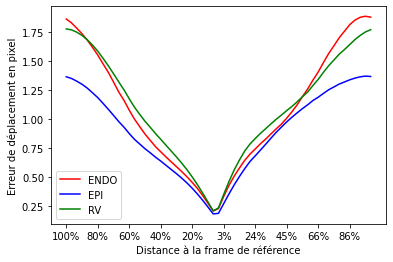

In [60]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

#with open(r'Loss_testings_Lib\2023-10-08_19H29\Validation\Task032_Lib\fold_0\Flow\validation_raw\summary.json', 'rb') as f:
#    data = json.load(f)
#    patient_data_list = data['all']

with open(r"C:\Users\Portal\Documents\voxelmorph\2023-11-06_10H24\Validation\Task032_Lib\all_validation\Postprocessed\Flow\contour_metrics.json", 'rb') as f:
    data = json.load(f)
    patient_data_list = data['all']

m = max([len(x['ENDO_mae']) for x in patient_data_list])

y_new_list_endo = []
y_new_list_epi = []
y_new_list_rv = []
for patient_data in patient_data_list:
    for name, current_list in zip(['ENDO_mae', 'EPI_mae', 'RV_mae'], [y_new_list_endo, y_new_list_epi, y_new_list_rv]):
        x = np.arange(0, len(patient_data[name]))
        y = patient_data[name]
        f = interpolate.interp1d(x, y)
        x_new = np.linspace(0, len(patient_data[name]) - 1, m)
        y_new = np.array(f(x_new))
        current_list.append(y_new)

endo = np.stack(y_new_list_endo, axis=0)
epi = np.stack(y_new_list_epi, axis=0)
rv = np.stack(y_new_list_rv, axis=0)

endo = endo.mean(0)
epi = epi.mean(0)
rv = rv.mean(0)

endo = np.roll(endo, shift=len(endo)//2)
epi = np.roll(epi, shift=len(endo)//2)
rv = np.roll(rv, shift=len(endo)//2)

x1 = np.arange(1, len(endo)//2 + 1) 
x2 = np.arange(len(endo)//2 + 1, 0, step=-1)
x1 = x1 / len(x1)
x2 = x2 / len(x2)
x = np.concatenate([x2, x1])
print(len(endo))
print(len(x))
print(len(x1))
print(len(x2))
print(x)

fig, ax = plt.subplots(1, 1)
ax.set_xticks(np.arange(len(endo))[::6])
ax.set_xticklabels([f'{s:.0%}' for s in x[::6]])
ax.set_xlabel('Distance à la frame de référence')
ax.set_ylabel('Erreur de déplacement en pixel')
ax.plot(endo, 'r', label='ENDO')
ax.plot(epi, 'b', label='EPI')
ax.plot(rv, 'g', label='RV')
ax.legend()
plt.savefig('suivi_de_points.png', dpi=600)

59
59
59
59
59
29
30
[0.5        0.48333333 0.46666667 0.45       0.43333333 0.41666667
 0.4        0.38333333 0.36666667 0.35       0.33333333 0.31666667
 0.3        0.28333333 0.26666667 0.25       0.23333333 0.21666667
 0.2        0.18333333 0.16666667 0.15       0.13333333 0.11666667
 0.1        0.08333333 0.06666667 0.05       0.03333333 0.01666667
 0.01724138 0.03448276 0.05172414 0.06896552 0.0862069  0.10344828
 0.12068966 0.13793103 0.15517241 0.17241379 0.18965517 0.20689655
 0.22413793 0.24137931 0.25862069 0.27586207 0.29310345 0.31034483
 0.32758621 0.34482759 0.36206897 0.37931034 0.39655172 0.4137931
 0.43103448 0.44827586 0.46551724 0.48275862 0.5       ]


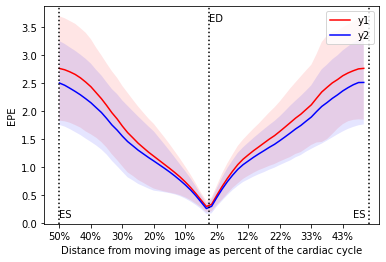

In [27]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

with open(r"C:\Users\Portal\Documents\voxelmorph\2023-11-28_16H36\Task032_Lib\fold_0\Lib\val\Postprocessed\Flow\contour_metrics.json", 'rb') as f:
    data = json.load(f)
    patient_data_list_1 = data['all']

with open(r"C:\Users\Portal\Documents\voxelmorph\2023-12-07_19H32\Task032_Lib\fold_0\Lib\val\Postprocessed\Flow\contour_metrics.json", 'rb') as f:
    data = json.load(f)
    patient_data_list_2 = data['all']

all_data_1 = []
all_data_2 = []
for k in patient_data_list_1.keys():
    all_data_1.extend(patient_data_list_1[k])
    all_data_2.extend(patient_data_list_2[k])

m = max([len(x['ENDO']) for x in all_data_1])

y_new_1_list = []
y_new_2_list = []
for (patient_data_1, patient_data_2) in zip(all_data_1, all_data_2):
    x = np.arange(0, len(patient_data_1['ENDO']))

    y1_endo = patient_data_1['ENDO']
    y2_endo = patient_data_2['ENDO']

    y1_epi = patient_data_1['EPI']
    y2_epi = patient_data_2['EPI']

    y1_rv = patient_data_1['RV']
    y2_rv = patient_data_2['RV']

    y1 = np.stack([y1_endo, y1_epi, y1_rv], axis=0).mean(0)
    y2 = np.stack([y2_endo, y2_epi, y2_rv], axis=0).mean(0)

    f1 = interpolate.interp1d(x, y1)
    f2 = interpolate.interp1d(x, y2)

    x_new = np.linspace(0, len(patient_data_1['ENDO']) - 1, m)
    y_new_1 = np.array(f1(x_new))
    y_new_2 = np.array(f2(x_new))

    y_new_1_list.append(y_new_1)
    y_new_2_list.append(y_new_2)

y1_arr = np.stack(y_new_1_list, axis=0)
y2_arr = np.stack(y_new_2_list, axis=0)
y1 = y1_arr.mean(0)
y1_error = y1_arr.std(0)
y2 = y2_arr.mean(0)
y2_error = y2_arr.std(0)

y1 = np.roll(y1, shift=len(y1)//2)
y1_error = np.roll(y1_error, shift=len(y1_error)//2)
y2 = np.roll(y2, shift=len(y2)//2)
y2_error = np.roll(y2_error, shift=len(y2_error)//2)

print(len(y1))
print(len(y1_error))

x1 = np.arange(1, len(y1)//2 + 1) 
x2 = np.arange(len(y1)//2 + 1, 0, step=-1)
x1 = x1 / (2 * len(x1))
x2 = x2 / (2 * len(x2))
x = np.concatenate([x2, x1])
print(len(y1))
print(len(y2))
print(len(x))
print(len(x1))
print(len(x2))
print(x)

x_axis = np.arange(len(y1))

fig, ax = plt.subplots(1, 1)
ax.set_xticks(np.arange(len(y1))[::6])
ax.set_xticklabels([f'{s:.0%}' for s in x[::6]])
ax.set_xlabel('Distance from moving image as percent of the cardiac cycle')
ax.set_ylabel('EPE')
ax.plot(y1, 'r', label='y1')
#ax.errorbar(x_axis, y1, y1_error, linestyle='None', marker='^', label='T=2')
ax.fill_between(x_axis, y1=y1 - y1_error, y2=y1 + y1_error, alpha=0.1, facecolor='r')
ax.plot(y2, 'b', label='y2')
#ax.errorbar(x_axis, y2, y2_error, linestyle='None', marker='^', label='T=12')
ax.fill_between(x_axis, y2 - y2_error, y2 + y2_error, alpha=0.1, facecolor='b')
ax.legend()
ax.axvline(x=(len(x) - 2) / 2, ls=':', c='k')
ax.axvline(x=0, ls=':', c='k')
ax.axvline(x=len(x), ls=':', c='k')
plt.text(0.0, 0.1, 'ES', fontsize = 10) 
plt.text(len(x)-3, 0.1, 'ES', fontsize = 10) 
plt.text((len(x) - 2) / 2, 3.6, 'ED', fontsize = 10) 
plt.savefig('suivi_de_points.png', dpi=600)

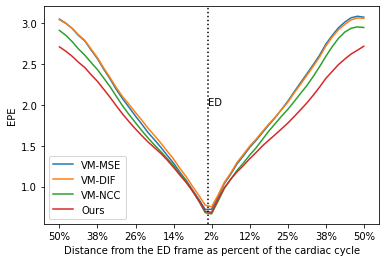

In [1]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Flow\contour_metrics.json",
            #"DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Flow\contour_metrics.json",
            #"Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Flow\contour_metrics.json",
            #"our2": r"C:\Users\Portal\Documents\voxelmorph\2024-01-04_21H25\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json"}

#path_list = {"ours2": r"C:\Users\Portal\Documents\voxelmorph\2024-01-19_11H19\Task032_Lib\fold_0\Lib\val\Postprocessed\Flow\contour_metrics.json",
#             "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\val\Postprocessed\Flow\contour_metrics.json"}

fig, ax = plt.subplots(1, 1)

for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list = data['all']

    all_data_1 = []
    for k in patient_data_list.keys():
        all_data_1.extend(patient_data_list[k])

    m = max([len(x['ENDO']) for x in all_data_1])

    y_new_1_list = []
    for patient_data_1 in all_data_1:
        x = np.arange(0, len(patient_data_1['ENDO']))

        y1_endo = patient_data_1['ENDO']

        y1_epi = patient_data_1['EPI']

        y1_rv = patient_data_1['RV']

        y1 = np.stack([y1_endo, y1_epi, y1_rv], axis=0).mean(0)

        f1 = interpolate.interp1d(x, y1)

        x_new = np.linspace(0, len(patient_data_1['ENDO']) - 1, m)
        y_new_1 = np.array(f1(x_new))

        y_new_1_list.append(y_new_1)

    y1_arr = np.stack(y_new_1_list, axis=0)
    y1 = y1_arr.mean(0)
    y1_error = y1_arr.std(0)

    y1 = np.roll(y1, shift=len(y1)//2)
    y1_error = np.roll(y1_error, shift=len(y1_error)//2)

    x1 = np.arange(1, len(y1)//2 + 1) 
    x2 = np.arange(len(y1)//2 + 1, 0, step=-1)
    x1 = x1 / (2 * len(x1))
    x2 = x2 / (2 * len(x2))
    x = np.concatenate([x2, x1])

    x_axis = np.arange(len(y1))

    ax.set_xticks(np.arange(len(y1))[::6])
    ax.set_xticklabels([f'{s:.0%}' for s in x[::6]])
    ax.plot(y1, label=key)
    #ax.errorbar(x_axis, y1, y1_error, linestyle='None', marker='^', label='T=2')
    #ax.fill_between(x_axis, y1=y1 - y1_error, y2=y1 + y1_error, alpha=0.1)

ax.set_ylabel('EPE')
ax.set_xlabel('Distance from the ED frame as percent of the cardiac cycle')
ax.axvline(x=(len(x) - 2) / 2, ls=':', c='k')
plt.text((len(x) - 2) / 2, 2.0, 'ED', fontsize = 10) 
ax.legend()
plt.savefig('EPE_in_time.png', dpi=600) #dpi=600

In [10]:
%matplotlib qt

import json
import os
import pickle
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

path_list = {"Trained using all frames":r"Quorum_cardioTrack_all_phases\fold_0\temp_allClasses\summary.json",
            "Trained using only ED and ES frames": r"Quorum_cardioTrack_ED_ES\fold_0\temp_allClasses\summary.json"}

fig, ax = plt.subplots(1, 1)
for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list = data['results']['all']
        patient_name_list = []
        for case_data in patient_data_list:
            patient_name = os.path.basename(case_data['reference']).split('_')[0]
            patient_name_list.append(patient_name)
        patient_name_list = list(set(patient_name_list))

        all_patient_data_list = []
        for patient_name in patient_name_list:
            one_patient_data = []
            for data in patient_data_list:
                if patient_name in data['reference']:
                    one_patient_data.append(data)
            one_patient_data = sorted(one_patient_data, key=lambda x:int(os.path.basename(x['reference']).split('.')[0][-2:]))
            all_patient_data_list.append(one_patient_data)
        
        m = max([len(x) for x in all_patient_data_list])

        y_new_1_list = []
        for patient_data_list in all_patient_data_list:

            patient_name = os.path.basename(patient_data_list[0]['reference']).split('_')[0]

            pkl_path = os.path.join('custom_lib_t_4', patient_name, 'info_01.pkl')
            with open(pkl_path, 'rb') as f2:
                data_pkl = pickle.load(f2)
                ed_number = np.rint(data_pkl['ed_number']).astype(int)
            
            frame_indices = np.arange(len(patient_data_list))
            before_where = np.argwhere(frame_indices < ed_number).reshape(-1,)
            after_where = np.argwhere(frame_indices >= ed_number).reshape(-1,)
            all_where = np.concatenate([after_where, before_where])

            patient_data_list = np.array(patient_data_list)[all_where]
            assert int(os.path.basename(patient_data_list[0]['reference']).split('.')[0][-2:]) == ed_number + 1, int(os.path.basename(patient_data_list[0]['reference']).split('.')[0][-2:])

            rv_dice = np.array([x['1']['Dice'] for x in patient_data_list])
            myo_dice = np.array([x['2']['Dice'] for x in patient_data_list])
            lv_dice = np.array([x['3']['Dice'] for x in patient_data_list])

            x = np.arange(0, len(patient_data_list))

            y1 = np.stack([rv_dice, myo_dice, lv_dice], axis=0).mean(0)

            f1 = interpolate.interp1d(x, y1)

            x_new = np.linspace(0, len(patient_data_list) - 1, m)
            y_new_1 = np.array(f1(x_new))

            y_new_1_list.append(y_new_1)
        

        y1_arr = np.stack(y_new_1_list, axis=0)
        print(y1_arr.shape)
        y1 = y1_arr.mean(0) * 100

        ax.plot(y1, label=key)

ax.set_ylabel('Dice score')
ax.set_xlabel('Phases of the cardiac cycle starting with ED')
ax.axvline(x=0, ls=':', c='k')
ax.fill_between(np.linspace(13.79, 23.79, 20), np.full(shape=(20,), fill_value=y1.min()), np.full(shape=(20,), fill_value=y1.max()), alpha=0.2, facecolor='red')
plt.text(-1, 93.0, 'ED', fontsize = 10) 
plt.text(16, 93.5, 'ES area', fontsize = 10) 
ax.legend()
plt.savefig('Dice_ed_es.png', dpi=600) #dpi=600

(51, 50)
(51, 50)


In [1]:
from glob import glob
import os
from pandas import DataFrame
import pandas as pd
import scipy
import mat73
from tqdm import tqdm

path_list_1 = glob(os.path.join(r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\data_saud_2\data\Quorum_Baseline_CardioTrack', '*'))
path_list_2 = glob(os.path.join(r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\data_lib_mat', '**', '*.mat'), recursive=True)
path_list_2 = [x for x in path_list_2 if 'Masks' in x]

manufacturer_list_1 = []
for path in tqdm(path_list_1):
    try:
        mat = mat73.loadmat(path)['data_mask']['orientations']['short_axis']['slices'][0]['acquisition']
        manufacturer = mat['Manufacturer']
    except:
        mat = scipy.io.loadmat(path, simplify_cells=True)
        my_list = mat['data']['orientations']['short_axis']['slices'][0]['acquisition']
        manufacturer = my_list['Manufacturer']
    manufacturer_list_1.append(manufacturer)

manufacturer_list_2 = []
for path in tqdm(path_list_2):
    try:
        mat = scipy.io.loadmat(path, simplify_cells=True)
        my_list = mat['data']['orientations']['short_axis']['slices'][0]['acquisition']
        manufacturer = my_list['Manufacturer']
    except:
        try:
            mat = mat73.loadmat(path)['data_mask']['orientations']['short_axis']['slices'][0]['acquisition']
            manufacturer = mat['Manufacturer']
        except:
            manufacturer_list_2.append(None)
            continue
    manufacturer_list_2.append(manufacturer)

print(len(path_list_1))
print(len(manufacturer_list_1))
print(len(path_list_2))
print(len(manufacturer_list_2))

path_list_1 = list(set([os.path.basename(x) for x in path_list_1]))
path_list_2 = list(set([os.path.basename(x) for x in path_list_2]))

d = dict( Saud = path_list_1, Jonas = path_list_2 , manufacturer_saud=manufacturer_list_1, manufacturer_jonas=manufacturer_list_2)
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df.to_excel('test.xlsx', sheet_name='sheet1', index=False)

  0%|          | 1/284 [00:02<11:52,  2.52s/it]

[]


  1%|          | 2/284 [00:10<27:14,  5.80s/it]

['GE MEDICAL SYSTEMS']


  1%|          | 3/284 [00:18<30:43,  6.56s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  1%|▏         | 4/284 [00:21<24:52,  5.33s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  2%|▏         | 5/284 [00:29<28:40,  6.17s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  2%|▏         | 6/284 [00:37<31:13,  6.74s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  2%|▏         | 7/284 [00:45<33:25,  7.24s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  3%|▎         | 8/284 [00:47<26:18,  5.72s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  4%|▎         | 10/284 [00:49<15:26,  3.38s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None]


  4%|▍         | 11/284 [00:51<13:49,  3.04s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS']


  4%|▍         | 12/284 [00:59<19:49,  4.37s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  5%|▍         | 13/284 [01:06<23:11,  5.13s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  5%|▍         | 14/284 [01:08<19:28,  4.33s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  5%|▌         | 15/284 [01:11<17:35,  3.92s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  6%|▌         | 16/284 [01:13<14:22,  3.22s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  6%|▌         | 17/284 [01:14<12:04,  2.71s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  6%|▋         | 18/284 [01:22<18:18,  4.13s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  7%|▋         | 19/284 [01:24<16:01,  3.63s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  7%|▋         | 20/284 [01:33<22:05,  5.02s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  7%|▋         | 21/284 [01:34<17:57,  4.10s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  8%|▊         | 22/284 [01:36<14:34,  3.34s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  8%|▊         | 23/284 [01:39<13:44,  3.16s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  8%|▊         | 24/284 [01:41<12:09,  2.81s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS']


  9%|▉         | 26/284 [01:42<07:55,  1.84s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None]


 10%|▉         | 28/284 [01:49<10:38,  2.50s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', None]


 10%|█         | 29/284 [01:58<17:41,  4.16s/it]

['GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS', None, 'GE MEDICAL SYSTEMS']


In [14]:
import pickle

with open(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task032_Lib\splits_final.pkl", 'rb') as f:
    data = pickle.load(f)[0]
    name_list = list(set([x.split('_')[0] for x in data['train']]))

type_list = []
for name in name_list:
    with open(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\custom_lib_t_4", name, "info_01.pkl"), 'rb') as f:
        data = pickle.load(f)
        mat_filename = data['FamilyName']
        type_list.append(mat_filename.split('_')[0])
print(type_list.count('CHOLCOEUR') / len(name_list))

0.38636363636363635


In [43]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torchvision.utils import flow_to_image
import torch
import cv2 as cv

with open(r'custom_lib_t_4\patient011\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data['ed_number'])
    print(data['es_number'])

step=4

data = np.load(r"C:\Users\Portal\Documents\voxelmorph\2024-02-08_12H44\Task045_Lib\fold_0\Lib\val\Raw\Flow\patient011\patient011_frame12.npz")
flow = data['flow']
print(flow.shape)
flow = torch.from_numpy(flow[:, :, 0]).permute(2, 0, 1)
flow = flow_to_image(flow).permute(1, 2, 0)

img = data['img'][:, :, 0]
print(img.shape)

fig, ax = plt.subplots(1, 2)
X, Y = np.meshgrid(np.arange(0, flow.shape[-2], step=step), np.arange(flow.shape[-1], step=step))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(flow, cmap='gray')
#ax.quiver(X, Y, flow[::step, ::step, 0, 1], flow[::step, ::step, 0, 0], color='r', angles='xy', scale_units='xy', scale=1)

flow = cv.cvtColor(flow.numpy(), cv.COLOR_BGR2RGB)
img = cv.normalize(img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)

cv.imwrite('ppt_img_1.png', img)

36.0
10.0
(192, 192, 3, 2)
(192, 192)


True

In [ ]:
import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle

with open(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\splits_final.pkl", 'rb') as f:
    data = pickle.load(f)
    training_patients = data[0]['train']
    validation_patients = data[0]['val']

path_list = glob(os.path.join(r"Lib_no_resampling", '*.gz'))
path_list_gt = glob(os.path.join(r"Lib_no_resampling_gt", '*.gz'))
path_list_train = sorted([x for x in path_list if os.path.basename(x)[:-7] in training_patients])
path_list_train_gt = sorted([x for x in path_list_gt if os.path.basename(x)[:-7] in training_patients])
path_list_val = sorted([x for x in path_list if os.path.basename(x)[:-7] in validation_patients])
path_list_val_gt = sorted([x for x in path_list_gt if os.path.basename(x)[:-7] in validation_patients])

path_dict_in = {'path_list_train': {},
                'path_list_train_gt': {},
                'path_list_val': {},
                'path_list_val_gt': {}}


for training_patient_name in training_patients:
    patient_nb = os.path.basename(training_patient_name).split('_')[0]
    path_dict_in['path_list_train'][patient_nb] = sorted([x for x in path_list_train if patient_nb in x])
    path_dict_in['path_list_train_gt'][patient_nb] = sorted([x for x in path_list_train_gt if patient_nb in x])

for validation_patient_name in validation_patients:
    patient_nb = os.path.basename(validation_patient_name).split('_')[0]
    path_dict_in['path_list_val'][patient_nb] = sorted([x for x in path_list_val if patient_nb in x])
    path_dict_in['path_list_val_gt'][patient_nb] = sorted([x for x in path_list_val_gt if patient_nb in x])


path_dict_out_train = {'path_list_train_moving': [],
                        'path_list_train_fixed': [],
                        'path_list_train_moving_gt': [],
                        'path_list_train_fixed_gt': []}


for patient_nb in path_dict_in['path_list_train'].keys():
    with open(os.path.join(r"Lib_no_resampling", patient_nb + '_frame01.pkl'), 'rb') as f:
        data = pickle.load(f)
        ed_number = np.rint(data['ed_number']).astype(int)
        es_number = np.rint(data['es_number']).astype(int)
        ed_list = [path_dict_in['path_list_train'][patient_nb][ed_number]]
        es_list = [path_dict_in['path_list_train'][patient_nb][es_number]]
        path_dict_out_train['path_list_train_moving'].extend(es_list)
        path_dict_out_train['path_list_train_fixed'].extend(ed_list)

for patient_nb in path_dict_in['path_list_train_gt'].keys():
    with open(os.path.join(r"Lib_no_resampling", patient_nb + '_frame01.pkl'), 'rb') as f:
        data = pickle.load(f)
        ed_number = np.rint(data['ed_number']).astype(int)
        es_number = np.rint(data['es_number']).astype(int)
        ed_list = [path_dict_in['path_list_train_gt'][patient_nb][ed_number]]
        es_list = [path_dict_in['path_list_train_gt'][patient_nb][es_number]]
        path_dict_out_train['path_list_train_moving_gt'].extend(es_list)
        path_dict_out_train['path_list_train_fixed_gt'].extend(ed_list)


path_list_train = [x.replace(os.sep, '/') + '\n' for x in path_dict_out_train['path_list_train_moving']]
with open('train_list_moving_2D_Lib.txt', 'w') as f:
    f.writelines(path_list_train)

path_list_train = [x.replace(os.sep, '/') + '\n' for x in path_dict_out_train['path_list_train_fixed']]
with open('train_list_fixed_2D_Lib.txt', 'w') as f:
    f.writelines(path_list_train)

path_list_train_gt = [x.replace(os.sep, '/') + '\n' for x in path_dict_out_train['path_list_train_moving_gt']]
with open('train_list_moving_seg_2D_Lib.txt', 'w') as f:
    f.writelines(path_list_train_gt)

path_list_train_gt = [x.replace(os.sep, '/') + '\n' for x in path_dict_out_train['path_list_train_fixed_gt']]
with open('train_list_fixed_seg_2D_Lib.txt', 'w') as f:
    f.writelines(path_list_train_gt)

In [ ]:
%matplotlib qt

from glob import glob
import os
import nibabel as nib
from skimage.measure import label
from tqdm import tqdm
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import numpy as np

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

in_path = r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations'
out_path = r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task040_Quorum_revised\gt_segmentations'

#delete_if_exist(out_path)
#os.makedirs(out_path)

nb_slices_list = []
path_list = glob(os.path.join(in_path, '*.gz'))
path_list_img = glob(os.path.join(r'C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task027_ACDC\custom_experiment_planner_stage0', '*.npy'))
path_list_img = [x for x in path_list_img if '_u' not in x]

for path, path_img in tqdm(zip(path_list, path_list_img), total=len(path_list)):

    filename = os.path.basename(path)
    print(path)
    print(path_img)
    data = nib.load(path)
    arr = data.get_fdata()
    nb_slices_list.append(arr.shape[-1])
    processed_arr = arr.copy()
    processed_arr[processed_arr < 0] = 0
    for d in range(processed_arr.shape[-1]):
        if d == 1:
            img = np.load(path_img)
            assert img.shape[1] == processed_arr.shape[-1]
            img = img[0, d]
            img = img.transpose(1, 0)
            print(processed_arr.shape)
            print(img.shape)
            slice_mask_rv = processed_arr[:, :, d] == 1
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(arr[:, :, d].copy(), cmap='gray')
            arr[:, :, d][slice_mask_rv] = 0
            #ax[1].imshow(arr[:, :, d], cmap='gray')
            ax[1].imshow(img, cmap='gray')
            plt.show()
            plt.waitforbuttonpress()
            plt.close(fig)

print(np.array(nb_slices_list).mean())
    
#current_label = nib.Nifti1Image(arr, affine=data.affine, header=data.header)
#nib.save(current_label, os.path.join(out_path, filename))  

In [62]:
%matplotlib qt

from glob import glob
import os
import nibabel as nib
from skimage.measure import label
from tqdm import tqdm
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import numpy as np
'cacacacacacacacacaca'

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

path_list_quorum = glob(os.path.join(r'custom_quorum\patient004', '*.gz')) #4, 84, 12, 42, 110, 152
path_list_quorum_gt = [x for x in path_list_quorum if '_gt' in x]
path_list_quorum_img = [x for x in path_list_quorum if '_gt' not in x]

path_list_ACDC = glob(os.path.join(r'ACDC_training\patient023', '*.gz')) #23
path_list_ACDC_gt = [x for x in path_list_ACDC if '_gt' in x]
path_list_ACDC_img = [x for x in path_list_ACDC if '_gt' not in x]
path_list_ACDC_img = [x for x in path_list_ACDC_img if '4d' not in x]

for quorum_img_path, quorum_gt_path in zip(path_list_quorum_img, path_list_quorum_gt):
    data_img = nib.load(quorum_img_path)
    arr_img = data_img.get_fdata()

    data_gt = nib.load(quorum_gt_path)
    arr_gt = data_gt.get_fdata()

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(arr_img[:, :, 0], cmap='gray')
    ax[1].imshow(arr_gt[:, :, 0], cmap='gray')
    plt.waitforbuttonpress()
    plt.show()
    plt.close(fig)

#for acdc_img_path, acdc_gt_path in zip(path_list_ACDC_img, path_list_ACDC_gt):
#    data_img = nib.load(acdc_img_path)
#    arr_img = data_img.get_fdata()
#
#    data_gt = nib.load(acdc_gt_path)
#    arr_gt = data_gt.get_fdata()
#
#    fig, ax = plt.subplots(1, 2)
#    ax[0].imshow(arr_img[:, :, 0], cmap='gray')
#    ax[1].imshow(arr_gt[:, :, 0], cmap='gray')
#    plt.waitforbuttonpress()
#    plt.show()
#    plt.close(fig)

KeyboardInterrupt: 

In [66]:
%matplotlib qt

from glob import glob
import os
import nibabel as nib
from skimage.measure import label
from tqdm import tqdm
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

data_acdc_img = nib.load(r'ACDC_training\patient005\patient005_frame01.nii.gz')
data_acdc_gt = nib.load(r'ACDC_training\patient005\patient005_frame01_gt.nii.gz')

data_quorum_img = nib.load(r'custom_quorum\patient004\patient004_ed.nii.gz')
data_quorum_gt = nib.load(r'custom_quorum\patient004\patient004_ed_gt.nii.gz')

arr_acdc_img = data_acdc_img.get_fdata()[:, :, 0]
arr_acdc_gt = data_acdc_gt.get_fdata()[:, :, 0]

arr_quorum_img = data_quorum_img.get_fdata()[:, :, 0]
arr_quorum_gt = data_quorum_gt.get_fdata()[:, :, 0]

arr_acdc_img = cv.normalize(arr_acdc_img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
arr_acdc_img = cv.cvtColor(arr_acdc_img, cv.COLOR_GRAY2RGB)

arr_quorum_img = cv.normalize(arr_quorum_img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
arr_quorum_img = cv.cvtColor(arr_quorum_img, cv.COLOR_GRAY2RGB)

for j in range(1, 4):
    current_arr_acdc_gt = (arr_acdc_gt == j).astype(np.uint8)
    current_arr_quorum_gt = (arr_quorum_gt == j).astype(np.uint8)

    if j == 2:
        current_arr_quorum_gt = np.logical_or(current_arr_quorum_gt, (arr_quorum_gt == 3).astype(np.uint8))
        current_arr_quorum_gt = current_arr_quorum_gt.astype(np.uint8)

    #fig, ax = plt.subplots(1, 2)
    #ax[0].imshow(current_arr_acdc_gt, cmap='gray')
    #ax[1].imshow(current_arr_quorum_gt, cmap='gray')
    #plt.waitforbuttonpress()
    #plt.show()
    #plt.close(fig)

    acdc_contours, hierarchy = cv.findContours(current_arr_acdc_gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    quorum_contours, hierarchy = cv.findContours(current_arr_quorum_gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    color = [0, 0, 0]
    color[j - 1] = 255
    arr_acdc_img = cv.drawContours(arr_acdc_img, acdc_contours, -1, color, 1)
    arr_quorum_img = cv.drawContours(arr_quorum_img, quorum_contours, -1, color, 1)

print(arr_acdc_img.shape)
print(arr_quorum_img.shape)
arr_acdc_img = arr_acdc_img.transpose((1, 0, 2))
arr_acdc_img = np.rot90(arr_acdc_img, 1)


to_pad = (arr_acdc_img.shape[0] - arr_quorum_img.shape[0])
pad_top = max(0, to_pad // 2)
pad_bottom = pad_top + to_pad % 2

to_pad = (arr_acdc_img.shape[1] - arr_quorum_img.shape[1])
pad_left = max(0, to_pad // 2)
pad_right = pad_left + to_pad % 2

print(pad_right)
print(pad_bottom)

arr_quorum_img = np.pad(arr_quorum_img, pad_width=((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)))

to_pad = (arr_quorum_img.shape[0] - arr_acdc_img.shape[0])
pad_top = max(0, to_pad // 2)
pad_bottom = pad_top + to_pad % 2

to_pad = (arr_quorum_img.shape[1] - arr_acdc_img.shape[1])
pad_left = max(0, to_pad // 2)
pad_right = pad_left + to_pad % 2

print(pad_right)
print(pad_bottom)

arr_acdc_img = np.pad(arr_acdc_img, pad_width=((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)))

fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(arr_acdc_img, cmap='gray')
ax[1].imshow(arr_quorum_img, cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
#ax[0].set_title('ACDC')
#ax[1].set_title('In-house')
plt.tight_layout()
#plt.waitforbuttonpress()
#plt.show()
#plt.close(fig)
plt.savefig('comparison_acdc_quorum.png', dpi=600)

(256, 216, 3)
(272, 236, 3)
0
0
10
8


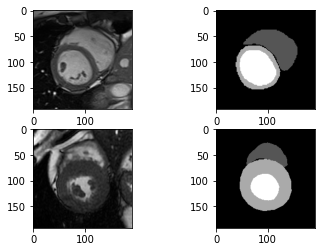

In [22]:
import matplotlib.pyplot as plt
import nibabel as nib

fig, ax = plt.subplots(2, 2)
data1 = nib.load(r'voxelmorph_Lib_2D\patient175_frame01.nii.gz')
arr1 = data1.get_fdata()

data2 = nib.load(r'voxelmorph_Lib_2D_gt\patient175_frame01.nii.gz')
arr2 = data2.get_fdata()

data3 = nib.load(r'voxelmorph_Lib_2D\patient020_frame01.nii.gz')
arr3 = data3.get_fdata()

data4 = nib.load(r'voxelmorph_Lib_2D_gt\patient020_frame01.nii.gz')
arr4 = data4.get_fdata()


ax[0, 0].imshow(arr1[:, :, 0], cmap='gray')
ax[0, 1].imshow(arr2[:, :, 0], cmap='gray')
ax[1, 0].imshow(arr3[:, :, 2], cmap='gray')
ax[1, 1].imshow(arr4[:, :, 2], cmap='gray')

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os

df = pd.read_excel('bad_results.xlsx')
name_list = list(df['Name'].values)

for name in name_list:
    with open(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\custom_lib_t_4", name, "info_01.pkl"), 'rb') as f:
        data = pickle.load(f)
        mat_filename = data['Database']
        print(mat_filename)

#with open(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\custom_lib_t_4\patient220\info_01.pkl", 'rb') as f:
#    data = pickle.load(f)
#    mat_filename = data['FamilyName']
#    print(mat_filename)

Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_cholesterolemia
Hyper_chol

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os

df = pd.read_excel('good_results.xlsx')
name_list = list(df['Name'].values)

for name in name_list:
    with open(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\custom_lib_t_4", name, "info_01.pkl"), 'rb') as f:
        data = pickle.load(f)
        mat_filename = data['Database']
        print(mat_filename)

#with open(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\custom_lib_t_4\patient220\info_01.pkl", 'rb') as f:
#    data = pickle.load(f)
#    mat_filename = data['FamilyName']
#    print(mat_filename)

CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
CVD_old
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_Control
Healthy_

In [2]:
from glob import glob
import os
import pickle
import csv

path_list = glob(os.path.join('custom_lib_t_4', '**', '*.pkl'), recursive=True)
data_list = []
for path in path_list:
    with open(path, 'rb') as f:
        data = pickle.load(f)
        data_dict = {'database': data['Database'], 'resX': data['resX'], 'resT': data['resT']}
        data_list.append(data_dict)

with open('understand_bug.csv', 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(data_list[0].keys()))
    writer.writeheader() 
    writer.writerows(data_list) 

In [15]:
import pickle
import numpy as np

with open(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task032_Lib\custom_experiment_planner_plans_2D.pkl", 'rb') as f:
    data = pickle.load(f)
    print(data.keys())
    print(data['original_spacings'])
    print(data['plans_per_stage'])
    arr = np.stack(data['original_spacings'])[:, -1]
    print(np.median(arr))

dict_keys(['num_stages', 'num_modalities', 'modalities', 'normalization_schemes', 'dataset_properties', 'list_of_npz_files', 'original_spacings', 'original_sizes', 'preprocessed_data_folder', 'num_classes', 'all_classes', 'base_num_features', 'use_mask_for_norm', 'keep_only_largest_region', 'min_region_size_per_class', 'min_size_per_class', 'transpose_forward', 'transpose_backward', 'data_identifier', 'plans_per_stage', 'preprocessor_name'])
[array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.        , 0.74220002, 0.74220002]), array([8.    

In [7]:
from glob import glob
import os
import pickle
from tqdm import tqdm
import numpy as np

out_list = []

path_list = glob(os.path.join(r'custom_lib_t_4', '**', '*01.pkl'))
for path in tqdm(path_list):
    with open(path, 'rb') as f:
        data = pickle.load(f)
        d = abs(data['ed_number'] - data['es_number'])
        out_list.append(d)

print(len(out_list))
print(np.array(out_list).mean())
        

100%|██████████| 271/271 [00:00<?, ?it/s]

271
18.793849938499385


In [ ]:
import nibabel as nib
from glob import glob
import os

path_list = glob(os.path.join(r'ACDC_training', '**', '*4d.nii.gz'))
for path in path_list:
    data = nib.load(path)
    print(path)
    print(data.affine)
    print(data.header.get_zooms())
    print(data.header['dim'])

In [61]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Raw\Flow\ssim_metrics.json",
             "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Raw\Flow\ssim_metrics.json",
             "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Raw\Flow\ssim_metrics.json",
             "SyN":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Syn\Lib\test\Raw\Flow\ssim_metrics.json",
             "IterWarpImg":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\temp\Lib\test\Raw\Flow\ssim_metrics.json",
             "IterWarpFlow":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\temp_sum\Lib\test\Raw\Flow\ssim_metrics.json",
             #"DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Raw\Flow\ssim_metrics.json",
             #"Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Raw\Flow\ssim_metrics.json",
             #"Prediction": r"C:\Users\Portal\Documents\voxelmorph\2024-01-04_21H25\Task032_Lib\fold_0\Lib\test\Raw\Flow\ssim_metrics.json",
             "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Raw\Flow\ssim_metrics.json"}
fig, ax = plt.subplots(1, 1)

min_list = []

for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        all_data_1 = data['all']

    print(all_data_1)

    m = max([len(x['SSIM']) for x in all_data_1])

    y_new_1_list = []
    for patient_data_1 in all_data_1:
        x = np.arange(0, len(patient_data_1['SSIM']))

        y1 = patient_data_1['SSIM']

        f1 = interpolate.interp1d(x, y1)

        x_new = np.linspace(0, len(patient_data_1['SSIM']) - 1, m)
        y_new_1 = np.array(f1(x_new))

        y_new_1_list.append(y_new_1)

    y1_arr = np.stack(y_new_1_list, axis=0)
    y1 = y1_arr.mean(0)
    y1_error = y1_arr.std(0)

    min_list.append(y1.min())
    min_list.append(y1.max())

    #y1 = np.roll(y1, shift=len(y1)//2)
    #y1_error = np.roll(y1_error, shift=len(y1_error)//2)
#
    #x1 = np.arange(1, len(y1)//2 + 1) 
    #x2 = np.arange(len(y1)//2 + 1, 0, step=-1)
    #x1 = x1 / (2 * len(x1))
    #x2 = x2 / (2 * len(x2))
    #x = np.concatenate([x2, x1])

    x = np.arange(len(y1)) / len(y1)

    x_axis = np.arange(len(y1))

    ax.set_xticks(np.arange(len(y1))[::6])
    ax.set_xticklabels([f'{s:.0%}' for s in x[::6]])
    ax.plot(y1, label=key)
    #ax.errorbar(x_axis, y1, y1_error, linestyle='None', marker='^', label='T=2')
    #ax.fill_between(x_axis, y1=y1 - y1_error, y2=y1 + y1_error, alpha=0.1)

ax.set_ylabel('SSIM')
ax.set_xlabel('Distance from the ED frame as percent of the cardiac cycle')
ax.fill_between(np.linspace(19, 29, 20), np.full(shape=(20,), fill_value=min(min_list)), np.full(shape=(20,), fill_value=max(min_list)), alpha=0.2, facecolor='red')
ax.axvline(x=0, ls=':', c='k')
plt.text((len(x) - 7) / 2, 0.8, 'ES area', fontsize = 10)  
plt.text(-1, 0.8, 'ED', fontsize = 10) 
ax.legend()
plt.savefig('SSIM_in_time.png', dpi=600) #dpi=600

[{'ES_SSIM': 0.7466644385408535, 'Name': 'patient007', 'SSIM': [0.9664813379159198, 0.9075946027970195, 0.8606449920349607, 0.8376193131970227, 0.8270882283526565, 0.8269756119533221, 0.830852660689991, 0.8361662709687812, 0.8343128029678327, 0.8285148645080878, 0.823063612948408, 0.807735819306871, 0.7966502500690955, 0.7807629516176552, 0.7631699371076596, 0.7547969744598347, 0.7466644385408535, 0.7416045769834616, 0.744800775383523, 0.7487401568210242, 0.7500584932348197, 0.7581642497549109, 0.7673955471014287, 0.7778288382757811, 0.797080926409851, 0.8221207049913718, 0.834383459911174, 0.841556386918254, 0.8478943713405397, 0.8518050590140407, 0.8539471264112884, 0.861130883183185, 0.8666126768002074, 0.8713309863385267, 0.8774720378628759, 0.8834787465220044, 0.900003471635909, 0.9303003332355236, 0.9725777156017941], 'slice_number': 0}, {'ES_SSIM': 0.7388293430245413, 'Name': 'patient007', 'SSIM': [0.9692961803894514, 0.9176264146749769, 0.8721100716868947, 0.8477859796064564, 0

In [18]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'custom_lib_t_4\patient029\patient029_frame35.nii.gz')
arr = data.get_fdata()
print(arr.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[:, :, 0], cmap='gray')

(512, 512, 3)


In [3]:
%matplotlib qt

from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

path_list = {"V1":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\val\Postprocessed\Flow\contour_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2024-01-18_18H32\Task032_Lib\fold_0\Lib\val\Postprocessed\Flow\contour_metrics.json"}

fig, ax = plt.subplots(1, 3, sharey=True)
for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list = data['all']

    all_data = []
    for k in patient_data_list.keys():
        all_data.extend(patient_data_list[k])

    all_data_1 = [x for x in all_data if len(x['ENDO']) <= 28]
    all_data_2 = [x for x in all_data if len(x['ENDO']) <= 45 and len(x['ENDO']) > 28]
    all_data_3 = [x for x in all_data if (len(x['ENDO']) <= 100 and len(x['ENDO']) > 45)]

    print(len(all_data_1))
    print(len(all_data_2))
    print(len(all_data_3))

    y_new_dict = {'0-28': [], '28-45': [], '45-': []}
    idx = 0

    for key_range, all_data in zip(['0-28', '28-45', '45-'], [all_data_1, all_data_2, all_data_3]):

        m = max([len(x['ENDO']) for x in all_data])

        for patient_data_1 in all_data:
            x = np.arange(0, len(patient_data_1['ENDO']))

            y1_endo = patient_data_1['ENDO']

            y1_epi = patient_data_1['EPI']

            y1_rv = patient_data_1['RV']

            y1 = np.stack([y1_endo, y1_epi, y1_rv], axis=0).mean(0)

            f1 = interpolate.interp1d(x, y1)

            x_new = np.linspace(0, len(patient_data_1['ENDO']) - 1, m)
            y_new_1 = np.array(f1(x_new))

            y_new_dict[key_range].append(y_new_1)

        y1_arr = np.stack(y_new_dict[key_range], axis=0)
        y1 = y1_arr.mean(0)
        y1_error = y1_arr.std(0)

        y1 = np.roll(y1, shift=len(y1)//2)
        y1_error = np.roll(y1_error, shift=len(y1_error)//2)

        x1 = np.arange(0, len(y1)//2)
        if len(y1) % 2 == 0:
            x2 = np.arange(len(y1)//2, 0, step=-1)
        else:
            x2 = np.arange(len(y1)//2, -1, step=-1)
        x1 = x1 / (2 * len(x1))
        x2 = x2 / (2 * len(x2))
        x = np.concatenate([x2, x1])

        x_axis = np.arange(len(y1))

        ax[idx].set_xticks(np.arange(len(y1))[::6])
        ax[idx].set_xticklabels([f'{s:.0%}' for s in x[::6]])
        ax[idx].plot(y1, label=key)

        ax[idx].set_ylabel('EPE')
        ax[idx].set_xlabel('Distance from the ED frame as percent of the cardiac cycle')
        ax[idx].axvline(x=(len(x) - 2) / 2, ls=':', c='k')
        ax[idx].axvline(x=0, ls=':', c='k')
        ax[idx].axvline(x=len(x), ls=':', c='k')
        #plt.text(0.2, 1.0, 'ES', fontsize = 10) 
        #plt.text(len(x)-2.5, 1.0, 'ES', fontsize = 10) 
        #plt.text((len(x) - 2) / 2, 3.0, 'ED', fontsize = 10) 
        ax[idx].legend()
        idx += 1

54
40
48
54
40
48


In [10]:
%matplotlib qt

from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

path_list = {"V1":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json"}


with open(path_list["Ours"]) as f:
    data = json.load(f)
    patient_data_list = data['all']

all_data = []
for k in patient_data_list.keys():
    all_data.extend(patient_data_list[k])

nb_plots = 0
for i in range(100):
    current_all_data = [x for x in all_data if len(x['ENDO']) == i]
    if current_all_data:
        print(i)
        nb_plots += 1


fig, ax = plt.subplots(1, nb_plots, sharey=True)

for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list = data['all']

    all_data = []
    for k in patient_data_list.keys():
        all_data.extend(patient_data_list[k])

    data_per_length = {}
    y_new_dict = {}
    for i in range(100):
        current_all_data = [x for x in all_data if len(x['ENDO']) == i]
        if current_all_data:
            data_per_length[i] = current_all_data
            y_new_dict[i] = []

    #all_data_1 = [x for x in all_data if len(x['ENDO']) <= 28]
    #all_data_2 = [x for x in all_data if len(x['ENDO']) <= 45 and len(x['ENDO']) > 28]
    #all_data_3 = [x for x in all_data if (len(x['ENDO']) <= 100 and len(x['ENDO']) > 45)]
    #print(len(all_data_1))
    #print(len(all_data_2))
    #print(len(all_data_3))

    idx = 0
    print('**************************************')

    for key_range in data_per_length.keys():

        print(len(data_per_length[key_range]))

        m = max([len(x['ENDO']) for x in data_per_length[key_range]])

        for patient_data_1 in data_per_length[key_range]:
            x = np.arange(0, len(patient_data_1['ENDO']))

            y1_endo = patient_data_1['ENDO']

            y1_epi = patient_data_1['EPI']

            y1_rv = patient_data_1['RV']

            y1 = np.stack([y1_endo, y1_epi, y1_rv], axis=0).mean(0)

            f1 = interpolate.interp1d(x, y1)

            x_new = np.linspace(0, len(patient_data_1['ENDO']) - 1, m)
            y_new_1 = np.array(f1(x_new))

            y_new_dict[key_range].append(y_new_1)

        y1_arr = np.stack(y_new_dict[key_range], axis=0)
        y1 = y1_arr.mean(0)
        y1_error = y1_arr.std(0)

        y1 = np.roll(y1, shift=len(y1)//2)
        y1_error = np.roll(y1_error, shift=len(y1_error)//2)

        x1 = np.arange(0, len(y1)//2)
        if len(y1) % 2 == 0:
            x2 = np.arange(len(y1)//2, 0, step=-1)
        else:
            x2 = np.arange(len(y1)//2, -1, step=-1)
        x1 = x1 / (2 * len(x1))
        x2 = x2 / (2 * len(x2))
        x = np.concatenate([x2, x1])

        x_axis = np.arange(len(y1))

        ax[idx].set_xticks(np.arange(len(y1))[::6])
        ax[idx].set_xticklabels([f'{s:.0%}' for s in x[::6]])
        ax[idx].plot(y1, label=key)

        ax[idx].set_ylabel('EPE')
        ax[idx].set_xlabel('Distance from the ED frame as percent of the cardiac cycle')
        ax[idx].axvline(x=(len(x) - 2) / 2, ls=':', c='k')
        ax[idx].axvline(x=0, ls=':', c='k')
        ax[idx].axvline(x=len(x), ls=':', c='k')
        #plt.text(0.2, 1.0, 'ES', fontsize = 10) 
        #plt.text(len(x)-2.5, 1.0, 'ES', fontsize = 10) 
        #plt.text((len(x) - 2) / 2, 3.0, 'ED', fontsize = 10) 
        ax[idx].legend()
        idx += 1

24
29
39
49
**************************************
45
21
38
62
**************************************
45
21
38
62


In [49]:
data = np.load(r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Raw\Flow\patient007\patient007_frame36.npz")
flow = data['flow'][:, :, 0].transpose(2, 0, 1)
img = data['img'][:, :, 0]
print(img.shape)
print(flow.shape)

fig, ax = plt.subplots(1, 1)
X, Y = np.meshgrid(np.arange(0, flow.shape[1], step=2), np.arange(flow.shape[2], step=2))
ax.imshow(img, cmap='gray')
ax.quiver(X, Y, flow[1, ::2, ::2], flow[0, ::2, ::2], color='r', angles='xy', scale_units='xy', scale=1)

(192, 192)
(2, 192, 192)


In [7]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import flow_to_image
import torch
from glob import glob
import os
import cv2 as cv

fourcc = cv.VideoWriter_fourcc(*'mp4v')

depth = 0
video_name = 'color.mp4'
W, H = 192, 192
video = cv.VideoWriter(video_name, fourcc, 6, (H, W))

path_list = glob(os.path.join(r'C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Raw\Flow\patient007', '*.npz'))

for path in path_list:
    data = np.load(path)
    flow = data['flow'][:, :, depth]
    flow = torch.from_numpy(flow)
    flow = flow.permute(2, 0, 1)
    flow = flow_to_image(flow).permute(1, 2, 0)
    video.write(flow.numpy())

cv.destroyAllWindows()
video.release()

fig, ax = plt.subplots(1, 1)
ax.imshow(flow)

In [5]:
import os
from glob import glob
import nibabel as nib

input_path = r'C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\val\Postprocessed\Registered'
patient_dirs = next(os.walk(input_path))[1]

for patient in patient_dirs:
    path = glob(os.path.join(input_path, patient, '*.gz'))[0]
    data = nib.load(path)
    arr = data.get_fdata()
    print(arr.shape)

(512, 512, 3)
(512, 512, 3)
(207, 224, 5)
(225, 234, 5)
(512, 512, 3)
(222, 245, 6)
(196, 216, 4)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 4)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 4)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(288, 288, 3)
(288, 272, 3)
(288, 264, 3)
(288, 224, 3)
(288, 232, 3)
(288, 264, 3)
(288, 288, 3)
(288, 248, 3)
(288, 264, 3)
(288, 288, 3)
(288, 216, 3)
(288, 288, 3)
(288, 272, 3)
(288, 272, 3)
(288, 264, 3)
(288, 208, 3)
(288, 248, 3)
(288, 288, 3)


In [12]:
import pickle

with open(r'Lib_training_2\patient011\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)

{'FileName': 'RACINE_BP04055_20140708.mat', 'python_Name': 'RACINE_BP04055_20140708_Slice_11.npz', 'FamilyName': 'RACINE_BP04055', 'orientations': 'short_axis', 'slice_num': 11, 'PatientBirthDate': '050Y', 'PatientSex': 'M', 'PatientWeight': 69, 'Manufacturer': 'GE MEDICAL SYSTEMS', 'MagneticFieldStrength': 1.5, 'ed_number': 36.0, 'es_number': 10.0, 'Database': 'CVD_old', 'SliceThickness': 7, 'SpacingBetweenSlices': 9.0, 'label_img': 0, 'refPoint_RV': '1x4 cell', 'refPoint_LV': '1x4 cell', 'resX': 0.625, 'resY': 0.625, 'resT': 0.025, 'folder': 'CVD_old'}


In [3]:
import nibabel as nib
from glob import glob
import os
import numpy as np
from tqdm import tqdm
from pathlib import Path
import shutil

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

patient_paths = glob(r'C:\Users\Portal\Documents\biomechanical_loss\Dataset\Lib\testing\*')
for patient_path in tqdm(patient_paths):

    cfg_path = os.path.join(patient_path, 'info.cfg')
    with open(cfg_path, 'r') as f:
        lines = f.readlines()
        ed_idx = int(lines[0].split(' ')[-1]) - 1
        es_idx = int(lines[1].split(' ')[-1]) - 1

    patient_path_list = glob(os.path.join(patient_path, '*.gz'))
    img_patient_path_list = sorted([x for x in patient_path_list if '_gt' not in x])
    label_patient_path_list = sorted([x for x in patient_path_list if '_gt' in x])
    assert len(img_patient_path_list) == len(label_patient_path_list)
    patient_img_list = []
    patient_label_list = []
    for img_path, label_path in zip(img_patient_path_list, label_patient_path_list):
        img_data = nib.load(img_path)
        label_data = nib.load(label_path)

        img = img_data.get_fdata()
        label = label_data.get_fdata()

        patient_img_list.append(img)
        patient_label_list.append(label)
    
    header = img_data.header
    
    patient_img_list = np.stack(patient_img_list, axis=-1)
    patient_label_list = np.stack(patient_label_list, axis=-1)

    ed_img = patient_img_list[:, :, :, ed_idx]
    es_img = patient_img_list[:, :, :, ed_idx]

    ed_label = patient_label_list[:, :, :, ed_idx]
    es_label = patient_label_list[:, :, :, ed_idx]

    out_path = os.path.join(r'C:\Users\Portal\Documents\joint_learning\Dataset\Lib\testing', os.path.basename(patient_path))

    patient_img_list = nib.Nifti1Image(patient_img_list, affine=np.eye(4), header=header)
    ed_img = nib.Nifti1Image(ed_img, affine=np.eye(4), header=header)
    es_img = nib.Nifti1Image(es_img, affine=np.eye(4), header=header)
    ed_label = nib.Nifti1Image(ed_label, affine=np.eye(4), header=header)
    es_label = nib.Nifti1Image(es_label, affine=np.eye(4), header=header)

    delete_if_exist(out_path)
    Path(out_path).mkdir(parents=True, exist_ok=True)

    nib.save(patient_img_list, os.path.join(out_path, 'sa.nii.gz'))
    nib.save(ed_img, os.path.join(out_path, 'sa_ED.nii.gz'))  
    nib.save(es_img, os.path.join(out_path, 'sa_ES.nii.gz'))  
    nib.save(ed_label, os.path.join(out_path, 'label_sa_ED.nii.gz'))  
    nib.save(es_label, os.path.join(out_path, 'label_sa_ES.nii.gz'))

100%|██████████| 51/51 [00:49<00:00,  1.02it/s]


39
19
20
[1.         0.95       0.9        0.85       0.8        0.75
 0.7        0.65       0.6        0.55       0.5        0.45
 0.4        0.35       0.3        0.25       0.2        0.15
 0.1        0.05       0.05263158 0.10526316 0.15789474 0.21052632
 0.26315789 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579
 0.57894737 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526
 0.89473684 0.94736842 1.        ]
39
39
39
39
39
39
39


C:\Users\Portal\AppData\Local\Temp/ipykernel_10584/27290368.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


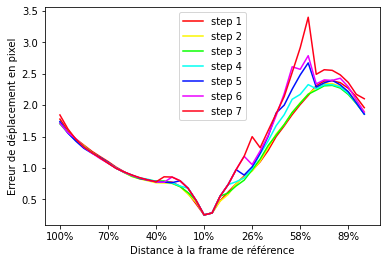

In [62]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

#with open(r'Loss_testings_Lib\2023-10-08_19H29\Validation\Task032_Lib\fold_0\Flow\validation_raw\summary.json', 'rb') as f:
#    data = json.load(f)
#    patient_data_list = data['all']

data_list = []
for i in range(1, 8):
    with open(r"C:\Users\Portal\Documents\voxelmorph\2023-11-18_16H59\test_with_steps\step_" + str(i) + r"\Lib\val\Postprocessed\Flow\contour_metrics.json", 'rb') as f:
        data = json.load(f)
        patient_data_list = data['all']
        data_list.append(patient_data_list)

m = max([len(x['ENDO_mae']) for x in data_list[0]])

y_new_list = [[] for i in range(len(data_list))]

for idx, patient_data in enumerate(data_list):

    for res_data in patient_data:

        x = np.arange(0, len(res_data['ENDO_mae']))

        y1_endo = res_data['ENDO_mae']
        y1_epi = res_data['EPI_mae']
        y1_rv = res_data['RV_mae']

        y1 = np.stack([y1_endo, y1_epi, y1_rv], axis=0).mean(0)
        f1 = interpolate.interp1d(x, y1)

        x_new = np.linspace(0, len(res_data['ENDO_mae']) - 1, m)
        y_new_1 = np.array(f1(x_new))

        y_new_list[idx].append(y_new_1)

y_list = [np.stack(x, axis=0).mean(0) for x in y_new_list]

fig, ax = plt.subplots(1, 1)

x1 = np.arange(1, len(y_list[0])//2 + 1) 
x2 = np.arange(len(y_list[0])//2 + 1, 0, step=-1)
x1 = x1 / len(x1)
x2 = x2 / len(x2)
x = np.concatenate([x2, x1])

ax.set_xticks(np.arange(len(y_list[0]))[::6])
ax.set_xticklabels([f'{s:.0%}' for s in x[::6]])
ax.set_xlabel('Distance à la frame de référence')
ax.set_ylabel('Erreur de déplacement en pixel')

print(len(x))
print(len(x1))
print(len(x2))
print(x)

cmap = get_cmap(len(y_list))

for idx, y in enumerate(y_list):
    y = np.roll(y, shift=len(y)//2)
    print(len(y))
    ax.plot(y, c=cmap(idx), label='step ' + str(idx + 1))
ax.legend()

In [59]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle
import matplotlib.ticker as mtick

path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "IterWarpImg":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\temp\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "IterWarpFlow":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\temp_sum\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "SyN":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Syn\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}
fig, ax = plt.subplots(1, 1)

for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list_1 = data['all']

    all_data_1 = []
    for k in patient_data_list_1.keys():
        all_data_1.extend(patient_data_list_1[k])

    mean_dice_list = []
    mean_assd_list = []
    mean_hd_list = []
    for phase in all_data_1:
        mean_dice = (phase['LV']['Dice'] + phase['MYO']['Dice'] + phase['RV']['Dice']) / 3
        mean_assd = (phase['LV']['ASSD'] + phase['MYO']['ASSD'] + phase['RV']['ASSD']) / 3
        mean_hd = (phase['LV']['HD'] + phase['MYO']['HD'] + phase['RV']['HD']) / 3
        mean_dice_list.append(mean_dice)
        mean_assd_list.append(mean_assd)
        mean_hd_list.append(mean_hd)

    mean_dice = np.array(mean_dice_list)
    mean_assd = np.array(mean_assd_list)
    mean_hd = np.array(mean_hd_list)

    y = []
    x = []
    for thresh in np.linspace(0.9, 1.0, 1000):
        value = np.count_nonzero(mean_dice < thresh) / len(mean_dice)
        y.append(value * 100)
        x.append(thresh)

    #ax.set_yticks(np.arange(len(y))[::6])
    #ax.set_yticklabels([f'{s:.0%}' for s in y])
    ax.plot(x, y, label=key)

    #if key == 'Ours':
    #    ax.axvline(x=np.median(mean_dice), ls=':', c='k')
        

ax.set_ylabel('Percent of data')
ax.set_xlabel('Dice score')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
plt.savefig('cumulative_dice.png', dpi=600) #dpi=600

In [1]:
%matplotlib qt

import numpy as np
from glob import glob
import os
import torch
from nnunet.network_architecture.integration import SpatialTransformer, SpatialTransformerContour
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2 as cv

patient_name = 'patient028'


depth = 0
stride = 1
step_quiver = 4

gt_folder_name = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task036_Lib"

gt_directory = r'out\nnUNet_preprocessed\Task036_Lib'

path_methods = {
            "VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test",
            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test",
            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test",
            "DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test",
            "Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test",
            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test"
            }

fig, ax = plt.subplots(2, len(path_methods) + 1, figsize=(8, 3))
ax[1, 0].axis('off')

corresponding_pkl_file = os.path.join(gt_directory, 'custom_experiment_planner_stage0', patient_name + '_frame01.pkl')
with open(corresponding_pkl_file, 'rb') as f:
    data = pickle.load(f)
    ed_number = np.rint(data['ed_number']).astype(int)
    es_number = np.rint(data['es_number']).astype(int)

all_files = glob(os.path.join('Lib_testing_2', patient_name, '*.gz'))
all_files_img = sorted([x for x in all_files if '_gt' not in x])
all_files_gt = sorted([x for x in all_files if '_gt' in x])
phase_list_img = np.array(sorted(all_files_img, key=lambda x: int(os.path.basename(x).split('.')[0][-2:])))
phase_list_gt = np.array(sorted(all_files_gt, key=lambda x: int(os.path.basename(x).split('frame')[-1][:2])))

video_img = []
video_gt = []
for phase_img, phase_gt in zip(phase_list_img, phase_list_gt):
    data_img = nib.load(phase_img)
    data_gt = nib.load(phase_gt)
    arr_img = data_img.get_fdata()
    arr_gt = data_gt.get_fdata()
    arr_img = arr_img.transpose((2, 0, 1)) # D, H, W
    arr_gt = arr_gt.transpose((2, 0, 1)) # D, H, W
    video_img.append(arr_img)
    video_gt.append(arr_gt)
img = np.stack(video_img, axis=1) # D, T, H, W
gt = np.stack(video_gt, axis=1) # D, T, H, W

img = img[depth]
es_img = img[es_number] # H, W
ed_img = img[ed_number] # H, W

ed_gt = gt[depth, ed_number] # H, W

filename = patient_name + '_frame' + str(ed_number + 1).zfill(2) + '.nii.gz'

gt_img = cv.normalize(ed_img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
gt_img = cv.cvtColor(gt_img, cv.COLOR_GRAY2RGB)

colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]

gt_img_colored = gt_img

for j, color in enumerate(colors, 1):
    gt_binary = (ed_gt == j).astype(np.uint8)
    gt_contours, hierarchy = cv.findContours(gt_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    gt_img_colored = cv.drawContours(gt_img_colored, gt_contours, -1, color, 1)

for k_idx, key in enumerate(path_methods, 1):
    path_list = sorted(glob(os.path.join(path_methods[key], 'Raw', 'Flow', patient_name, '*')))


    all_files = glob(os.path.join(path_methods[key], 'Postprocessed', 'Flow', patient_name, '*.npz'))
    path_list_gt = np.array(sorted(glob(os.path.join(path_methods[key], 'Postprocessed', 'Registered', patient_name, 'temp_allClasses', '*'))))
    all_files = sorted([x for x in all_files if '_raw.npz' not in x])
    phase_list = np.array(sorted(all_files, key=lambda x: int(os.path.basename(x).split('.')[0][-2:])))
    assert len(phase_list) == len(path_list_gt)

    video = []
    for phase in phase_list:
        data = np.load(phase)
        arr = data['flow'] # H, W, D, C
        arr = arr.transpose((2, 3, 0, 1)) # D, C, H, W
        video.append(arr)
    big_flow = np.stack(video, axis=1) # D, T, C, H, W
    big_flow = big_flow.transpose(0, 1, 2, 4, 3) # D, T, C, W, H
    big_flow = np.insert(big_flow, ed_number, values=np.nan, axis=1)

    big_flow = big_flow[depth]

    numbers = np.array([int(os.path.basename(x).split('.')[0][-2:]) for x in phase_list])
    #to_match = np.arange(1, len(path_list) + 2)
    #ed_number = [x for x in to_match if x not in numbers]
    #print(ed_number)


    es_idx = np.argwhere(numbers == es_number + 1)[0][0]

    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(small_img, cmap='gray')
    #X, Y = np.meshgrid(np.arange(0, small_img.shape[0], step=4), np.arange(small_img.shape[1], step=4))
    #ax.quiver(X, Y, small_flow[1, ::4, ::4], small_flow[0, ::4, ::4], color='r', angles='xy', scale_units='xy', scale=1)

    path_seg = path_list_gt[es_idx]

    data_seg = nib.load(path_seg)
    seg = data_seg.get_fdata()[:, :, depth]

    print(img.shape)

    moving = torch.from_numpy(es_img).float() # H, W
    es_flow = torch.from_numpy(big_flow[es_idx])
    motion_estimation = SpatialTransformer(size=(moving.shape[0], moving.shape[1]))

    #es_flow[0] = es_flow[0] * rescale_factor[1]
    #es_flow[1] = es_flow[1] * rescale_factor[0]

    #fig, ax = plt.subplots(1, 2)
    #ax[0].imshow(ed_img.numpy(), cmap='gray')
    #ax[1].imshow(moving.numpy(), cmap='gray')
    #X, Y = np.meshgrid(np.arange(0, moving.shape[1], step=4), np.arange(0, moving.shape[0], step=4))
    #ax[0].quiver(X, Y, es_flow[0, ::4, ::4].numpy(), es_flow[1, ::4, ::4].numpy(), color='r', angles='xy', scale_units='xy', scale=1)

    registered = motion_estimation(flow=torch.flip(es_flow, dims=[0])[None], original=moving[None, None], mode='bilinear').squeeze().numpy()
    moving = moving.numpy()

    filename = patient_name + '_slice' + str(depth + 1).zfill(2) + '.npy'
    gt_path_lv = os.path.join(gt_folder_name, 'contour', 'LV', filename)
    gt_path_rv = os.path.join(gt_folder_name, 'contour', 'RV', filename)
    gt_lv_contour = np.load(gt_path_lv).transpose((2, 1, 0)) # T, P1, 4
    gt_rv_contour = np.load(gt_path_rv).transpose((2, 1, 0)) # T, P2, 2
    gt_endo_contour = gt_lv_contour[:, :, :2]
    gt_epi_contour = gt_lv_contour[:, :, 2:]
    split_index = np.cumsum([gt_endo_contour.shape[1], gt_epi_contour.shape[1]])
    contours = np.concatenate([gt_endo_contour, gt_epi_contour, gt_rv_contour], axis=1) # T, P, 2

    contours = contours - 1

    contours = torch.from_numpy(contours.copy()).float()

    ed_contours = contours[ed_number] # P, 2
    ed_contours = ed_contours.transpose(1, 0) # 2, P
    ed_contours = ed_contours[None, :, None, :] # 1, 2, 1, P

    left = int(ed_contours[0, 1, 0].min() - 10)
    right = int(ed_contours[0, 1, 0].max() + 10)
    top = int(ed_contours[0, 0, 0].min() - 10)
    bottom = int(ed_contours[0, 0, 0].max() + 10)

    es_contours = contours[es_number] # P, 2
    es_contours = es_contours.transpose(1, 0).numpy() # 2, P

    spatial_transformer = SpatialTransformerContour(size=(moving.shape[0], moving.shape[1]))
    delta_pred = spatial_transformer(torch.clone(ed_contours), es_flow[None])
    new_predicted_points = (ed_contours + delta_pred).squeeze().numpy()


    registered = cv.normalize(registered, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    registered = cv.cvtColor(registered, cv.COLOR_GRAY2RGB)

    moving = cv.normalize(moving, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    moving = cv.cvtColor(moving, cv.COLOR_GRAY2RGB)

    for p in range(new_predicted_points.shape[1]):
        ed_contours_numpy = ed_contours.squeeze().numpy()
        gt_points_start = tuple([x for x in np.round(ed_contours_numpy[:, p]).astype(int)])
        gt_points_end = tuple([x for x in np.round(es_contours[:, p]).astype(int)])
        pred_points_end = tuple([x for x in np.round(new_predicted_points[:, p]).astype(int)])
        moving = cv.circle(moving, gt_points_end, radius=1, color=(0, 255, 0), thickness=-1)
        moving = cv.circle(moving, pred_points_end, radius=1, color=(255, 0, 0), thickness=-1)
        moving = cv.line(moving, gt_points_start, gt_points_end, (0, 255, 0), thickness=1)
        moving = cv.line(moving, gt_points_start, pred_points_end, (255, 0, 0), thickness=1)

    for j, color in enumerate(colors, 1):
        seg_binary = (seg == j).astype(np.uint8)
        pred_contours, hierarchy = cv.findContours(seg_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        registered = cv.drawContours(registered, pred_contours, -1, color, 1)

    #flow = flow.squeeze().numpy()

    #original = original.squeeze().numpy()
    #original = cv.normalize(original, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    #original = cv.cvtColor(original, cv.COLOR_GRAY2RGB)

    ax[0, k_idx].imshow(registered[left:right, top:bottom])
    ax[0, k_idx].axis('off')
    ax[0, k_idx].text(0.5, 1.1, key, horizontalalignment='center', verticalalignment='center', transform=ax[0, k_idx].transAxes, fontsize=12)

    #X, Y = np.meshgrid(np.arange(0, moving.shape[1], step=4), np.arange(moving.shape[0], step=4))
    #ax[0, k_idx].quiver(X, Y, es_flow[0, ::4, ::4], es_flow[1, ::4, ::4], color='r', angles='xy', scale_units='xy', scale=1)

    ax[1, k_idx].imshow(moving[left:right, top:bottom], cmap='gray')
    #ax[1, k_idx].scatter(new_predicted_points[0], new_predicted_points[1], c='r', s=0.1)
    #ax[1, k_idx].scatter(es_contours[0], es_contours[1], c='g', s=0.1)
    ax[1, k_idx].axis('off')
    #X, Y = np.meshgrid(np.arange(0, flow.shape[1], step=step_quiver), np.arange(flow.shape[2], step=step_quiver))
    #ax[1, k_idx].quiver(X, Y, flow[1, ::step_quiver, ::step_quiver], flow[0, ::step_quiver, ::step_quiver], color='r', angles='xy', scale_units='xy', scale=1)

ax[0, 0].imshow(gt_img_colored[left:right, top:bottom])
ax[0, 0].axis('off')
ax[0, 0].text(0.5, 1.1, 'Ground Truth', horizontalalignment='center', verticalalignment='center', transform=ax[0, 0].transAxes, fontsize=12)

plt.tight_layout()
#plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.savefig('results.png', dpi=600)

(40, 269, 302)
(40, 269, 302)
(40, 269, 302)
(40, 269, 302)
(40, 269, 302)
(40, 269, 302)


In [7]:
%matplotlib qt

import numpy as np
from glob import glob
import os
import torch
from nnunet.network_architecture.integration import SpatialTransformer, SpatialTransformerContour
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2 as cv

patient_name = 'patient028'


depth = 0
stride = 1
step_quiver = 4

gt_folder_name = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task036_Lib"

gt_directory = r'out\nnUNet_preprocessed\Task036_Lib'

path_methods = {
            #"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test",
            #"VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test",
            #"VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test",
            #"DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test",
            #"Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test",
            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test"
            }

fig, ax = plt.subplots(2, len(path_methods) + 1, figsize=(8, 3))
ax[1, 0].axis('off')

corresponding_pkl_file = os.path.join(gt_directory, 'custom_experiment_planner_stage0', patient_name + '_frame01.pkl')
with open(corresponding_pkl_file, 'rb') as f:
    data = pickle.load(f)
    ed_number = np.rint(data['ed_number']).astype(int)
    es_number = np.rint(data['es_number']).astype(int)

all_files_img = glob(os.path.join('Lib_testing_2', patient_name, '*.gz'))
all_files_img = sorted([x for x in all_files_img if '_gt' not in x])
phase_list_img = np.array(sorted(all_files_img, key=lambda x: int(os.path.basename(x).split('.')[0][-2:])))

video_img = []
for phase_img in phase_list_img:
    data = nib.load(phase_img)
    arr = data.get_fdata()
    arr = arr.transpose((2, 0, 1)) # D, H, W
    video_img.append(arr)
img = np.stack(video_img, axis=1) # D, T, H, W

img = img[depth]

filename = patient_name + '_frame' + str(ed_number + 1).zfill(2) + '.nii.gz'

corresponding_gt_file = os.path.join('voxelmorph_Lib_2D_gt_testing', filename)
data_gt = nib.load(corresponding_gt_file)
gt = data_gt.get_fdata()[:, :, depth]

corresponding_gt_img_file = os.path.join('voxelmorph_Lib_2D_testing', filename)
data_img_gt = nib.load(corresponding_gt_img_file)
gt_img = data_img_gt.get_fdata()[:, :, depth]

gt_img = cv.normalize(gt_img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
gt_img = cv.cvtColor(gt_img, cv.COLOR_GRAY2RGB)

colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]

gt_img_colored = gt_img

for j, color in enumerate(colors, 1):
    gt_binary = (gt == j).astype(np.uint8)
    gt_contours, hierarchy = cv.findContours(gt_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    gt_img_colored = cv.drawContours(gt_img_colored, gt_contours, -1, color, 1)

ax[0, 0].imshow(gt_img_colored.transpose(1, 0, 2))
ax[0, 0].axis('off')
ax[0, 0].text(0.5, 1.1, 'Ground Truth', horizontalalignment='center', verticalalignment='center', transform=ax[0, 0].transAxes, fontsize=12)

for k_idx, key in enumerate(path_methods, 1):
    path_list = sorted(glob(os.path.join(path_methods[key], 'Raw', 'Flow', patient_name, '*')))


    all_files = glob(os.path.join(path_methods[key], 'Postprocessed', 'Flow', patient_name, '*.npz'))
    path_list_gt = np.array(sorted(glob(os.path.join(path_methods[key], 'Raw', 'Registered', patient_name, '*'))))
    all_files = sorted([x for x in all_files if '_raw.npz' not in x])
    phase_list = np.array(sorted(all_files, key=lambda x: int(os.path.basename(x).split('.')[0][-2:])))
    assert len(phase_list) == len(path_list_gt)

    video = []
    for phase in phase_list:
        data = np.load(phase)
        arr = data['flow'] # H, W, D, C
        arr = arr.transpose((2, 3, 0, 1)) # D, C, H, W
        video.append(arr)
    big_flow = np.stack(video, axis=1) # D, T, C, H, W
    big_flow = big_flow.transpose(0, 1, 2, 4, 3) # D, T, C, W, H
    big_flow = np.insert(big_flow, ed_number, values=np.nan, axis=1)

    big_flow = big_flow[depth]

    numbers = np.array([int(os.path.basename(x).split('.')[0][-2:]) for x in phase_list])
    #to_match = np.arange(1, len(path_list) + 2)
    #ed_number = [x for x in to_match if x not in numbers]
    #print(ed_number)


    es_idx = np.argwhere(numbers == es_number + 1)[0][0]

    small_flow = torch.from_numpy(np.load(path_list[es_idx])['flow'][:, :, depth].transpose(2, 0, 1))
    small_img = torch.from_numpy(np.load(path_list[es_idx])['img'][:, :, depth])

    #fig, ax = plt.subplots(1, 1)
    #ax.imshow(small_img, cmap='gray')
    #X, Y = np.meshgrid(np.arange(0, small_img.shape[0], step=4), np.arange(small_img.shape[1], step=4))
    #ax.quiver(X, Y, small_flow[1, ::4, ::4], small_flow[0, ::4, ::4], color='r', angles='xy', scale_units='xy', scale=1)

    path_seg = path_list_gt[es_idx]
    data_seg = nib.load(path_seg)
    seg = data_seg.get_fdata()[:, :, depth]

    print(img.shape)

    es_img = torch.from_numpy(img[es_number]).float() # H, W
    ed_img = torch.from_numpy(img[ed_number]).float() # H, W
    es_flow = torch.from_numpy(big_flow[es_idx])
    motion_estimation = SpatialTransformer(size=(small_img.shape[0], small_img.shape[1]))

    #fig, ax = plt.subplots(1, 2)
    #ax[0].imshow(ed_img.numpy(), cmap='gray')
    #ax[1].imshow(es_img.numpy(), cmap='gray')
    #X, Y = np.meshgrid(np.arange(0, es_img.shape[1], step=4), np.arange(0, es_img.shape[0], step=4))
    #ax[0].quiver(X, Y, es_flow[0, ::4, ::4].numpy(), es_flow[1, ::4, ::4].numpy(), color='r', angles='xy', scale_units='xy', scale=1)

    registered = motion_estimation(flow=small_flow[None], original=small_img[None, None], mode='bilinear').squeeze().numpy()
    es_img = es_img.numpy()

    filename = patient_name + '_slice' + str(depth + 1).zfill(2) + '.npy'
    gt_path_lv = os.path.join(gt_folder_name, 'contour', 'LV', filename)
    gt_path_rv = os.path.join(gt_folder_name, 'contour', 'RV', filename)
    gt_lv_contour = np.load(gt_path_lv).transpose((2, 1, 0)) # T, P1, 4
    gt_rv_contour = np.load(gt_path_rv).transpose((2, 1, 0)) # T, P2, 2
    gt_endo_contour = gt_lv_contour[:, :, :2]
    gt_epi_contour = gt_lv_contour[:, :, 2:]
    split_index = np.cumsum([gt_endo_contour.shape[1], gt_epi_contour.shape[1]])
    contours = np.concatenate([gt_endo_contour, gt_epi_contour, gt_rv_contour], axis=1) # T, P, 2

    contours = contours - 1

    contours = torch.from_numpy(contours.copy()).float()

    ed_contours = contours[ed_number] # P, 2
    ed_contours = ed_contours.transpose(1, 0) # 2, P
    ed_contours = ed_contours[None, :, None, :] # 1, 2, 1, P

    left = int(ed_contours[0, 1, 0].min() - 10)
    right = int(ed_contours[0, 1, 0].max() + 10)
    top = int(ed_contours[0, 0, 0].min() - 10)
    bottom = int(ed_contours[0, 0, 0].max() + 10)

    es_contours = contours[es_number] # P, 2
    es_contours = es_contours.transpose(1, 0).numpy() # 2, P

    spatial_transformer = SpatialTransformerContour(size=(es_img.shape[0], es_img.shape[1]))
    delta_pred = spatial_transformer(torch.clone(ed_contours), es_flow[None])
    new_predicted_points = (ed_contours + delta_pred).squeeze().numpy()


    registered = cv.normalize(registered, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    registered = cv.cvtColor(registered, cv.COLOR_GRAY2RGB)

    es_img = cv.normalize(es_img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    es_img = cv.cvtColor(es_img, cv.COLOR_GRAY2RGB)

    for p in range(new_predicted_points.shape[1]):
        ed_contours_numpy = ed_contours.squeeze().numpy()
        gt_points_start = tuple([x for x in np.round(ed_contours_numpy[:, p]).astype(int)])
        gt_points_end = tuple([x for x in np.round(es_contours[:, p]).astype(int)])
        pred_points_end = tuple([x for x in np.round(new_predicted_points[:, p]).astype(int)])
        es_img = cv.circle(es_img, gt_points_end, radius=1, color=(0, 255, 0), thickness=-1)
        es_img = cv.circle(es_img, pred_points_end, radius=1, color=(255, 0, 0), thickness=-1)
        es_img = cv.line(es_img, gt_points_start, gt_points_end, (0, 255, 0), thickness=1)
        es_img = cv.line(es_img, gt_points_start, pred_points_end, (255, 0, 0), thickness=1)

    for j, color in enumerate(colors, 1):
        seg_binary = (seg == j).astype(np.uint8)
        pred_contours, hierarchy = cv.findContours(seg_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        registered = cv.drawContours(registered, pred_contours, -1, color, 1)

    #flow = flow.squeeze().numpy()

    #original = original.squeeze().numpy()
    #original = cv.normalize(original, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    #original = cv.cvtColor(original, cv.COLOR_GRAY2RGB)

    print(registered.shape)

    ax[0, k_idx].imshow(registered.transpose(1, 0, 2))
    ax[0, k_idx].axis('off')
    ax[0, k_idx].text(0.5, 1.1, key, horizontalalignment='center', verticalalignment='center', transform=ax[0, k_idx].transAxes, fontsize=12)

    #X, Y = np.meshgrid(np.arange(0, small_img.shape[1], step=4), np.arange(small_img.shape[0], step=4))
    #ax[0, k_idx].quiver(X, Y, small_flow[0, ::4, ::4].transpose(1, 0), small_flow[1, ::4, ::4].transpose(1, 0), color='r', angles='xy', scale_units='xy', scale=1)

    ax[1, k_idx].imshow(es_img[left:right, top:bottom], cmap='gray')
    #ax[1, k_idx].scatter(new_predicted_points[0], new_predicted_points[1], c='r', s=0.1)
    #ax[1, k_idx].scatter(es_contours[0], es_contours[1], c='g', s=0.1)
    ax[1, k_idx].axis('off')
    #X, Y = np.meshgrid(np.arange(0, flow.shape[1], step=step_quiver), np.arange(flow.shape[2], step=step_quiver))
    #ax[1, k_idx].quiver(X, Y, flow[1, ::step_quiver, ::step_quiver], flow[0, ::step_quiver, ::step_quiver], color='r', angles='xy', scale_units='xy', scale=1)

plt.tight_layout()
#plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.savefig('results.png', dpi=600)

(40, 269, 302)
(192, 192, 3)


In [56]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle
import matplotlib.ticker as mtick

path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Flow\contour_metrics.json",
            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json"}
fig, ax = plt.subplots(1, 1)

for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list_1 = data['all']

    all_data_1 = []
    for k in patient_data_list_1.keys():
        all_data_1.extend(patient_data_list_1[k])

    mean_epe_list = []
    for phase in all_data_1:
        mean_epe = (np.array(phase['ENDO']).mean() + np.array(phase['EPI']).mean() + np.array(phase['RV']).mean()) / 3
        mean_epe_list.append(mean_epe)

    mean_epe = np.array(mean_epe_list)
    m = mean_epe.max()

    y = []
    x = []
    for thresh in np.linspace(0.8, m, 1000):
        value = np.count_nonzero(mean_epe > thresh) / len(mean_epe)
        y.append(value * 100)
        x.append(thresh)

    #ax.set_yticks(np.arange(len(y))[::6])
    #ax.set_yticklabels([f'{s:.0%}' for s in y])
    ax.plot(x, y, label=key)

    #if key == 'Ours':
    #    ax.axvline(x=3.5, ls=':', c='k')
    #    ax.axhline(y=10.0, ls=':', c='k')
    #    ax.axhline(y=5.0, ls=':', c='k')

ax.set_ylabel('Percent of data')
ax.set_xlabel('EPE')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
plt.savefig('cumulative_epe.png', dpi=600) #dpi=600

In [58]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle
import pandas as pd

#path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}

path_list = {"SyN":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Syn\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "IterWarpImg":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\temp\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "IterWarpFlow":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\temp_sum\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}

#path_list = {"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "V2": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "V3": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H06\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "V4": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H09\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "V5": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H19\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}

df_list = []
for key in path_list.keys():

    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list_1 = data['all']

    all_data_1 = []
    for k in patient_data_list_1.keys():
        all_data_1.extend(patient_data_list_1[k])

    patient_name_list = []
    for current_data in all_data_1:
        patient_name = os.path.basename(current_data['reference']).split('_')[0]
        if patient_name not in patient_name_list:
            patient_name_list.append(patient_name)

    mean_dice_list = []
    mean_assd_list = []
    mean_hd_list = []
    for patient_name in patient_name_list:

        pkl_path = sorted(glob(os.path.join('custom_lib_t_4', patient_name, '*.pkl')))[-1]
        sequence_length = int(os.path.basename(pkl_path).split('.')[0][-2:])

        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            es_idx = np.round(data['es_number']).astype(int)

        data_list_1 = []
        for current_data_1 in all_data_1:
            splitted = os.path.basename(current_data_1['test']).split('_')
            if splitted[0] == patient_name:
                if int(splitted[1].split('.')[0][-2:]) == es_idx + 1:
                    mean_dice = np.array([current_data_1['LV']['Dice'], current_data_1['RV']['Dice'], current_data_1['MYO']['Dice']]).mean()
                    mean_assd = np.array([current_data_1['LV']['ASSD'], current_data_1['RV']['ASSD'], current_data_1['MYO']['ASSD']]).mean()
                    mean_hd = np.array([current_data_1['LV']['HD'], current_data_1['RV']['HD'], current_data_1['MYO']['HD']]).mean()
                    mean_dice_list.append(mean_dice)
                    mean_assd_list.append(mean_assd)
                    mean_hd_list.append(mean_hd)
    
    assert len(mean_dice_list) == len(patient_name_list)
    
    mean_dice = np.array(mean_dice_list)
    mean_assd = np.array(mean_assd_list)
    mean_hd = np.array(mean_hd_list)

    df = pd.DataFrame({"Dice_" + key : mean_dice, "ASSD_" + key : mean_assd, 'HD_' + key: mean_hd})
    df_list.append(df)

    print(key)
    print(mean_dice.mean())
    print(mean_assd.mean())
    print(mean_hd.mean())
    print(mean_dice.std())
    print(mean_assd.std())
    print(mean_hd.std())
    print('***************************')

df = pd.concat(df_list, axis=1)
df.to_csv("es_mean.csv", index=False)

SyN
0.8759615861999799
0.41010159662737894
6.908497880361312
0.05743293851290108
0.3097627813634697
2.505118624237446
***************************
IterWarpImg
0.8771820823207978
0.34210735129515235
6.5380863090626296
0.03407862656628886
0.1672860711207548
1.4723247586286432
***************************
IterWarpFlow
0.8814605115973686
0.31854002250341706
6.456594495357972
0.03200286324284237
0.1528800856895203
1.4584177627047865
***************************
Ours
0.9525755700799318
0.0801246590970608
2.9651477651043763
0.008744177400457496
0.027292925712976406
0.7071311764734185
***************************


In [ ]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle
import pandas as pd

#path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}

path_list = {"VM-MSE": r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Raw\Flow\ssim_metrics.json",
             "VM-DIF": r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Raw\Flow\ssim_metrics.json",
             "VM-NCC": r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Raw\Flow\ssim_metrics.json",
            "SyN":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Syn\Lib\test\Raw\Flow\ssim_metrics.json",
            "IterWarp":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Task032_Lib\fold_0\Lib\test\Raw\Flow\ssim_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Raw\Flow\ssim_metrics.json"}

#path_list = {"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "V2": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "V3": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H06\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "V4": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H09\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "V5": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H19\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}

df_list = []
for key in path_list.keys():

    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list_1 = data['all']

    all_data_1 = []
    for k in patient_data_list_1.keys():
        all_data_1.extend(patient_data_list_1[k])

    patient_name_list = []
    for current_data in all_data_1:
        patient_name = os.path.basename(current_data['reference']).split('_')[0]
        if patient_name not in patient_name_list:
            patient_name_list.append(patient_name)

    mean_dice_list = []
    mean_assd_list = []
    mean_hd_list = []
    for patient_name in patient_name_list:

        pkl_path = sorted(glob(os.path.join('custom_lib_t_4', patient_name, '*.pkl')))[-1]
        sequence_length = int(os.path.basename(pkl_path).split('.')[0][-2:])

        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            es_idx = np.round(data['es_number']).astype(int)

        data_list_1 = []
        for current_data_1 in all_data_1:
            splitted = os.path.basename(current_data_1['test']).split('_')
            if splitted[0] == patient_name:
                if int(splitted[1].split('.')[0][-2:]) == es_idx + 1:
                    mean_dice = np.array([current_data_1['LV']['Dice'], current_data_1['RV']['Dice'], current_data_1['MYO']['Dice']]).mean()
                    mean_assd = np.array([current_data_1['LV']['ASSD'], current_data_1['RV']['ASSD'], current_data_1['MYO']['ASSD']]).mean()
                    mean_hd = np.array([current_data_1['LV']['HD'], current_data_1['RV']['HD'], current_data_1['MYO']['HD']]).mean()
                    mean_dice_list.append(mean_dice)
                    mean_assd_list.append(mean_assd)
                    mean_hd_list.append(mean_hd)
    
    assert len(mean_dice_list) == len(patient_name_list)
    
    mean_dice = np.array(mean_dice_list)
    mean_assd = np.array(mean_assd_list)
    mean_hd = np.array(mean_hd_list)

    df = pd.DataFrame({"Dice_" + key : mean_dice, "ASSD_" + key : mean_assd, 'HD_' + key: mean_hd})
    df_list.append(df)

    print(key)
    print(mean_dice.mean())
    print(mean_hd.std())
    print('***************************')

df = pd.concat(df_list, axis=1)
df.to_csv("es_mean.csv", index=False)

In [3]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle
import pandas as pd

#path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Flow\contour_metrics.json",
#            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Flow\contour_metrics.json",
#            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Flow\contour_metrics.json",
#            "DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Flow\contour_metrics.json",
#            "Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Flow\contour_metrics.json",
#            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json",
#            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Flow\contour_metrics.json"}

path_list = {"V1": r"C:\Users\Portal\Documents\voxelmorph\multi_task\2024-04-17_08H35_38s_534023\Task045_Lib\fold_0\Lib\val\Postprocessed\Backward_flow\contour_metrics.json",
             "V2": r"C:\Users\Portal\Documents\voxelmorph\multi_task\2024-04-15_02H11_10s_514482\Task045_Lib\fold_0\Lib\val\Postprocessed\Backward_flow\contour_metrics.json",
             "V3": r"C:\Users\Portal\Documents\voxelmorph\new_models_256\2024-03-01_23H51_16s_864320\Task045_Lib\fold_0\Lib\val\Postprocessed\Flow\contour_metrics.json"}

df_list = []
for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list_1 = data['all']

    all_data_1 = []
    for k in patient_data_list_1.keys():
        all_data_1.extend(patient_data_list_1[k])

    patient_name_list = []
    for current_data in all_data_1:
        patient_name = current_data['Name']
        if patient_name not in patient_name_list:
            patient_name_list.append(patient_name)

    mean_epe_list = []
    for patient_name in patient_name_list:

        pkl_path = sorted(glob(os.path.join('custom_lib_t_4', patient_name, '*.pkl')))[-1]
        sequence_length = int(os.path.basename(pkl_path).split('.')[0][-2:])

        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            ed_idx = np.round(data['ed_number']).astype(int)
            es_idx = np.round(data['es_number']).astype(int)

        data_list_1 = []
        for current_data_1 in all_data_1:
            if current_data_1['Name'] == patient_name:
                indices = np.arange(len(current_data_1['ENDO']) + 1)
                indices = np.concatenate([indices[ed_idx:], indices[:ed_idx]])
                sorted_es_idx = np.argwhere(indices == es_idx)[0][0] - 1
                mean_epe = np.array([current_data_1['ENDO'][sorted_es_idx], current_data_1['EPI'][sorted_es_idx], current_data_1['RV'][sorted_es_idx]]).mean()
                mean_epe_list.append(mean_epe)
    
    mean_epe = np.array(mean_epe_list)

    df = pd.DataFrame({"EPE_" + key : mean_epe})
    df_list.append(df)

    print(len(mean_epe))
    print(key)
    print(mean_epe.mean())
    print(mean_epe.std())
    print('***************************')

df = pd.concat(df_list, axis=1)
df.to_csv("es_mean.csv", index=False)

142
V1
1.8743255460206334
0.6344509498277757
***************************
142
V2
1.8561105667985098
0.6118223329966066
***************************
142
V3
1.8129366107389961
0.6038856053462253
***************************


In [ ]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle

#path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "IterWarp":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "SyN":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Syn\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            #"DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            #"Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
#            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}

path_list = {"SyN":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Syn\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}

fig, ax = plt.subplots(1, 1)

for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list_1 = data['all']

    all_data_1 = []
    for k in patient_data_list_1.keys():
        all_data_1.extend(patient_data_list_1[k])

    patient_name_list = []
    for current_data in all_data_1:
        patient_name = os.path.basename(current_data['reference']).split('_')[0]
        print(os.path.basename(current_data['reference']))
        if patient_name not in patient_name_list:
            patient_name_list.append(patient_name)

    patient_data_list_all_1 = []
    for patient_name in patient_name_list:

        pkl_path = sorted(glob(os.path.join('custom_lib_t_4', patient_name, '*.pkl')))[-1]
        sequence_length = int(os.path.basename(pkl_path).split('.')[0][-2:])

        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            ed_idx = np.round(data['ed_number']).astype(int)

            indices = np.arange(sequence_length)
            indices = np.concatenate([indices[ed_idx:-1], indices[:ed_idx]])

        data_list_1 = []
        for current_data_1 in all_data_1:
            if os.path.basename(current_data_1['reference']).split('_')[0] == patient_name:
                mean_dice_1 = np.array([current_data_1['LV']['Dice'], current_data_1['RV']['Dice'], current_data_1['MYO']['Dice']]).mean()
                data_list_1.append(mean_dice_1)
        data_list_1 = np.array(data_list_1)[indices]
        patient_data_list_all_1.append(data_list_1)

    m = max([len(x) for x in patient_data_list_all_1])

    y_new_list_1 = []
    i=0
    for data_list_1 in patient_data_list_all_1:
        #print(patient_name_list[i])
        #i += 1
        #print(data_list_2)
        #print('********************************')
        x = np.arange(0, len(data_list_1))
        f1 = interpolate.interp1d(x, data_list_1)
        x_new = np.linspace(0, len(data_list_1) - 1, m)
        y_new_1 = np.array(f1(x_new))
        #print(y_new_1)
        y_new_list_1.append(y_new_1)

    y1 = np.stack(y_new_list_1, axis=0).mean(0)
    y1 = np.roll(y1, shift=len(y1)//2)

    x1 = np.arange(1, len(y1)//2 + 1) 
    x2 = np.arange(len(y1)//2 + 1, 0, step=-1)
    x1 = x1 / (2 * len(x1))
    x2 = x2 / (2 * len(x2))
    x = np.concatenate([x2, x1])

    ax.set_xticks(np.arange(len(y1))[::6])
    ax.set_xticklabels([f'{s:.0%}' for s in x[::6]])
    ax.plot(y1, label=key)
#for idx, d in enumerate(patient_data_list_all_2):
#    ax[1].plot(d, label=str(patient_name_list[idx]))
#ax[1].legend()
ax.set_ylabel('Dice score')
ax.set_xlabel('Distance from the ED frame as percent of the cardiac cycle')
ax.axvline(x=(len(x) - 3) / 2, ls=':', c='k')
plt.text((len(x) - 3) / 2, 0.935, 'ED', fontsize = 10) 
ax.legend()
plt.savefig('Dice_in_time.png', dpi=600) #dpi=600

In [60]:
%matplotlib qt

from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle

path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "IterWarpImg":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\temp\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "IterWarpFlow":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\temp_sum\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "SyN":r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_19H01\Syn\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}

fig, ax = plt.subplots(1, 1)

min_list = []

for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list_1 = data['all']

    all_data_1 = []
    for k in patient_data_list_1.keys():
        all_data_1.extend(patient_data_list_1[k])

    patient_name_list = []
    for current_data in all_data_1:
        patient_name = os.path.basename(current_data['reference']).split('_')[0]
        if patient_name not in patient_name_list:
            patient_name_list.append(patient_name)

    patient_data_list_all_1 = []
    for patient_name in patient_name_list:

        pkl_path = sorted(glob(os.path.join('custom_lib_t_4', patient_name, '*.pkl')))[-1]
        sequence_length = int(os.path.basename(pkl_path).split('.')[0][-2:])

        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            ed_idx = np.round(data['ed_number']).astype(int)

            indices = np.arange(sequence_length)
            indices = np.concatenate([indices[ed_idx:-1], indices[:ed_idx]])

        data_list_1 = []
        for current_data_1 in all_data_1:
            if os.path.basename(current_data_1['reference']).split('_')[0] == patient_name:
                mean_dice_1 = np.array([current_data_1['LV']['Dice'], current_data_1['RV']['Dice'], current_data_1['MYO']['Dice']]).mean()
                data_list_1.append(mean_dice_1)
        data_list_1 = np.array(data_list_1)[indices]
        patient_data_list_all_1.append(data_list_1)

    m = max([len(x) for x in patient_data_list_all_1])

    y_new_list_1 = []
    i=0
    for data_list_1 in patient_data_list_all_1:

        #fig, ax = plt.subplots(1, 1)
        #ax.plot(data_list_1)
        #plt.waitforbuttonpress()
        #plt.show()
        #plt.close(fig)


        #print(patient_name_list[i])
        #i += 1
        #print(data_list_2)
        #print('********************************')
        x = np.arange(0, len(data_list_1))
        f1 = interpolate.interp1d(x, data_list_1)
        x_new = np.linspace(0, len(data_list_1) - 1, m)
        y_new_1 = np.array(f1(x_new))
        #print(y_new_1)
        y_new_list_1.append(y_new_1)

    y1 = np.stack(y_new_list_1, axis=0).mean(0)
    min_list.append(y1.min())
    min_list.append(y1.max())

    #y1 = np.roll(y1, shift=len(y1)//2)
#
    #x1 = np.arange(1, len(y1)//2 + 1) 
    #x2 = np.arange(len(y1)//2 + 1, 0, step=-1)
    #x1 = x1 / (2 * len(x1))
    #x2 = x2 / (2 * len(x2))
    #x = np.concatenate([x2, x1])

    x = np.arange(len(y1)) / len(y1)

    ax.set_xticks(np.arange(len(y1))[::6])
    ax.set_xticklabels([f'{s:.0%}' for s in x[::6]])
    ax.plot(y1, label=key)
#for idx, d in enumerate(patient_data_list_all_2):
#    ax[1].plot(d, label=str(patient_name_list[idx]))
#ax[1].legend()
ax.set_ylabel('Dice score')
ax.set_xlabel('Distance from the ED frame as percent of the cardiac cycle')
ax.fill_between(np.linspace(20, 30, 20), np.full(shape=(20,), fill_value=min(min_list)), np.full(shape=(20,), fill_value=max(min_list)), alpha=0.2, facecolor='red')
plt.text((len(x) - 5) / 2, 0.94, 'ES area', fontsize = 10) 
plt.text(-1, 0.94, 'ED', fontsize = 10) 
ax.axvline(x=0, ls=':', c='k')
ax.legend()
plt.savefig('Dice_in_time.png', dpi=600) #dpi=600

In [6]:
from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle
import matplotlib.ticker as mtick

plt.rcParams.update({'font.size': 16})

path_list = {"VM-MSE":r"C:\Users\Portal\Documents\voxelmorph\results\VM-SSD\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "VM-DIF":r"C:\Users\Portal\Documents\voxelmorph\results\VM-DIF\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "VM-NCC":r"C:\Users\Portal\Documents\voxelmorph\results\VM-NCC\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"DeepTag":r"C:\Users\Portal\Documents\cardiac_tagging_motion_estimation\cardiac_tagging_motion_estimation\model\2023-12-18_19H51\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"Bioinformed":r"C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-12-04_11H26\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            #"V1": r"C:\Users\Portal\Documents\voxelmorph\2023-12-15_18H56\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json",
            "Ours": r"C:\Users\Portal\Documents\voxelmorph\2023-12-14_17H47\Task032_Lib\fold_0\Lib\test\Postprocessed\Registered\segmentation_metrics.json"}
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for key in path_list.keys():
    with open(path_list[key]) as f:
        data = json.load(f)
        patient_data_list_1 = data['all']

    all_data_1 = []
    for k in patient_data_list_1.keys():
        all_data_1.extend(patient_data_list_1[k])

    mean_dice_list = []
    mean_assd_list = []
    mean_hd_list = []
    for phase in all_data_1:
        mean_dice = (phase['LV']['Dice'] + phase['MYO']['Dice'] + phase['RV']['Dice']) / 3
        mean_assd = (phase['LV']['ASSD'] + phase['MYO']['ASSD'] + phase['RV']['ASSD']) / 3
        mean_hd = (phase['LV']['HD'] + phase['MYO']['HD'] + phase['RV']['HD']) / 3
        mean_dice_list.append(mean_dice)
        mean_assd_list.append(mean_assd)
        mean_hd_list.append(mean_hd)

    mean_dice = np.array(mean_dice_list)
    mean_assd = np.array(mean_assd_list)
    mean_hd = np.array(mean_hd_list)

    y = []
    x = []
    for thresh in np.linspace(0.9, 1.0, 1000):
        value = np.count_nonzero(mean_dice < thresh) / len(mean_dice)
        y.append(value * 100)
        x.append(thresh)

    #ax.set_yticks(np.arange(len(y))[::6])
    #ax.set_yticklabels([f'{s:.0%}' for s in y])
    ax[0].plot(x, y, label=key)


    patient_name_list = []
    for current_data in all_data_1:
        patient_name = os.path.basename(current_data['reference']).split('_')[0]
        if patient_name not in patient_name_list:
            patient_name_list.append(patient_name)

    patient_data_list_all_1 = []
    for patient_name in patient_name_list:

        pkl_path = sorted(glob(os.path.join('custom_lib_t_4', patient_name, '*.pkl')))[-1]
        sequence_length = int(os.path.basename(pkl_path).split('.')[0][-2:])

        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            ed_idx = np.round(data['ed_number']).astype(int)

            indices = np.arange(sequence_length)
            indices = np.concatenate([indices[ed_idx:-1], indices[:ed_idx]])

        data_list_1 = []
        for current_data_1 in all_data_1:
            if os.path.basename(current_data_1['reference']).split('_')[0] == patient_name:
                mean_dice_1 = np.array([current_data_1['LV']['Dice'], current_data_1['RV']['Dice'], current_data_1['MYO']['Dice']]).mean()
                data_list_1.append(mean_dice_1)
        data_list_1 = np.array(data_list_1)[indices]
        patient_data_list_all_1.append(data_list_1)

    m = max([len(x) for x in patient_data_list_all_1])

    y_new_list_1 = []
    i=0
    for data_list_1 in patient_data_list_all_1:
        #print(patient_name_list[i])
        #i += 1
        #print(data_list_2)
        #print('********************************')
        x = np.arange(0, len(data_list_1))
        f1 = interpolate.interp1d(x, data_list_1)
        x_new = np.linspace(0, len(data_list_1) - 1, m)
        y_new_1 = np.array(f1(x_new))
        y_new_list_1.append(y_new_1)

    y1 = np.stack(y_new_list_1, axis=0).mean(0)
    y1 = np.roll(y1, shift=len(y1)//2)

    x1 = np.arange(1, len(y1)//2 + 1) 
    x2 = np.arange(len(y1)//2 + 1, 0, step=-1)
    x1 = x1 / (2 * len(x1))
    x2 = x2 / (2 * len(x2))
    x = np.concatenate([x2, x1])

    ax[1].set_xticks(np.arange(len(y1))[::6])
    ax[1].set_xticklabels([f'{s:.0%}' for s in x[::6]])
    ax[1].plot(y1, label=key)
#for idx, d in enumerate(patient_data_list_all_2):
#    ax[1].plot(d, label=str(patient_name_list[idx]))
#ax[1].legend()
ax[1].set_ylabel('Dice score')
ax[1].set_xlabel('Distance from the ED frame as percent of the cardiac cycle')
ax[1].axvline(x=(len(x) - 3) / 2, ls=':', c='k')
ax[1].legend()
plt.text((len(x) - 3) / 2, 0.935, 'ED', fontsize = 10)

ax[0].set_ylabel('Percent of data')
ax[0].set_xlabel('Dice score')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].legend()
plt.tight_layout()
plt.savefig('join_dice.png', dpi=600) #dpi=600

In [1]:
%matplotlib qt

from scipy import interpolate
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from glob import glob
import pickle

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

#with open(r'Loss_testings_Lib\2023-10-08_19H29\Validation\Task032_Lib\fold_0\Flow\validation_raw\summary.json', 'rb') as f:
#    data = json.load(f)
#    patient_data_list = data['all']

data_list = []
for i in range(1, 8):
    with open(r"C:\Users\Portal\Documents\voxelmorph\2023-11-18_16H59\test_with_steps\step_" + str(i) + r"\Lib\val\Postprocessed\Registered\temp_allClasses\segmentation_metrics.json", 'rb') as f:
        data = json.load(f)
        patient_data_list = data['all']
        data_list.append(patient_data_list)

patient_name_list = []
for current_data in data_list[0]:
    patient_name = os.path.basename(current_data['reference']).split('_')[0]
    if patient_name not in patient_name_list:
        patient_name_list.append(patient_name)

patient_data_list_all_list = [[] for i in range(len(data_list))]
for patient_name in patient_name_list:

    pkl_path = sorted(glob(os.path.join('custom_lib_t_4', patient_name, '*.pkl')))[-1]
    sequence_length = int(os.path.basename(pkl_path).split('.')[0][-2:])

    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
        ed_idx = np.round(data['ed_number']).astype(int)

        indices = np.arange(sequence_length)
        indices = np.concatenate([indices[ed_idx:-1], indices[:ed_idx]])

    data_list_list = [[] for i in range(len(data_list))]
    for idx, patient_data in enumerate(data_list):
        for res_data in patient_data:
            if os.path.basename(res_data['reference']).split('_')[0] == patient_name:
                mean_dice_1 = np.array([res_data['LV']['Dice'], res_data['RV']['Dice'], res_data['MYO']['Dice']]).mean()
                data_list_list[idx].append(mean_dice_1)
    data_list_list = [np.array(x)[indices] for x in data_list_list]
    for i in range(len(data_list_list)):
        patient_data_list_all_list[i].append(data_list_list[i])

m = max([len(x) for x in patient_data_list_all_list[0]])
print(m)

y_new_list = [[] for i in range(len(data_list))]
for idx, data_list in enumerate(patient_data_list_all_list):
    for res_data in data_list:
        x = np.arange(0, len(res_data))
        f1 = interpolate.interp1d(x, res_data)
        x_new = np.linspace(0, len(res_data) - 1, m)
        y_new_1 = np.array(f1(x_new))
        y_new_list[idx].append(y_new_1)

y_list = [np.stack(x, axis=0).mean(0) for x in y_new_list]

fig, ax = plt.subplots(1, 1)

x1 = np.arange(1, len(y_list[0])//2 + 1) 
x2 = np.arange(len(y_list[0])//2 + 1, 0, step=-1)
x1 = x1 / len(x1)
x2 = x2 / len(x2)
x = np.concatenate([x2, x1])

ax.set_xticks(np.arange(len(y_list[0]))[::6])
ax.set_xticklabels([f'{s:.0%}' for s in x[::6]])
ax.set_xlabel('Distance à la frame de référence')
ax.set_ylabel('Dice score')

print(len(x))
print(len(x1))
print(len(x2))
print(x)

cmap = get_cmap(len(y_list))

for idx, y in enumerate(y_list):
    y = np.roll(y, shift=len(y)//2)
    print(len(y))
    ax.plot(y, c=cmap(idx), label='step ' + str(idx + 1))
ax.legend()

39
39
19
20
[1.         0.95       0.9        0.85       0.8        0.75
 0.7        0.65       0.6        0.55       0.5        0.45
 0.4        0.35       0.3        0.25       0.2        0.15
 0.1        0.05       0.05263158 0.10526316 0.15789474 0.21052632
 0.26315789 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579
 0.57894737 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526
 0.89473684 0.94736842 1.        ]
39
39
39
39
39
39
39


C:\Users\Portal\AppData\Local\Temp/ipykernel_32496/1717452191.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


In [7]:
%matplotlib qt

import matplotlib.pyplot as plt
import nibabel as nib

data = nib.load(r'ACDC_training\patient001\patient001_frame01.nii.gz')
arr1 = data.get_fdata()[:, :, 2]

data2 = nib.load(r'ACDC_training\patient001\patient001_frame12.nii.gz')
arr2 = data2.get_fdata()[:, :, 2]
print(arr1.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr1, cmap='gray')
ax[1].imshow((arr1 + arr2) / 2, cmap='gray')
ax[2].imshow(arr2, cmap='gray')

(216, 256)


In [1]:
import pickle
from glob import glob
import os
import shutil
from tqdm import tqdm
from pathlib import Path
import numpy as np

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

output_dir = r"C:\Users\Portal\Documents\biomechanical_loss\Dataset"

training_dir = os.path.join(output_dir, 'training')
validation_dir = os.path.join(output_dir, 'validation')
testing_dir = os.path.join(output_dir, 'testing')

delete_if_exist(training_dir)
Path(training_dir).mkdir(parents=True, exist_ok=True)

delete_if_exist(validation_dir)
Path(validation_dir).mkdir(parents=True, exist_ok=True)

delete_if_exist(testing_dir)
Path(testing_dir).mkdir(parents=True, exist_ok=True)

testing_cases = glob(os.path.join(r'Lib_no_resampling_testing', '*.gz'))
testing_cases = [os.path.basename(x).split('.')[0] for x in testing_cases]

with open(r'out\nnUNet_preprocessed\Task045_Lib\splits_final.pkl', 'rb') as f:
    data = pickle.load(f)
    training_cases = data[0]['train']
    validation_cases = data[0]['val']

path_list_train = sorted(glob(os.path.join('Lib_no_resampling', '*.gz')))
path_list_test = sorted(glob(os.path.join('Lib_no_resampling_testing', '*.gz')))

for path in tqdm(path_list_train):
    patient_name = os.path.basename(path).split('.')[0]
    patient_number = patient_name.split('_')[0]
    seg_path = os.path.join('Lib_no_resampling_gt', os.path.basename(path))
    pkl_path = os.path.join('Lib_no_resampling', patient_name + '.pkl')

    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
        ed_number = np.rint(data['ed_number']).astype(int)
        es_number = np.rint(data['es_number']).astype(int)

    if patient_name in training_cases:
        training_path = os.path.join(training_dir, patient_number, os.path.basename(path))
        training_path_seg = os.path.join(training_dir, patient_number, patient_name + '_gt.nii.gz')

        #delete_if_exist(training_path)
        Path(os.path.dirname(training_path)).mkdir(parents=True, exist_ok=True)

        shutil.copy(path, training_path)
        shutil.copy(seg_path, training_path_seg)

        with open(os.path.join(training_dir, patient_number, 'Info.cfg'), 'w+') as f_train:
            f_train.writelines(f'ED: {ed_number + 1}\n')
            f_train.writelines(f'ES: {es_number + 1}\n')

    elif patient_name in validation_cases:
        validation_path = os.path.join(validation_dir, patient_number, os.path.basename(path))
        validation_path_seg = os.path.join(validation_dir, patient_number, patient_name + '_gt.nii.gz')

        #delete_if_exist(validation_path)
        Path(os.path.dirname(validation_path)).mkdir(parents=True, exist_ok=True)

        shutil.copy(path, validation_path)
        shutil.copy(seg_path, validation_path_seg)

        with open(os.path.join(validation_dir, patient_number, 'Info.cfg'), 'w+') as f_val:
            f_val.writelines(f'ED: {ed_number + 1}\n')
            f_val.writelines(f'ES: {es_number + 1}\n')


for path in tqdm(path_list_test):
    patient_name = os.path.basename(path).split('.')[0]
    patient_number = patient_name.split('_')[0]
    seg_path = os.path.join('Lib_no_resampling_gt_testing', os.path.basename(path))
    pkl_path = os.path.join('Lib_no_resampling_testing', patient_name + '.pkl')

    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
        ed_number = np.rint(data['ed_number']).astype(int)
        es_number = np.rint(data['es_number']).astype(int)

    testing_path = os.path.join(testing_dir, patient_number, os.path.basename(path))
    testing_path_seg = os.path.join(testing_dir, patient_number, patient_name + '_gt.nii.gz')

    #delete_if_exist(training_path)
    Path(os.path.dirname(testing_path)).mkdir(parents=True, exist_ok=True)

    shutil.copy(path, testing_path)
    shutil.copy(seg_path, testing_path_seg)

    with open(os.path.join(testing_dir, patient_number, 'Info.cfg'), 'w+') as f_train:
        f_train.writelines(f'ED: {ed_number + 1}\n')
        f_train.writelines(f'ES: {es_number + 1}\n')

100%|██████████| 1945/1945 [00:32<00:00, 60.65it/s] 


In [7]:
import pickle

with open(r'splits_final.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data[0]['val'])

['patient007_frame01' 'patient007_frame02' 'patient007_frame03' ...
 'patient270_frame28' 'patient270_frame29' 'patient270_frame30']


In [21]:
data = nib.load(r'2023-10-07_23H58\Validation\Task032_Lib\fold_0\Registered\temp_allClasses\patient011_frame12.nii.gz')
arr = data.get_fdata()
print(arr.shape)

plt.imshow(arr[:, :, 1], cmap='gray')

(512, 512, 3)


In [3]:
%matplotlib qt

import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle

depth = 1

with open(r'Lib_training_2\patient162\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    ed_number = np.rint(data['ed_number']).astype(int)
    es_number = np.rint(data['es_number']).astype(int)

contour_path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task032_Lib\contour\LV', 'patient162*.npy'))
contour_path_list = sorted(contour_path_list)

path_list_flow_raw = glob(os.path.join(r'C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-11-24_16H49\Lib\val\Raw\Flow', 'patient162*.npz'))
path_list_flow = glob(os.path.join(r'C:\Users\Portal\Documents\biomechanical_loss\biomechanical_loss_folder\bioinformed_reg\models\2023-11-24_16H49\Lib\val\Postprocessed\Flow', 'patient162*.npz'))
#path_list_flow = glob(os.path.join(r'2023-10-07_23H58\Validation\Task032_Lib\fold_0\Flow\validation_raw', 'patient162*.npz'))
#path_list_flow_raw = sorted([x for x in path_list_flow if '_raw.npz' in x])
#path_list_flow = sorted([x for x in path_list_flow if '_raw.npz' not in x])

img_path_list = glob(os.path.join(r'Lib_training_2\patient162', '*.gz'))
img_path_list = [x for x in img_path_list if '_gt' not in x]

img_list = []
for img_path in img_path_list:
    data = nib.load(img_path)
    arr = data.get_fdata()
    img_list.append(arr)
img = np.stack(img_list, axis=0)
#img = img.transpose(0, 2, 1, 3)

flow_list = []
for flow_path in path_list_flow:
    data = np.load(flow_path)
    flow = data['flow']
    flow_list.append(flow)
flow = np.stack(flow_list, axis=0)
flow = flow.transpose(0, 2, 1, 3, 4)

raw_flow_list = []
raw_img_list = []
for flow_path in path_list_flow_raw:
    data = np.load(flow_path)
    raw_flow = data['flow']
    raw_img = data['img'][:, :, :, None]

    #plt.imshow(raw_img[:, :, 1, 0], cmap='gray')
    #plt.show()
    #plt.waitforbuttonpress()

    raw_flow_list.append(raw_flow)
    raw_img_list.append(raw_img)
raw_flow = np.stack(raw_flow_list, axis=0)
raw_img = np.stack(raw_img_list, axis=0)
#raw_flow = raw_flow.transpose(0, 2, 1, 3, 4)
#raw_img = raw_img.transpose(0, 2, 1, 3, 4)

assert flow.shape[-2] == len(contour_path_list) == img.shape[-1]

flow = np.insert(flow, ed_number, values=np.nan, axis=0)
raw_flow = np.insert(raw_flow, ed_number, values=np.nan, axis=0)
print(img.shape)
print(flow.shape)
print(raw_flow.shape)
assert len(img) == len(flow) == len(raw_flow)

x = np.arange(0, flow.shape[1])
y = np.arange(0, flow.shape[2])
xv, yv = np.meshgrid(x, y)

#fig, ax = plt.subplots(1, 2)
#ax[0].imshow(xv)
#ax[1].imshow(flow[0, :, :, depth, 0])
#plt.show()
#plt.waitforbuttonpress()

contour_path = contour_path_list[depth]
contours = np.load(contour_path)
contours = contours.transpose((2, 0, 1))

path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task032_Lib\gt_segmentations', 'patient162*.gz'))
arr_list = []
for path in tqdm(path_list):
    data = nib.load(path)
    arr = data.get_fdata()
    arr_list.append(arr)
arr = np.stack(arr_list, axis=0)
arr = arr[:, :, :, depth]
print(arr.shape)

#flow = flow * (192 / 2)
#raw_flow = raw_flow * (192 / 2)
#flow = flow.transpose(0, 2, 1, 3, 4)
#raw_flow = raw_flow.transpose(0, 2, 1, 3, 4)

fig, ax = plt.subplots(2, 3)

# invert here
flow_x = flow[es_number, :, :, depth, 0]
flow_y = flow[es_number, :, :, depth, 1]

step = 4

X, Y = np.meshgrid(np.arange(0, flow_x.shape[0], step=step), np.arange(flow_x.shape[1], step=step))

ax[1, 0].imshow(img[es_number, :, :, depth], cmap='gray')
ax[1, 0].quiver(X, Y, flow_x[::step, ::step], flow_y[::step, ::step], color='r', angles='xy', scale_units='xy', scale=1)

raw_flow_x = raw_flow[es_number, :, :, depth, 1]
raw_flow_y = raw_flow[es_number, :, :, depth, 0]
X, Y = np.meshgrid(np.arange(0, raw_flow_x.shape[0], step=step), np.arange(raw_flow_x.shape[1], step=step))
ax[1, 2].imshow(raw_img[es_number, :, :, depth], cmap='gray')
ax[1, 2].quiver(X, Y, raw_flow_x[::step, ::step], raw_flow_y[::step, ::step], color='r', angles='xy', scale_units='xy', scale=1)

grid_x = flow[es_number, :, :, depth, 0] + xv
grid_y = flow[es_number, :, :, depth, 1] + yv

x_indices = np.rint(contours[es_number, 0]).astype(int)
y_indices = np.rint(contours[es_number, 1]).astype(int)

grid_x = grid_x[y_indices, x_indices]
grid_y = grid_y[y_indices, x_indices]

ax[0, 0].imshow(arr[ed_number], cmap='gray')
ax[0, 0].scatter(contours[ed_number, 0], contours[ed_number, 1], c='r')
#ax[0].scatter(contours[0, 2], contours[0, 3], c='g')

ax[0, 1].imshow(arr[ed_number], cmap='gray')
ax[0, 1].scatter(grid_x, grid_y, c='r')
#ax[1].scatter(contours[0, 2], contours[0, 3], c='g')

ax[0, 2].imshow(arr[es_number], cmap='gray')
ax[0, 2].scatter(x_indices, y_indices, c='r')
#ax[1].scatter(contours[0, 2], contours[0, 3], c='g')

(25, 288, 288, 3)
(25, 288, 288, 3, 2)
(25, 192, 192, 3, 2)


100%|██████████| 25/25 [00:13<00:00,  1.88it/s]

(25, 288, 288)


In [26]:
from glob import glob
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm

patient_paths = [name for name in os.listdir('ACDC_testing') if os.path.isdir(os.path.join('ACDC_testing', name))]
patient_paths = [os.path.join('ACDC_testing', x) for x in patient_paths]

out_list = []
for patient in tqdm(patient_paths):
    patient_files = glob(os.path.join(patient, '*.gz'))
    patient_files = [x for x in patient_files if '4d' in x]
    patient_data = []
    for path in patient_files[:1]:
        data = nib.load(path)
        arr = data.get_fdata()
        patient_data.append(arr)
    patient_data = np.stack(patient_data, axis=0)
    out_list.append(patient_data.shape[-2])

out_list = np.array(out_list)
print(out_list.sum())

100%|██████████| 50/50 [00:14<00:00,  3.50it/s]

538


In [9]:
%matplotlib qt

import nibabel as nib
import torch
import matplotlib.pyplot as plt

data = nib.load(r'ACDC_training\patient001\patient001_frame01.nii.gz')
arr = data.get_fdata()

t = torch.from_numpy(arr)[:, :, 2]
t = t[None, None]

fft2 = torch.fft.fft2(t)
fft2_shift = torch.fft.fftshift(fft2)
phase = torch.angle(fft2_shift)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr[:, :, 2], cmap='gray')
ax[1].imshow(phase[0, 0], cmap='gray')

In [18]:
%matplotlib qt

import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle

depth = 1

with open(r'Lib_training_2\patient011\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    ed_number = np.rint(data['ed_number']).astype(int)
    es_number = np.rint(data['es_number']).astype(int)

contour_path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task032_Lib\contour\LV', 'patient011*.npy'))
contour_path_list = sorted(contour_path_list)

path_list_flow_raw = glob(os.path.join(r'C:\Users\Portal\Documents\voxelmorph\2023-11-05_16H32\Validation\Task032_Lib\fold_0\Raw\Flow', 'patient011*.npz'))
path_list_flow = glob(os.path.join(r'C:\Users\Portal\Documents\voxelmorph\2023-11-05_16H32\Validation\Task032_Lib\fold_0\Postprocessed\Flow', 'patient011*.npz'))
#path_list_flow = glob(os.path.join(r'2023-10-07_23H58\Validation\Task032_Lib\fold_0\Flow\validation_raw', 'patient011*.npz'))
#path_list_flow_raw = sorted([x for x in path_list_flow if '_raw.npz' in x])
#path_list_flow = sorted([x for x in path_list_flow if '_raw.npz' not in x])

img_path_list = glob(os.path.join(r'Lib_training_2\patient011', '*.gz'))
img_path_list = [x for x in img_path_list if '_gt' not in x]

img_list = []
for img_path in img_path_list:
    data = nib.load(img_path)
    arr = data.get_fdata()
    img_list.append(arr)
img = np.stack(img_list, axis=0)
#img = img.transpose(0, 2, 1, 3)

flow_list = []
for flow_path in path_list_flow:
    data = np.load(flow_path)
    flow = data['flow']
    flow_list.append(flow)
flow = np.stack(flow_list, axis=0)
flow = flow.transpose(0, 2, 1, 3, 4)

raw_flow_list = []
raw_img_list = []
for flow_path in path_list_flow_raw:
    data = np.load(flow_path)
    raw_flow = data['flow']
    raw_img = data['img'][:, :, :, None]
    raw_flow_list.append(raw_flow)
    raw_img_list.append(raw_img)
raw_flow = np.stack(raw_flow_list, axis=0)
raw_img = np.stack(raw_img_list, axis=0)
#raw_flow = raw_flow.transpose(0, 2, 1, 3, 4)
#raw_img = raw_img.transpose(0, 2, 1, 3, 4)

assert flow.shape[-2] == len(contour_path_list) == img.shape[-1]

flow = np.insert(flow, ed_number, values=np.nan, axis=0)
raw_flow = np.insert(raw_flow, ed_number, values=np.nan, axis=0)
assert len(img) == len(flow) == len(raw_flow)

x = np.arange(0, flow.shape[1])
y = np.arange(0, flow.shape[2])
xv, yv = np.meshgrid(x, y)

#fig, ax = plt.subplots(1, 2)
#ax[0].imshow(xv)
#ax[1].imshow(flow[0, :, :, depth, 0])
#plt.show()
#plt.waitforbuttonpress()

contour_path = contour_path_list[depth]
contours = np.load(contour_path)
contours = contours.transpose((2, 0, 1))

path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task032_Lib\gt_segmentations', 'patient011*.gz'))
arr_list = []
for path in tqdm(path_list):
    data = nib.load(path)
    arr = data.get_fdata()
    arr_list.append(arr)
arr = np.stack(arr_list, axis=0)
arr = arr[:, :, :, depth]

fig, ax = plt.subplots(1, 3)

flow_x = flow[es_number, :, :, depth, 0]
flow_y = flow[es_number, :, :, depth, 1]

step = 4
zoom_x1 = 125
zoom_y1 = 175
zoom_x2 = 185
zoom_y2 = 175

X, Y = np.meshgrid(np.arange(0, flow_x.shape[0]), np.arange(0, flow_x.shape[1]))

ax[0].imshow(img[ed_number, zoom_y1:-zoom_y2, zoom_x1:-zoom_x2, depth], cmap='gray')
ax[0].axis('off')
print(X.shape)
ax[1].imshow(np.zeros_like(img[ed_number, zoom_y1:-zoom_y2, zoom_x1:-zoom_x2, depth]), cmap='gray')
ax[1].quiver(X[zoom_y1:-zoom_y2:step, zoom_x1:-zoom_x2:step] - zoom_x1, Y[zoom_y1:-zoom_y2:step, zoom_x1:-zoom_x2:step] - zoom_y1, flow_x[zoom_y1:-zoom_y2:step, zoom_x1:-zoom_x2:step], flow_y[zoom_y1:-zoom_y2:step, zoom_x1:-zoom_x2:step], color='r', angles='xy', scale_units='xy', scale=1)
ax[1].axis('off')
ax[2].imshow(img[es_number, zoom_y1:-zoom_y2, zoom_x1:-zoom_x2, depth], cmap='gray')
ax[2].axis('off')

100%|██████████| 40/40 [00:00<00:00, 96.90it/s]


(512, 512)


(-0.5, 201.5, 161.5, -0.5)

In [34]:
%matplotlib qt

import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle

depth = 1

with open(r'Lib_training_2\patient011\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    ed_number = np.rint(data['ed_number']).astype(int)
    es_number = np.rint(data['es_number']).astype(int)

contour_path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task032_Lib\contour\LV', 'patient011*.npy'))
contour_path_list = sorted(contour_path_list)

path_list_flow = glob(os.path.join(r'C:\Users\Portal\Documents\voxelmorph\2023-11-06_10H24\Validation\Task032_Lib\all_validation\Postprocessed\Flow', 'patient011*.npz'))
path_list_pred = glob(os.path.join(r'C:\Users\Portal\Documents\voxelmorph\2023-11-06_10H24\Validation\Task032_Lib\all_validation\Postprocessed\Registered\temp_allClasses', 'patient011*.gz'))

img_path_list = glob(os.path.join(r'Lib_training_2\patient011', '*.gz'))
img_path_list = [x for x in img_path_list if '_gt' in x]

ed_path = [x for x in img_path_list if int(os.path.basename(x).split('frame')[-1][:2]) == ed_number + 1][0]
es_path = [x for x in img_path_list if int(os.path.basename(x).split('frame')[-1][:2]) == es_number + 1][0]
es_flow = [x for x in path_list_flow if int(os.path.basename(x).split('frame')[-1][:2]) == es_number + 1][0]
es_pred_path = [x for x in path_list_pred if int(os.path.basename(x).split('frame')[-1][:2]) == es_number + 1][0]

print(es_flow)

data = nib.load(ed_path)
arr_ed = data.get_fdata()[:, :, depth]
print(arr_ed.shape)

data = nib.load(es_path)
arr_es = data.get_fdata()[:, :, depth]

flow = np.load(es_flow)['flow'][:, :, depth]
flow = flow.transpose(1, 0, 2)
print(flow.shape)

pred = nib.load(es_pred_path)
pred = pred.get_fdata()[:, :, depth]
print(pred.shape)

x = np.arange(0, flow.shape[0])
y = np.arange(0, flow.shape[1])
xv, yv = np.meshgrid(x, y)

#fig, ax = plt.subplots(1, 2)
#ax[0].imshow(xv)
#ax[1].imshow(flow[0, :, :, depth, 0])
#plt.show()
#plt.waitforbuttonpress()

fig, ax = plt.subplots(1, 4)

flow_x = flow[:, :, 0]
flow_y = flow[:, :, 1]

step = 4
zoom_x1 = 125
zoom_y1 = 175
zoom_x2 = 185
zoom_y2 = 175

X, Y = np.meshgrid(np.arange(0, flow_x.shape[0]), np.arange(0, flow_x.shape[1]))

ax[0].imshow(arr_ed[zoom_y1:-zoom_y2, zoom_x1:-zoom_x2], cmap='gray')
ax[0].axis('off')
print(X.shape)
ax[1].imshow(np.zeros_like(img[ed_number, zoom_y1:-zoom_y2, zoom_x1:-zoom_x2, depth]), cmap='gray')
ax[1].quiver(X[zoom_y1:-zoom_y2:step, zoom_x1:-zoom_x2:step] - zoom_x1, Y[zoom_y1:-zoom_y2:step, zoom_x1:-zoom_x2:step] - zoom_y1, flow_x[zoom_y1:-zoom_y2:step, zoom_x1:-zoom_x2:step], flow_y[zoom_y1:-zoom_y2:step, zoom_x1:-zoom_x2:step], color='r', angles='xy', scale_units='xy', scale=1)
ax[1].axis('off')
ax[2].imshow(pred[zoom_y1:-zoom_y2, zoom_x1:-zoom_x2], cmap='gray')
ax[2].axis('off')
ax[3].imshow(arr_es[zoom_y1:-zoom_y2, zoom_x1:-zoom_x2], cmap='gray')
ax[3].axis('off')

C:\Users\Portal\Documents\voxelmorph\2023-11-06_10H24\Validation\Task032_Lib\all_validation\Postprocessed\Flow\patient011_frame11.npz
(512, 512)
(512, 512, 2)
(512, 512)
(512, 512)


(-0.5, 201.5, 161.5, -0.5)

In [7]:
%matplotlib qt

from glob import glob
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

path_list = glob(os.path.join(r'Lib_training_2\patient002', '*.gz'))
path_list = [x for x in path_list if '_gt' not in x]

arr_list = []
for path in path_list:
    data = nib.load(path)
    arr = data.get_fdata()
    arr_list.append(arr)
arr = np.stack(arr_list)
print(arr.shape)

arr1 = arr[0, :, :, 0]
arr2 = arr[11, :, :, 0]

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr1, cmap='gray')
ax[1].imshow(arr2, cmap='gray')
ax[2].imshow(np.abs(arr1 - arr2), cmap='gray')

(40, 512, 512, 3)


In [44]:
from glob import glob
import os
import nibabel  as nib
import numpy as np
from tqdm import tqdm

path_list = glob(os.path.join('custom_lib_t_4', '**', '*_gt.nii.gz'))
#depth_list = []
#for path in tqdm(path_list):
#    data = nib.load(path)
#    arr = data.get_fdata()
#    depth_list.append(arr.shape[-1])
#
#depth_list = np.array(depth_list)
#print(depth_list.min())
#print(depth_list.max())
#print(depth_list.sum())

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
for patient in tqdm(patient_list):
    patient_files = []
    for path in path_list:
        if patient in path:
            patient_files.append(path)
    all_patient_paths.append(sorted(patient_files))

length_list = []
for patient_path_list in tqdm(all_patient_paths):
    length_list.append(len(patient_path_list))
length_list = np.array(length_list)
print(length_list.min())
print(length_list.max())
print(length_list.sum())


100%|██████████| 271/271 [00:00<?, ?it/s]

22
80
10102


In [2]:
from glob import glob
import os
import nibabel  as nib
import numpy as np
from tqdm import tqdm

path_list1 = glob(os.path.join('ACDC_training', '**', '*4d.nii.gz'))
path_list2 = glob(os.path.join('ACDC_testing', '**', '*4d.nii.gz'))
path_list = path_list1 + path_list2

depth_list = []
length_list = []
total = 0
for path in tqdm(path_list):
    data = nib.load(path)
    arr = data.get_fdata()
    depth_list.append(arr.shape[2])
    length_list.append(arr.shape[3])
    total += (arr.shape[2] * arr.shape[3])

depth_list = np.array(depth_list)
length_list = np.array(length_list)
print(depth_list.min())
print(depth_list.max())
print(depth_list.sum())
print('******************************************')
print(length_list.min())
print(length_list.max())
print(length_list.sum())
print('******************************************')
print(total)

100%|██████████| 150/150 [00:41<00:00,  3.59it/s]

6
21
1489
******************************************
12
35
3972
******************************************
38346


In [2]:
%matplotlib qt

import torch.nn as nn
import torch
import math
import matplotlib.pyplot as plt

class SinusoidalPositionEmbeddings(nn.Module):
    """Positional embeddings"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Example of use
t_emb = SinusoidalPositionEmbeddings(512)
out = t_emb(torch.arange(0, 12))
out = t_emb(torch.linspace(0, 0.5, 12))
out = t_emb(torch.zeros((1)))

plt.imshow(out)

In [6]:
import numpy as np

arr = np.arange(10)
arr[-1:4:-1]

array([9, 8, 7, 6, 5])

In [21]:
from nnunet.lib.convlstm import ConvLSTM
import torch

convlstm = ConvLSTM(input_dim=128, 
         hidden_dim=128, 
         kernel_size=(3, 3), 
         num_layers=1, batch_first=False, bias=True, return_all_layers=False)

t = torch.randn(size=(10, 1, 128, 192, 192))

out = convlstm(t)
print(type(out[0]))
print(type(out[1]))
print(out[0][0].shape)
print(out[1][0][1].shape)

<class 'list'>
<class 'list'>
torch.Size([1, 10, 128, 192, 192])
torch.Size([1, 128, 192, 192])


In [1]:
import torch
print(torch.__version__)

2.1.0+cu121


In [50]:
import pandas as pd
from glob import glob
import os
import numpy as np

res_list = []
slice_thickness_list = []
path_list = glob(os.path.join('custom_quorum_RV_removed', '**', 'ed_info.csv'), recursive=True)
for path in path_list:
    df = pd.read_csv(path)
    res_list.append(df['resX'])
    slice_thickness_list.append(df['Slice Thickness'])
res_list = np.array(res_list)
slice_thickness_list = np.array(slice_thickness_list)
print(res_list.mean())
print(res_list.min())
print(res_list.max())
print('**************************************')
print(slice_thickness_list.mean())
print(slice_thickness_list.min())
print(slice_thickness_list.max())

1.431082727062075
0.6836
2.34375
**************************************
7.4
6.0
8.0


In [12]:
from glob import glob
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm

directory_list = next(os.walk('custom_lib_t_4'))[1]
print(directory_list)

res_list = []
slice_thickness_list = []
for directory in tqdm(directory_list):
    path = os.path.join('custom_lib_t_4', directory, directory + '_frame01_gt.nii.gz')
    data = nib.load(path)
    zoom = data.header.get_zooms()
    res_list.append(zoom[0])
    slice_thickness_list.append(zoom[-1])
res_list = np.array(res_list)
slice_thickness_list = np.array(slice_thickness_list)
print(res_list.mean())
print(res_list.min())
print(res_list.max())
print('**************************************')
print(slice_thickness_list.mean())
print(slice_thickness_list.min())
print(slice_thickness_list.max())

['patient001', 'patient002', 'patient003', 'patient004', 'patient005', 'patient006', 'patient007', 'patient008', 'patient009', 'patient010', 'patient011', 'patient012', 'patient013', 'patient014', 'patient015', 'patient016', 'patient017', 'patient018', 'patient019', 'patient020', 'patient021', 'patient022', 'patient023', 'patient024', 'patient025', 'patient026', 'patient027', 'patient028', 'patient029', 'patient030', 'patient031', 'patient032', 'patient033', 'patient034', 'patient035', 'patient036', 'patient037', 'patient038', 'patient039', 'patient040', 'patient041', 'patient042', 'patient043', 'patient044', 'patient045', 'patient046', 'patient047', 'patient048', 'patient049', 'patient050', 'patient051', 'patient052', 'patient053', 'patient054', 'patient055', 'patient056', 'patient057', 'patient058', 'patient059', 'patient060', 'patient061', 'patient062', 'patient063', 'patient064', 'patient065', 'patient066', 'patient067', 'patient068', 'patient069', 'patient070', 'patient071', 'pati

100%|██████████| 271/271 [01:06<00:00,  4.07it/s]

0.97633594
0.5859
1.6666666
**************************************
7.479705
7.0
8.0


In [48]:
%matplotlib qt

import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle

depth = 1

with open(r'Lib_training\patient011\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    ed_number = np.rint(data['ed_number']).astype(int)
    es_number = np.rint(data['es_number']).astype(int)

contour_path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task032_Lib\contour\LV', 'patient011*.npy'))
contour_path_list = sorted(contour_path_list)

path_list_flow_raw = glob(os.path.join(r'C:\Users\Portal\Documents\voxelmorph\2023-10-29_16H58\Validation\Task032_Lib\fold_0\Raw\Flow', 'patient011*.npz'))
path_list_flow = glob(os.path.join(r'C:\Users\Portal\Documents\voxelmorph\2023-10-29_16H58\Validation\Task032_Lib\fold_0\Postprocessed\Flow', 'patient011*.npz'))
#path_list_flow = glob(os.path.join(r'2023-10-07_23H58\Validation\Task032_Lib\fold_0\Flow\validation_raw', 'patient011*.npz'))
#path_list_flow_raw = sorted([x for x in path_list_flow if '_raw.npz' in x])
#path_list_flow = sorted([x for x in path_list_flow if '_raw.npz' not in x])

img_path_list = glob(os.path.join(r'Lib_training\patient011', '*.gz'))
img_path_list = [x for x in img_path_list if '_gt' not in x]

img_list = []
for img_path in img_path_list:
    data = nib.load(img_path)
    arr = data.get_fdata()
    img_list.append(arr)
img = np.stack(img_list, axis=0)

flow_list = []
for flow_path in path_list_flow:
    data = np.load(flow_path)
    flow = data['flow'] * 96
    flow_list.append(flow)
flow = np.stack(flow_list, axis=0)
flow = flow.transpose(0, 2, 1, 3, 4)

raw_flow_list = []
raw_img_list = []
for flow_path in path_list_flow_raw:
    data = np.load(flow_path)
    raw_flow = data['flow'] * 96
    raw_img = data['img'][:, :, :, None]
    raw_flow_list.append(raw_flow)
    raw_img_list.append(raw_img)
raw_flow = np.stack(raw_flow_list, axis=0)
raw_img = np.stack(raw_img_list, axis=0)
#raw_flow = raw_flow.transpose(0, 2, 1, 3, 4)
#raw_img = raw_img.transpose(0, 2, 1, 3, 4)

assert flow.shape[-2] == len(contour_path_list) == img.shape[-1]

flow = np.insert(flow, ed_number, values=np.nan, axis=0)
raw_flow = np.insert(raw_flow, ed_number, values=np.nan, axis=0)
print(img.shape)
print(flow.shape)
print(raw_flow.shape)
assert len(img) == len(flow) == len(raw_flow)

x = np.arange(0, flow.shape[1])
y = np.arange(0, flow.shape[2])
xv, yv = np.meshgrid(x, y)

#fig, ax = plt.subplots(1, 2)
#ax[0].imshow(xv)
#ax[1].imshow(flow[0, :, :, depth, 0])
#plt.show()
#plt.waitforbuttonpress()

contour_path = contour_path_list[depth]
contours = np.load(contour_path)
contours = contours.transpose((2, 0, 1))

path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task032_Lib\gt_segmentations', 'patient011*.gz'))
arr_list = []
for path in tqdm(path_list):
    data = nib.load(path)
    arr = data.get_fdata()
    arr_list.append(arr)
arr = np.stack(arr_list, axis=0)
arr = arr[:, :, :, depth]
print(arr.shape)

fig, ax = plt.subplots(2, 3)

# Here swap values since flow has been permuted
flow_x = flow[es_number, :, :, depth, 1]
flow_y = flow[es_number, :, :, depth, 0]

step = 4

X, Y = np.meshgrid(np.arange(0, flow_x.shape[0], step=step), np.arange(flow_x.shape[1], step=step))

ax[1, 0].imshow(img[es_number, :, :, depth], cmap='gray')
ax[1, 0].quiver(X, Y, flow_x[::step, ::step], flow_y[::step, ::step], color='r', angles='xy', scale_units='xy', scale=1)

raw_flow_x = raw_flow[es_number, :, :, depth, 0]
raw_flow_y = raw_flow[es_number, :, :, depth, 1]
X, Y = np.meshgrid(np.arange(0, raw_flow_x.shape[0], step=step), np.arange(raw_flow_x.shape[1], step=step))
ax[1, 2].imshow(raw_img[es_number, :, :, depth], cmap='gray')
ax[1, 2].quiver(X, Y, raw_flow_x[::step, ::step], raw_flow_y[::step, ::step], color='r', angles='xy', scale_units='xy', scale=1)

# Here swap values since flow has been permuted
grid_x = flow[es_number, :, :, depth, 1] + xv
grid_y = flow[es_number, :, :, depth, 0] + yv

x_indices = np.rint(contours[es_number, 0]).astype(int)
y_indices = np.rint(contours[es_number, 1]).astype(int)

grid_x = grid_x[y_indices, x_indices]
grid_y = grid_y[y_indices, x_indices]

ax[0, 0].imshow(arr[ed_number], cmap='gray')
ax[0, 0].scatter(contours[ed_number, 0], contours[ed_number, 1], c='r')
#ax[0].scatter(contours[0, 2], contours[0, 3], c='g')

ax[0, 1].imshow(arr[ed_number], cmap='gray')
ax[0, 1].scatter(grid_x, grid_y, c='r')
#ax[1].scatter(contours[0, 2], contours[0, 3], c='g')

ax[0, 2].imshow(arr[es_number], cmap='gray')
ax[0, 2].scatter(x_indices, y_indices, c='r')
#ax[1].scatter(contours[0, 2], contours[0, 3], c='g')

(40, 512, 512, 3)
(40, 512, 512, 3, 2)
(40, 192, 192, 3, 2)


100%|██████████| 40/40 [00:00<00:00, 50.90it/s]


(40, 512, 512)


In [40]:
data = nib.load(r'Loss_testings_Lib\2023-10-08_19H27\Validation\Task032_Lib\fold_0\Registered\temp_allClasses\patient122_frame15.nii.gz')
arr = data.get_fdata()
print(arr.shape)

data_img = nib.load(r'Lib_training\patient122\patient122_frame15.nii.gz')
arr_img = data_img.get_fdata()
print(arr_img.shape)

data_gt = nib.load(r'Lib_training\patient122\patient122_frame15_gt.nii.gz')
arr_gt = data_gt.get_fdata()
print(arr_gt.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[:, :, 0], cmap='gray')
ax[1].imshow(arr_img[:, :, 0], cmap='gray')
ax[2].imshow(arr_gt[:, :, 0], cmap='gray')

(512, 512, 4)
(512, 512, 4)
(512, 512, 4)


In [23]:
import numpy as np
import pickle
import nibabel as nib
import json
from glob import glob
from tqdm import tqdm
import os

depth_list = []
path_list = glob(os.path.join('custom_quorum_RV_removed', '**', '*.gz'), recursive=True)
patient_list = []
for path in tqdm(path_list):
    patient_name = path.split(os.sep)[-1].split('_')[0]
    patient_list.append(patient_name)
patient_list = sorted(list(set(patient_list)))
print(patient_list)

all_patient_exemple = []
for patient_name in tqdm(patient_list):
    patient_path_list = []
    for path in path_list:
        if patient_name in path:
            patient_path_list.append(path)
    all_patient_exemple.append((patient_path_list[0], 2))

print(all_patient_exemple)
for (path, nb) in tqdm(all_patient_exemple):
    data = nib.load(path)
    arr = data.get_fdata()
    depth_list.append(arr.shape[2] * nb)

print(np.array(depth_list).sum())
#print(np.array(depth_list).min())
#print(np.array(depth_list).max())

100%|██████████| 780/780 [00:00<?, ?it/s]


['patient001', 'patient002', 'patient003', 'patient004', 'patient005', 'patient006', 'patient007', 'patient008', 'patient009', 'patient010', 'patient011', 'patient012', 'patient013', 'patient014', 'patient015', 'patient016', 'patient017', 'patient018', 'patient019', 'patient020', 'patient021', 'patient022', 'patient023', 'patient024', 'patient025', 'patient026', 'patient027', 'patient028', 'patient029', 'patient030', 'patient031', 'patient032', 'patient033', 'patient034', 'patient035', 'patient036', 'patient037', 'patient038', 'patient039', 'patient040', 'patient041', 'patient042', 'patient043', 'patient044', 'patient045', 'patient046', 'patient047', 'patient048', 'patient049', 'patient050', 'patient051', 'patient052', 'patient053', 'patient054', 'patient055', 'patient056', 'patient057', 'patient058', 'patient059', 'patient060', 'patient061', 'patient062', 'patient063', 'patient064', 'patient065', 'patient066', 'patient067', 'patient068', 'patient069', 'patient070', 'patient071', 'pati

  0%|          | 0/195 [00:00<?, ?it/s]

100%|██████████| 195/195 [00:00<00:00, 27871.50it/s]


[('custom_quorum_RV_removed\\patient001\\patient001_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient002\\patient002_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient003\\patient003_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient004\\patient004_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient005\\patient005_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient006\\patient006_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient007\\patient007_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient008\\patient008_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient009\\patient009_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient010\\patient010_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient011\\patient011_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient012\\patient012_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient013\\patient013_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient014\\patient014_ed.nii.gz', 2), ('custom_quorum_RV_removed\\patient015\\patient015_ed.nii.gz'

100%|██████████| 195/195 [00:18<00:00, 10.50it/s]

5282


In [4]:
import scipy.io
import mat73
mat = scipy.io.loadmat('data_lib_mat\CVD_old\RACINE_AA04019_20130703.mat', simplify_cells=True)
#data_dict = mat73.loadmat(r'data_lib_mat\CVD_old\RACINE_BF04045_20140520.mat')
#f = h5py.File(r'data_lib_mat\CVD_old\RACINE_BF04045_20140520.mat')
my_list = mat['data']['orientations']['short_axis']['slices']
my_list = [x['structures'] for x in my_list if len(x['structures']) > 0]
print(my_list[1]['RV']['strains']['dS_tangential_1'].shape)

(3, 40)


In [16]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt

data1 = np.load(r'data_ok_original_2\Healthy_Control\Original\ID_0706319768_20111122_default_user\ID_0706319768_20111122_default_user_Slice_06_short_axis.npz')
arr1 = data1['image']

data2 = np.load(r'data_ok_original_2\Healthy_Control\Original\ID_0706319768_20111122_default_user\ID_0706319768_20111122_default_user_Slice_07_short_axis.npz')
arr2 = data2['image']

data3 = np.load(r'data_ok_original_2\Healthy_Control\Original\ID_0706319768_20111122_default_user\ID_0706319768_20111122_default_user_Slice_10_short_axis.npz')
arr3 = data3['image']

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr1[25], cmap='gray')
ax[1].imshow(arr2[25], cmap='gray')
ax[2].imshow(arr3[27], cmap='gray')

In [35]:
def get_ed_es_number(ed_number_list, sequence_length):
    ed_number_list = np.array(ed_number_list)

    one_matrix_list = []
    for i in range(len(ed_number_list)):
        rolled = np.tri(len(ed_number_list), len(ed_number_list))
        rolled = np.roll(rolled, i, axis=1)
        one_matrix_list.append(rolled)
    adder = np.concatenate(one_matrix_list, axis=0) * sequence_length

    adder = np.concatenate([np.zeros((1, len(ed_number_list))), adder], axis=0)
    transformed = np.abs(ed_number_list + adder)
    std_transformed = transformed.std(1)
    idx = np.argmin(std_transformed)
    transformed = transformed[idx]

    return transformed.mean() % sequence_length

[[50.  0.  0.]
 [50. 50.  0.]
 [50. 50. 50.]
 [ 0. 50.  0.]
 [ 0. 50. 50.]
 [50. 50. 50.]
 [ 0.  0. 50.]
 [50.  0. 50.]
 [50. 50. 50.]]
46.0


In [2]:
import numpy as np

def get_pic_number(ed_number_list, sequence_length):
    ed_number_list = np.array(ed_number_list)

    one_matrix_list = []
    for i in range(len(ed_number_list)):
        rolled = np.tri(len(ed_number_list), len(ed_number_list))
        rolled = np.roll(rolled, i, axis=1)
        one_matrix_list.append(rolled)
    adder = np.concatenate(one_matrix_list, axis=0) * sequence_length

    adder = np.concatenate([np.zeros((1, len(ed_number_list))), adder], axis=0)
    transformed = np.abs(ed_number_list + adder)
    std_transformed = transformed.std(1)
    idx = np.argmin(std_transformed)
    transformed = transformed[idx]

    return transformed.mean() % sequence_length

print(get_pic_number([0, 47, 48], 50))

48.333333333333336


In [9]:
from pathlib import Path
import shutil
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import nibabel as nib
import pickle
import pandas as pd
import scipy.io

def get_pic_number(ed_number_list, sequence_length):
    ed_number_list = np.array(ed_number_list)

    one_matrix_list = []
    for i in range(len(ed_number_list)):
        rolled = np.tri(len(ed_number_list), len(ed_number_list))
        rolled = np.roll(rolled, i, axis=1)
        one_matrix_list.append(rolled)
    adder = np.concatenate(one_matrix_list, axis=0) * sequence_length

    adder = np.concatenate([np.zeros((1, len(ed_number_list))), adder], axis=0)
    transformed = np.abs(ed_number_list + adder)
    std_transformed = transformed.std(1)
    idx = np.argmin(std_transformed)
    transformed = transformed[idx]

    return transformed.mean() % sequence_length

def read_excel(path):
    df = pd.read_excel(path)
    str_columns = ['FileName', 
                    'python_Name', 
                    'FamilyName', 
                    'orientations', 
                    'PatientBirthDate', 
                    'PatientSex', 
                    'Manufacturer',
                    'Database']
    for column_name in str_columns:
        df[column_name] = df[column_name].astype('str') 
        df[column_name] = df[column_name].apply(lambda x: x.replace('\'', ''))
    return df

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

def fix_labels(label):
    label[label == 1] = 3
    label[label == 4] = 1
    return label

def get_slice_name(filepath):
    t = os.path.basename(filepath)
    splitted = t.split('_')[:-2]
    splitted[-1] = str(int(splitted[-1]))
    r = '_'.join(splitted) + '.npz'
    return r, splitted[-1].zfill(2)

new_folder_name = 'custom_lib_t_4'

delete_if_exist(new_folder_name)
Path(new_folder_name).mkdir(parents=True, exist_ok=True)


folder_nb = 0

df = read_excel(r'lib_metadata.xlsx')

path_list = glob(r'data_ok_original_2/*/*/*')

for patient_path in tqdm(path_list):
    path_parts = patient_path.split(os.sep)
    path_parts[0] = 'data_lib_mat'
    path_parts[2] = ''
    path_parts[3] = path_parts[3] + '.mat'
    mat_path = os.path.join(*path_parts)

    mat = scipy.io.loadmat(mat_path, simplify_cells=True)
    my_list = mat['data']['orientations']['short_axis']['slices']
    my_list = [x['structures'] for x in my_list if len(x['structures']) > 0]

    slice_paths = glob(os.path.join(patient_path, '*.npz'))
    assert len(slice_paths) == len(my_list) # Important !

    img_list = []
    label_list = []
    info_list = []
    ed_number_list = []
    es_number_list = []
    rv_contour_list = []
    lv_contour_list = []
    lv_tangential_strain_list = []
    lv_radial_strain_list = []
    rv_tangential_strain_list = []

    for d, filepath in enumerate(slice_paths):
        folder_info = {'folder': filepath.split(os.sep)[1]}

        slice_name, slice_nb = get_slice_name(filepath)
        info_dict = df.loc[df['python_Name'] == slice_name].to_dict('records')[0]
        info_dict.update(folder_info)
        data = np.load(filepath) # T, H, W
        img = np.transpose(data['image'], (1, 2, 0)) # H, W, T
        label = np.transpose(data['label_img'], (1, 2, 0)) # H, W, T
        label = fix_labels(label)

        if np.any(~np.isin([1, 2, 3], np.unique(label.reshape((-1,)), axis=0))):
            with open(os.path.join(new_folder_name, 'failed_patients.cfg'), 'a') as fd:
                fd.write(filepath + '\n')
            continue

        lv_data = my_list[d]['LV']
        rv_data = my_list[d]['RV']

        lv_x1 = lv_data['contour']['X1']
        lv_y1 = lv_data['contour']['Y1']
        lv_x2 = lv_data['contour']['X2']
        lv_y2 = lv_data['contour']['Y2']
        lv_contours = np.stack([lv_x1, lv_y1, lv_x2, lv_y2], axis=0)
        lv_contour_list.append(lv_contours)

        rv_x1 = rv_data['contour']['X1']
        rv_y1 = rv_data['contour']['Y1']
        rv_contours = np.stack([rv_x1, rv_y1], axis=0)
        rv_contour_list.append(rv_contours)

        lv_tangential_strain = lv_data['strains']['S_tangential']
        lv_radial_strain = lv_data['strains']['S_radial']
        rv_tangential_strain = rv_data['strains']['dS_tangential_1']

        lv_tangential_strain_list.append(lv_tangential_strain)
        lv_radial_strain_list.append(lv_radial_strain)
        rv_tangential_strain_list.append(rv_tangential_strain)

        ed_number_list.append(info_dict['ed_number'] - 1)
        es_number_list.append(info_dict['es_number'] - 1)

        img_list.append(img)
        label_list.append(label)

    if not img_list:
        continue

    folder_nb += 1
    patient_string = ('patient' + str(folder_nb).zfill(3))
    patient_folder_name = os.path.join(new_folder_name, patient_string)
    delete_if_exist(patient_folder_name)
    Path(patient_folder_name).mkdir(parents=True, exist_ok=True)

    lv_tangential_strain = np.stack(lv_tangential_strain_list, axis=-1) # 7, T, D
    lv_radial_strain = np.stack(lv_radial_strain_list, axis=-1) # 7, T, D
    #rv_tangential_strain = np.stack(rv_tangential_strain_list, axis=-1) # 3, T, D

    img = np.stack(img_list, axis=-1)
    label = np.stack(label_list, axis=-1)

    ed_number = get_pic_number(ed_number_list, img.shape[2])
    es_number = get_pic_number(es_number_list, img.shape[2])

    info_dict['ed_number'] = ed_number
    info_dict['es_number'] = es_number

    img = np.transpose(img, (2, 0, 1, 3)) # T, H, W, D
    label = np.transpose(label, (2, 0, 1, 3)) # T, H, W, D
    assert len(lv_tangential_strain_list) == img.shape[-1]

    Path(os.path.join(patient_folder_name, 'strain', 'LV', 'tangential')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(patient_folder_name, 'strain', 'LV', 'radial')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(patient_folder_name, 'strain', 'RV', 'tangential')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(patient_folder_name, 'contour', 'RV')).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(patient_folder_name, 'contour', 'LV')).mkdir(parents=True, exist_ok=True)

    for d in range(len(lv_tangential_strain_list)):
        slice_nb = str(d + 1).zfill(2)
        np.save(os.path.join(patient_folder_name, 'strain', 'LV', 'tangential', patient_string + '_slice' + slice_nb + '.npy'), lv_tangential_strain_list[d])
        np.save(os.path.join(patient_folder_name, 'strain', 'LV', 'radial', patient_string + '_slice' + slice_nb + '.npy'), lv_radial_strain_list[d])
        np.save(os.path.join(patient_folder_name, 'strain', 'RV', 'tangential', patient_string + '_slice' + slice_nb + '.npy'), rv_tangential_strain_list[d])
        np.save(os.path.join(patient_folder_name, 'contour', 'RV', patient_string + '_slice' + slice_nb + '.npy'), rv_contour_list[d])
        np.save(os.path.join(patient_folder_name, 'contour', 'LV', patient_string + '_slice' + slice_nb + '.npy'), lv_contour_list[d])

    for t in range(len(img)):
        current_img = img[t]
        current_label = label[t]

        frame_nb = str(t + 1).zfill(2)

        with open(os.path.join(patient_folder_name, 'info_' + frame_nb + '.pkl'), 'wb') as fp:
            pickle.dump(info_dict, fp)

        current_img = nib.Nifti1Image(current_img, affine=np.eye(4))
        current_label = nib.Nifti1Image(current_label, affine=np.eye(4))

        current_img.header['pixdim'] = [1.0, info_dict['resY'], info_dict['resX'], info_dict['SliceThickness'], 1.0, 1.0, 1.0, 1.0]
        current_label.header['pixdim'] = [1.0, info_dict['resY'], info_dict['resX'], info_dict['SliceThickness'], 1.0, 1.0, 1.0, 1.0]

        nib.save(current_img, os.path.join(patient_folder_name, patient_string + '_frame' + frame_nb + '.nii.gz'))  
        nib.save(current_label, os.path.join(patient_folder_name, patient_string + '_frame' + frame_nb + '_gt.nii.gz'))

100%|██████████| 273/273 [1:15:40<00:00, 16.63s/it]  


In [2]:
import pickle

with open(r'Lib_testing_2\patient007\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)

{'FileName': 'RACINE_BM04046_20140521.mat', 'python_Name': 'RACINE_BM04046_20140521_Slice_10.npz', 'FamilyName': 'RACINE_BM04046', 'orientations': 'short_axis', 'slice_num': 10, 'PatientBirthDate': '070Y', 'PatientSex': 'F', 'PatientWeight': 54, 'Manufacturer': 'GE MEDICAL SYSTEMS', 'MagneticFieldStrength': 1.5, 'ed_number': 33.0, 'es_number': 9.666666666666666, 'Database': 'CVD_old', 'SliceThickness': 7, 'SpacingBetweenSlices': 9.0, 'label_img': 0, 'refPoint_RV': '1x4 cell', 'refPoint_LV': '1x4 cell', 'resX': 0.625, 'resY': 0.625, 'resT': 0.025, 'folder': 'CVD_old'}


In [8]:
%matplotlib qt

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import ResizeWithPadOrCrop
from glob import glob
import os
from tqdm import tqdm
from skimage.measure import regionprops

cropper = ResizeWithPadOrCrop((320, 320))

path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task032_Lib\custom_experiment_planner_stage0', '*.npy'))
count = 0
for path in tqdm(path_list):
    if '_u' in path:
        continue
    arr = np.load(path)[1]
    arr[arr == -1] = 0
    arr[arr > 0] = 1
    arr = arr[0]
    if arr.sum() == 0:
        continue
    #regions = regionprops(arr.astype(int))
    #centroid = list(regions[0].centroid)
    #centroid = [int(x) for x in centroid]
#
    #y1 = centroid[0] - 112
    #y2 = centroid[0] + 112
    #x1 = centroid[1] - 112
    #x2 = centroid[1] + 112
#
    #if y1 < 0:
    #    y1 = 0
    #if y2 > arr.shape[0]:
    #    y2 = arr.shape[0]
    #if x1 < 0:
    #    x1 = 0
    #if x2 > arr.shape[1]:
    #    x2 = arr.shape[1]

    #cropped = arr[y1:y2, x1:x2]
    cropped = cropper(arr[None])[0]
    
    my_sum = cropped[0].sum() + cropped[-1].sum() + cropped[:, 0].sum() + cropped[:, -1].sum()
    if np.any(my_sum) > 0:
        count += 1
        print(arr.shape)

        fig, ax = plt.subplots(1, 1)
        ax.imshow(cropped, cmap='gray')
        plt.show()
        plt.waitforbuttonpress()
        plt.close(fig)

print(count)
print(len(path_list))

 72%|███████▏  | 7306/10102 [00:35<00:20, 138.75it/s]

(556, 556)


 72%|███████▏  | 7313/10102 [01:05<29:18,  1.59it/s] 

(556, 556)


 72%|███████▏  | 7314/10102 [01:06<29:16,  1.59it/s]

(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)


 73%|███████▎  | 7325/10102 [01:09<24:02,  1.93it/s]

(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)
(556, 556)


 73%|███████▎  | 7333/10102 [01:11<20:59,  2.20it/s]

(556, 556)
(556, 556)
(556, 556)


 73%|███████▎  | 7339/10102 [01:12<17:51,  2.58it/s]

(556, 556)


 76%|███████▌  | 7676/10102 [01:14<00:13, 186.44it/s]

(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)


 76%|███████▌  | 7696/10102 [01:19<03:13, 12.45it/s] 

(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)
(482, 510)


 76%|███████▋  | 7710/10102 [01:21<03:44, 10.66it/s]

(482, 510)
(482, 510)
(482, 510)


 85%|████████▍ | 8583/10102 [01:26<00:09, 155.07it/s]

(480, 510)


 85%|████████▌ | 8592/10102 [01:30<00:15, 95.32it/s] 


KeyboardInterrupt: 

In [16]:
%matplotlib qt

import matplotlib.pyplot as plt
import nibabel as nib

data = nib.load(r'2023-09-25_22H16\Validation\Task032_Lib\fold_0\Registered\temp_allClasses\patient105_frame20.nii.gz')
arr = data.get_fdata()

data2 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task032_Lib\labelsTr\patient105_frame20.nii.gz')
arr2 = data2.get_fdata()

data3 = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task032_Lib\imagesTr\patient105_frame20_0000.nii.gz')
arr3 = data3.get_fdata()

print(arr.shape)
print(arr2.shape)
print(arr3.shape)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr[:, :, 0], cmap='gray')
ax[1].imshow(arr2[:, :, 0], cmap='gray')
ax[2].imshow(arr3[:, :, 0], cmap='gray')


(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


In [ ]:
%matplotlib qt

from torch.nn.functional import pad
import torch
import matplotlib.pyplot as plt

x = torch.rand(size=(2, 3, 128, 128))
video_padding = torch.ones(size=(2, 3), dtype=bool)
video_padding[1, 1] = False

x[video_padding] = torch.zeros(size=(128, 128))

fig, ax = plt.subplots(2, 3)
for i in range(len(video_padding)):
    for j in range(video_padding.shape[1]):
        ax[i, j].imshow(x[i, j], cmap='gray')

In [ ]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob

path = r'data_saud_2\3D\ES\348003-008\348003-008_image.nii.gz'
label_path = r'data_saud_2\3D\ES\348003-008\348003-008_label.nii.gz'
data = nib.load(path)
label_data = nib.load(label_path)
arr = data.get_fdata()
label_arr = label_data.get_fdata()
print(path)
print(label_path)

for i in range(arr.shape[-1]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(arr[:, :, i], cmap='gray')
    ax[1].imshow(label_arr[:, :, i], cmap='gray')
    plt.show()
    plt.waitforbuttonpress()
    plt.close(fig)

In [ ]:
data = nib.load(r'ACDC_training\patient001\patient001_frame01_gt.nii.gz')
arr = data.get_fdata()

fig, ax = plt.subplots(1, 1)
ax.imshow(arr[:, :, 5], cmap='gray')
plt.show()

In [2]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob


data = nib.load(r'custom_quorum_2\patient044\patient044_ed_gt.nii.gz')
arr = data.get_fdata()

for i in range(arr.shape[-1]):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(arr[:, :, i], cmap='gray')
    plt.show()
    plt.waitforbuttonpress()
    plt.close(fig)

KeyboardInterrupt: 

In [1]:
from pathlib import Path
from glob import glob
import shutil
import numpy as np
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import shutil
import os

def swap_labels(x):
    x[x == 3] = 4
    x[x == 1] = 3
    x[x == 4] = 1
    return x

def get_metadata():
    data_dict = {}
    for path in glob(r'data_saud\2D\**\*.npz', recursive=True):
        patient_name = path.split('\\')[-1].split('_')[0]
        data = np.load(path)
        if patient_name not in data_dict:
            data_dict[patient_name] = {'strength': [], 'manufacturer': []}
        data_dict[patient_name]['strength'].append(data['strength'])
        data_dict[patient_name]['manufacturer'].append(data['manufacturer'])

    out_dict = data_dict.copy()
    for key in data_dict.keys():
        strength_list = data_dict[key]['strength']
        manufacturer_list = data_dict[key]['manufacturer']
        assert strength_list.count(strength_list[0]) == len(strength_list), print(key)
        assert manufacturer_list.count(manufacturer_list[0]) == len(manufacturer_list), print(key)
        out_dict[key]['strength'] = data_dict[key]['strength'][0]
        out_dict[key]['manufacturer'] = data_dict[key]['manufacturer'][0]
    return out_dict

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

new_folder_name = 'custom_quorum_RV_removed'

delete_if_exist(new_folder_name)

Path(new_folder_name).mkdir(parents=True, exist_ok=True)
folder_nb = 0

ed_images = glob(r'data_saud_2\3D_RV_removed\ED\**\*image.nii.gz', recursive=True)
ed_labels = glob(r'data_saud_2\3D_RV_removed\ED\**\*label.nii.gz', recursive=True)
es_images = glob(r'data_saud_2\3D_RV_removed\ES\**\*image.nii.gz', recursive=True)
es_labels = glob(r'data_saud_2\3D_RV_removed\ES\**\*label.nii.gz', recursive=True)
ed_metadata = glob(r'data_saud_2\3D_RV_removed\ED\**\*.csv', recursive=True)
es_metadata = glob(r'data_saud_2\3D_RV_removed\ES\**\*.csv', recursive=True)
ed_images = sorted(ed_images)
ed_labels = sorted(ed_labels)
es_images = sorted(es_images)
es_labels = sorted(es_labels)
ed_metadata = sorted(ed_metadata)
es_metadata = sorted(es_metadata)

#info_dict = get_metadata()
#assert len(info_dict) == len(ed_images)

for idx, (ed_img_path, es_img_path, ed_gt_path, es_gt_path, ed_metadata_path, es_metadata_path) in enumerate(tqdm(zip(ed_images, es_images, ed_labels, es_labels, ed_metadata, es_metadata), total=len(ed_images))):
    patient_name = ed_img_path.split('\\')[-1].split('_')[0]

    #strength = str(info_dict[patient_name]['strength'])
    #manufacturer = str(info_dict[patient_name]['manufacturer'])

    ed_img = nib.load(ed_img_path)
    es_img = nib.load(es_img_path)
    ed_gt = nib.load(ed_gt_path)
    es_gt = nib.load(es_gt_path)

    ed_header = ed_img.header.copy()
    es_header = es_img.header.copy()
    ed_gt_header = ed_gt.header.copy()
    es_gt_header = es_gt.header.copy()

    ed_affine = ed_img.affine.copy()
    es_affine = es_img.affine.copy()
    ed_gt_affine = ed_gt.affine.copy()
    es_gt_affine = es_gt.affine.copy()

    ed_img_arr = ed_img.get_fdata()
    es_img_arr = es_img.get_fdata()
    ed_gt_arr = ed_gt.get_fdata()
    es_gt_arr = es_gt.get_fdata()

    assert np.any(np.isin([1, 2, 3], np.unique(ed_gt_arr))), print(ed_gt_path)
    assert np.any(np.isin([1, 2, 3], np.unique(es_gt_arr))), print(es_gt_path)

    ed_gt_arr = swap_labels(ed_gt_arr)
    es_gt_arr = swap_labels(es_gt_arr)

    patient_string = ('patient' + str(idx + 1).zfill(3))
    patient_folder_name = os.path.join(new_folder_name, patient_string)
    delete_if_exist(patient_folder_name)
    Path(patient_folder_name).mkdir(parents=True, exist_ok=True)

    shutil.copy(ed_metadata_path, os.path.join(patient_folder_name, 'ed_info.csv'))
    shutil.copy(es_metadata_path, os.path.join(patient_folder_name, 'es_info.csv'))

    ed_img = nib.Nifti1Image(ed_img_arr, affine=ed_affine, header=ed_header)
    es_img = nib.Nifti1Image(es_img_arr, affine=es_affine, header=es_header)
    ed_gt = nib.Nifti1Image(ed_gt_arr, affine=ed_gt_affine, header=ed_gt_header)
    es_gt = nib.Nifti1Image(es_gt_arr, affine=es_gt_affine, header=es_gt_header)

    ed_img.set_data_dtype(np.float64)
    es_img.set_data_dtype(np.float64)
    ed_gt.set_data_dtype(np.float64)
    es_gt.set_data_dtype(np.float64)

    nib.save(ed_img, os.path.join(patient_folder_name, patient_string + '_ed.nii.gz'))  
    nib.save(ed_gt, os.path.join(patient_folder_name, patient_string + '_ed_gt.nii.gz'))

    nib.save(es_img, os.path.join(patient_folder_name, patient_string + '_es.nii.gz'))  
    nib.save(es_gt, os.path.join(patient_folder_name, patient_string + '_es_gt.nii.gz'))

100%|██████████| 195/195 [02:37<00:00,  1.24it/s]


In [59]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import numpy as np

pl.cm.tab

colors = np.random.rand(4, 3)
print(colors)
dot = np.array([0.1, 0.2, 0.1, 0.6])
dot = dot.reshape(4, 1, 1)
print(dot)
colors = colors[:, None, None, :] * dot[:, :, :, None]
colors = colors.sum(0)
print(colors.shape)
print(colors)

[[0.08021692 0.1204335  0.25805855]
 [0.59394865 0.6188867  0.87072858]
 [0.01735979 0.93769306 0.28077913]
 [0.68597502 0.25003348 0.44523679]]
[[[0.1]]

 [[0.2]]

 [[0.1]]

 [[0.6]]]
(1, 1, 3)
[[[0.54013241 0.37961009 0.49517156]]]


In [5]:
from glob import glob
import nibabel as nib
from tqdm import tqdm
import numpy as np

nb_list = []
path_list = glob('ACDC_training/**/*4d.nii.gz', recursive=True)
for path in tqdm(path_list):
    data = nib.load(path)
    arr = data.get_fdata()
    nb = arr.shape[-1]
    nb_list.append(nb)
nb_list = np.array(nb_list)
print(nb_list.mean())
print(nb_list.std())
print(nb_list.min())

100%|██████████| 100/100 [00:18<00:00,  5.26it/s]

26.98
6.04810714190812
12


In [1]:
from pathlib import Path
from glob import glob
import shutil
import numpy as np
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import shutil
import os

def swap_labels(x):
    x[x == 3] = 4
    x[x == 1] = 3
    x[x == 4] = 1
    return x

def get_metadata():
    data_dict = {}
    for path in glob(r'data_saud\2D\**\*.npz', recursive=True):
        patient_name = path.split('\\')[-1].split('_')[0]
        data = np.load(path)
        if patient_name not in data_dict:
            data_dict[patient_name] = {'strength': [], 'manufacturer': []}
        data_dict[patient_name]['strength'].append(data['strength'])
        data_dict[patient_name]['manufacturer'].append(data['manufacturer'])

    out_dict = data_dict.copy()
    for key in data_dict.keys():
        strength_list = data_dict[key]['strength']
        manufacturer_list = data_dict[key]['manufacturer']
        assert strength_list.count(strength_list[0]) == len(strength_list), print(key)
        assert manufacturer_list.count(manufacturer_list[0]) == len(manufacturer_list), print(key)
        out_dict[key]['strength'] = data_dict[key]['strength'][0]
        out_dict[key]['manufacturer'] = data_dict[key]['manufacturer'][0]
    return out_dict

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

new_folder_name = 'data_saud_2/custom_quorum_all'

delete_if_exist(new_folder_name)

Path(new_folder_name).mkdir(parents=True, exist_ok=True)
folder_nb = 0

ed_images = glob(r'data_saud_2\3D_images_2\ED\**\*image.nii.gz', recursive=True)
ed_labels = glob(r'data_saud_2\3D_images_2\ED\**\*label.nii.gz', recursive=True)
es_images = glob(r'data_saud_2\3D_images_2\ES\**\*image.nii.gz', recursive=True)
es_labels = glob(r'data_saud_2\3D_images_2\ES\**\*label.nii.gz', recursive=True)
ed_metadata = glob(r'data_saud_2\3D_images_2\ED\**\*.csv', recursive=True)
es_metadata = glob(r'data_saud_2\3D_images_2\ES\**\*.csv', recursive=True)
ed_images = sorted(ed_images)
ed_labels = sorted(ed_labels)
es_images = sorted(es_images)
es_labels = sorted(es_labels)
ed_metadata = sorted(ed_metadata)
es_metadata = sorted(es_metadata)

#info_dict = get_metadata()
#assert len(info_dict) == len(ed_images)

for idx, (ed_img_path, es_img_path, ed_gt_path, es_gt_path, ed_metadata_path, es_metadata_path) in enumerate(tqdm(zip(ed_images, es_images, ed_labels, es_labels, ed_metadata, es_metadata), total=len(ed_images))):
    patient_name = ed_img_path.split('\\')[-1].split('_')[0]

    #strength = str(info_dict[patient_name]['strength'])
    #manufacturer = str(info_dict[patient_name]['manufacturer'])

    ed_img = nib.load(ed_img_path)
    es_img = nib.load(es_img_path)
    ed_gt = nib.load(ed_gt_path)
    es_gt = nib.load(es_gt_path)

    ed_header = ed_img.header.copy()
    es_header = es_img.header.copy()
    ed_gt_header = ed_gt.header.copy()
    es_gt_header = es_gt.header.copy()

    ed_affine = ed_img.affine.copy()
    es_affine = es_img.affine.copy()
    ed_gt_affine = ed_gt.affine.copy()
    es_gt_affine = es_gt.affine.copy()

    ed_img_arr = ed_img.get_fdata()
    es_img_arr = es_img.get_fdata()
    ed_gt_arr = ed_gt.get_fdata()
    es_gt_arr = es_gt.get_fdata()

    assert np.any(np.isin([1, 2, 3], np.unique(ed_gt_arr))), print(ed_gt_path)
    assert np.any(np.isin([1, 2, 3], np.unique(es_gt_arr))), print(es_gt_path)

    ed_gt_arr = swap_labels(ed_gt_arr)
    es_gt_arr = swap_labels(es_gt_arr)

    patient_string = ('patient' + str(idx + 1).zfill(3))
    patient_folder_name = os.path.join(new_folder_name, patient_string)
    delete_if_exist(patient_folder_name)
    Path(patient_folder_name).mkdir(parents=True, exist_ok=True)

    shutil.copy(ed_metadata_path, os.path.join(patient_folder_name, 'ed_info.csv'))
    shutil.copy(es_metadata_path, os.path.join(patient_folder_name, 'es_info.csv'))

    ed_img = nib.Nifti1Image(ed_img_arr, affine=ed_affine, header=ed_header)
    es_img = nib.Nifti1Image(es_img_arr, affine=es_affine, header=es_header)
    ed_gt = nib.Nifti1Image(ed_gt_arr, affine=ed_gt_affine, header=ed_gt_header)
    es_gt = nib.Nifti1Image(es_gt_arr, affine=es_gt_affine, header=es_gt_header)

    ed_img.set_data_dtype(np.float64)
    es_img.set_data_dtype(np.float64)
    ed_gt.set_data_dtype(np.float64)
    es_gt.set_data_dtype(np.float64)

    nib.save(ed_img, os.path.join(patient_folder_name, patient_string + '_ed.nii.gz'))  
    nib.save(ed_gt, os.path.join(patient_folder_name, patient_string + '_ed_gt.nii.gz'))

    nib.save(es_img, os.path.join(patient_folder_name, patient_string + '_es.nii.gz'))  
    nib.save(es_gt, os.path.join(patient_folder_name, patient_string + '_es_gt.nii.gz'))

100%|██████████| 195/195 [07:11<00:00,  2.21s/it]


In [9]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'custom_quorum\patient195\patient195_ed.nii.gz')
arr = data.get_fdata()

data_gt = nib.load(r'custom_quorum\patient195\patient195_ed_gt.nii.gz')
arr_gt = data_gt.get_fdata()

for i in range(arr.shape[-1]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(arr[:, :, i], cmap='gray')
    ax[1].imshow(arr_gt[:, :, i], cmap='gray')
    plt.waitforbuttonpress()
    plt.close(fig)

In [18]:
import pickle

with open(r'splits_final.pkl', 'rb') as fd:
    splits = pickle.load(fd)
    print(splits)


[OrderedDict([('train', array(['patient028_ed', 'patient028_es', 'patient029_ed', 'patient029_es',
       'patient106_ed', 'patient106_es', 'patient117_ed', 'patient117_es',
       'patient118_ed', 'patient118_es', 'patient119_ed', 'patient119_es',
       'patient120_ed', 'patient120_es', 'patient047_ed', 'patient047_es',
       'patient048_ed', 'patient048_es', 'patient050_ed', 'patient050_es',
       'patient051_ed', 'patient051_es', 'patient052_ed', 'patient052_es',
       'patient053_ed', 'patient053_es', 'patient055_ed', 'patient055_es',
       'patient056_ed', 'patient056_es', 'patient057_ed', 'patient057_es',
       'patient091_ed', 'patient091_es', 'patient092_ed', 'patient092_es',
       'patient094_ed', 'patient094_es', 'patient107_ed', 'patient107_es',
       'patient109_ed', 'patient109_es', 'patient110_ed', 'patient110_es',
       'patient111_ed', 'patient111_es', 'patient112_ed', 'patient112_es',
       'patient113_ed', 'patient113_es', 'patient114_ed', 'patient114_es',
 

In [ ]:
from glob import glob
import pandas as pd
from collections import OrderedDict

df = pd.read_csv(r'Quorum_trainings\volume.csv')
patients = df['Patient ID']

split = OrderedDict()

path_list = glob(r'custom_quorum\*.csv')
for path in path_list:
    df = pd.read_csv(path)
    name = df['Name']
    if name in patients:


In [1]:
from pathlib import Path
from glob import glob
import shutil
import numpy as np
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import shutil

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

new_folder_name = r'data_saud_2\custom_616010-003'

delete_if_exist(new_folder_name)

Path(new_folder_name).mkdir(parents=True, exist_ok=True)
folder_nb = 0

ed_images = glob(r'data_saud_2\616010-003_folder\ED\**\*image.nii.gz', recursive=True)
es_images = glob(r'data_saud_2\616010-003_folder\ES\**\*image.nii.gz', recursive=True)
ed_metadata = glob(r'data_saud_2\616010-003_folder\ED\**\*.csv', recursive=True)
es_metadata = glob(r'data_saud_2\616010-003_folder\ES\**\*.csv', recursive=True)
ed_images = sorted(ed_images)
es_images = sorted(es_images)
ed_metadata = sorted(ed_metadata)
es_metadata = sorted(es_metadata)

#info_dict = get_metadata()
#assert len(info_dict) == len(ed_images)

for idx, (ed_img_path, es_img_path, ed_metadata_path, es_metadata_path) in enumerate(tqdm(zip(ed_images, es_images, ed_metadata, es_metadata), total=len(ed_images))):
    patient_name = ed_img_path.split('\\')[-1].split('_')[0]

    #strength = str(info_dict[patient_name]['strength'])
    #manufacturer = str(info_dict[patient_name]['manufacturer'])

    ed_img = nib.load(ed_img_path)
    es_img = nib.load(es_img_path)

    ed_header = ed_img.header.copy()
    es_header = es_img.header.copy()

    ed_affine = ed_img.affine.copy()
    es_affine = es_img.affine.copy()

    ed_img_arr = ed_img.get_fdata()
    es_img_arr = es_img.get_fdata()

    patient_string = ('patient' + str(idx + 1).zfill(3))
    patient_folder_name = os.path.join(new_folder_name, patient_string)
    delete_if_exist(patient_folder_name)
    Path(patient_folder_name).mkdir(parents=True, exist_ok=True)

    shutil.copy(ed_metadata_path, os.path.join(patient_folder_name, 'ed_info.csv'))
    shutil.copy(es_metadata_path, os.path.join(patient_folder_name, 'es_info.csv'))

    ed_img = nib.Nifti1Image(ed_img_arr, affine=ed_affine, header=ed_header)
    es_img = nib.Nifti1Image(es_img_arr, affine=es_affine, header=es_header)

    ed_img.set_data_dtype(np.float64)
    es_img.set_data_dtype(np.float64)

    nib.save(ed_img, os.path.join(patient_folder_name, patient_string + '_ed.nii.gz'))
    nib.save(es_img, os.path.join(patient_folder_name, patient_string + '_es.nii.gz'))

100%|██████████| 198/198 [00:30<00:00,  6.56it/s]


In [3]:
import pickle

with open(r'out\nnUNet_preprocessed\Task029_Quorum\custom_experiment_planner_stage0\patient001_ed.pkl', 'rb') as fd:
    print(pickle.load(fd))

OrderedDict([('original_size_of_raw_data', array([ 13, 248, 288])), ('original_spacing', array([7.        , 1.31944442, 1.31944442])), ('list_of_data_files', ['C:\\Users\\Portal\\Documents\\Isensee\\nnUNet\\nnunet\\out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task029_Quorum\\imagesTr\\patient001_ed_0000.nii.gz']), ('seg_file', 'C:\\Users\\Portal\\Documents\\Isensee\\nnUNet\\nnunet\\out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task029_Quorum\\labelsTr\\patient001_ed.nii.gz'), ('itk_origin', (0.0, 0.0, 0.0)), ('itk_spacing', (1.3194444179534912, 1.3194444179534912, 7.0)), ('itk_direction', (-0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, -1.0)), ('center', '250001-001'), ('manufacturer', 'siemens'), ('phase', '39'), ('strength', '1.5'), ('slice thickness', '7.0'), ('spacing between slices', '7.0'), ('crop_bbox', [[0, 13], [1, 248], [1, 288]]), ('classes', array([-1.,  0.,  1.,  2.,  3.], dtype=float32)), ('size_after_cropping', (13, 247, 287)), ('use_nonzero_mask_for_norm', OrderedDict([(0, Fals

In [11]:
%matplotlib qt

from lib.position_embedding import PositionEmbeddingSine1d
import matplotlib.pyplot as plt
import torch

B = 2
T = 3
H = 128
W = 128
C = 256

pos_1d = PositionEmbeddingSine1d(num_pos_feats=C, normalize=True)
out = pos_1d(shape_util=(B, T), device='cpu')
print(out.shape)
out1 = out[1].view(B, C, 1, 1).repeat(1, 1, H, W)
out2 = out[2].view(B, C, 1, 1).repeat(1, 1, H, W)
print(torch.unique(out1[0, 0]))
print(torch.unique(out1[0, 1]))
print(torch.unique(out1[0, 2]))
print(torch.unique(out2[0, 0]))
print(torch.unique(out2[0, 1]))
print(torch.unique(out2[0, 2]))

fig, ax = plt.subplots(1, 1)
ax.imshow(out1[0, 0], cmap='plasma')

torch.Size([3, 2, 256])
tensor([-0.8660])
tensor([-0.5000])
tensor([-0.6863])
tensor([-1.7325e-06])
tensor([1.])
tensor([-0.4225])


c:\Users\Portal\Documents\Isensee\nnUNet\nnunet\lib\position_embedding.py:65: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [ ]:
from einops import rearrange

class RelativeAttention2D(nn.Module):
    def __init__(self, inp, oup, image_size, heads, dim_head, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_q = nn.Linear(inp, inner_dim, bias=False)
        self.to_k = nn.Linear(inp, inner_dim, bias=False)
        self.to_v = nn.Linear(inp, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, query, key, value, attn_mask=None, key_padding_mask=None):
        # B, L, E
        q = self.to_q(query)
        k = self.to_k(key)
        v = self.to_v(value)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), [q, k, v])

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias
        print(dots.shape)

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

t = torch.randn(size=(12, 256, 512))
attn = RelativeAttention2D(inp=512, oup=512, image_size=[16, 16], heads=8, dim_head=64)
out = attn(query=t, key=t, value=t)

In [ ]:
import torch
from torch import nn
from torch.nn import init

class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters = 3, eps = 1e-8, hidden_dim = 128):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.eps = eps
        self.scale = dim ** -0.5

        self.slots_mu = nn.Parameter(torch.randn(1, 1, dim))
        self.slots_logsigma = nn.Parameter(torch.zeros(1, 1, dim))
        init.xavier_uniform_(self.slots_logsigma)

        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)

        self.gru = nn.GRUCell(dim, dim)

        hidden_dim = max(dim, hidden_dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

        self.norm_input  = nn.LayerNorm(dim)
        self.norm_slots  = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)

    def forward(self, inputs, num_slots = None):
        b, n, d, device = *inputs.shape, inputs.device
        n_s = num_slots if num_slots is not None else self.num_slots
        
        mu = self.slots_mu.expand(b, n_s, -1)
        sigma = self.slots_logsigma.exp().expand(b, n_s, -1)

        slots = mu + sigma * torch.randn(mu.shape, device = device)

        inputs = self.norm_input(inputs)        
        k, v = self.to_k(inputs), self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots

            slots = self.norm_slots(slots)
            q = self.to_q(slots)

            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            attn = dots.softmax(dim=1) + self.eps
            print(attn.shape)
            attn = attn / attn.sum(dim=-1, keepdim=True)

            updates = torch.einsum('bjd,bij->bid', v, attn)

            print(updates.shape)
            slots = self.gru(
                updates.reshape(-1, d),
                slots_prev.reshape(-1, d)
            )
            print(slots.shape)

            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))

        return slots

t = torch.randn(size=(12, 256, 512))
slot_attention = SlotAttention(num_slots=8, dim=512, iters=1)
out = slot_attention(t)
print(out.shape)

In [ ]:
%matplotlib qt

import nibabel as nib
import matplotlib.pyplot as plt

data_p_3 = nib.load(r'data_saud\3D\cineED\276008-001_ED\276008-001_ED_image.nii.gz')
data_p_15 = nib.load(r'data_saud\3D\cineED\616012-012_ED\616012-012_ED_image.nii.gz')
data_s_15 = nib.load(r'data_saud\3D\cineED\250001-001_ED\250001-001_ED_label.nii.gz')

arr_p_3 = data_p_3.get_fdata()
arr_p_15 = data_p_15.get_fdata()
arr_s_15 = data_s_15.get_fdata()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(arr_p_3[:, :, arr_p_3.shape[-1] // 2], cmap='gray')
ax[1].imshow(arr_p_15[:, :, arr_p_15.shape[-1] // 2], cmap='gray')
ax[2].imshow(arr_s_15[:, :, arr_s_15.shape[-1] // 2], cmap='gray')

In [ ]:
import numpy as np

data = np.load(r'out\nnUNet_raw_data_base\nnUNet_cropped_data\Task029_Quorum\patient001_ed.npz')
arr = data['data']
print(arr.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(arr_p_3[:, :, arr_p_3.shape[-1] // 2], cmap='gray')

In [ ]:
import pickle

with open(r'out\nnUNet_preprocessed\Task029_Quorum\splits_final.pkl', 'rb') as fd:
    

In [ ]:
data = nib.load(r'data_saud\3D\cineED\250001-001_ED\250001-001_ED_label.nii.gz')
arr = data.get_fdata()
print(arr.shape)
print(np.unique(arr))
print(np.any(np.isin([1., 2.], np.unique(arr))))

plt.imshow(arr[:, :, 5], cmap='gray')

In [ ]:
%matplotlib qt

from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

patient_list = glob(r'ACDC_training/*')
for patient_folder_path in tqdm(patient_list):
    file_paths = glob(os.path.join(patient_folder_path, '*.gz'))
    file_paths = [x for x in file_paths if '4d' not in x]
    gt_file_path = [x for x in file_paths if '_gt' in x]
    image_file_path = [x for x in file_paths if '_gt' not in x]
    for img_path, gt_path in zip(image_file_path, gt_file_path):
        data_img = nib.load(img_path)
        data_gt = nib.load(gt_path)
        img = data_img.get_fdata()
        gt = data_gt.get_fdata()

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img[:, :, 0], cmap='gray')
        ax[1].imshow(gt[:, :, 0], cmap='gray')
        plt.show()
        plt.waitforbuttonpress()
        plt.close(fig)

In [ ]:
import torch

t1 = torch.randn(size=(4, 64, 128*128))
t2 = torch.randn(size=(2, 4, 64))
t2 = t2.unsqueeze(0).repeat(2, 1, 1, 1).view(4, 4, 64)

print(t1.shape)
print(t2.shape)

out = t2 @ t1
print(out.shape)

In [ ]:
from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm

nb_slices_list = []
res_t_list = []
path_list = glob(r'ACDC_training/**/*4d*', recursive=True)
for path in tqdm(path_list):
    data = nib.load(path)
    res_t = data.header.get_zooms()[-1]
    res_t_list.append(res_t)
    arr = data.get_fdata()
    nb_slices_list.append(arr.shape[3])

nb_slices_list = np.array(nb_slices_list)
res_t_list = np.array(res_t_list)
print(nb_slices_list.min())
print(nb_slices_list.max())

print(res_t_list.min())
print(res_t_list.max())


In [15]:
import pickle

with open(r'out\nnUNet_preprocessed\Task029_Quorum\custom_experiment_planner_stage0\patient001_ed.pkl', 'rb') as fd:
    properties = pickle.load(fd)
    key_list = ['center', 'manufacturer', 'phase', 'strength', 'slice thickness', 'spacing between slices']
    key_list = ['caca']
    out = {key: properties[key] for key in key_list if key in properties}
    dummy = {'caca': 3}
    print(out)
    print(dummy)
    dummy.update(out)
    print(dummy)
    print(len(out))
    a = list(out.keys()) + ['dodo']
    print(a)

{}
{'caca': 3}
{'caca': 3}
0
['dodo']


In [ ]:
%matplotlib qt
import nibabel as nib
import matplotlib.pyplot as plt

data = nib.load(r'data_saud_2\3D\ED\703001-013\703001-013_image.nii.gz')
arr = data.get_fdata()

for i in range(arr.shape[-1]):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(arr[:, :, i], cmap='gray')
    plt.waitforbuttonpress()
    plt.close(fig)

In [ ]:
import torch

t = torch.randn(size=(3, 2, 1, 128, 128), requires_grad=True)

indices = torch.zeros(size=(3, 2)).long()
indices[1, 1] = 1
indices[2, 0] = 1

indx_tuple = torch.nonzero(indices, as_tuple=True)
print(indx_tuple)

out = t[indx_tuple[0], indx_tuple[1]]
print(out.shape)
print(out.requires_grad)

In [ ]:
from glob import glob
import nibabel as nib
import numpy as np
from tqdm import tqdm

nb_slices_list = []
res_t_list = []
path_list = glob(r'custom_lib_t/**/*.gz', recursive=True)
for path in tqdm(path_list):
    data = nib.load(path)
    res_t = data.header.get_zooms()[2]
    res_t_list.append(res_t)
    arr = data.get_fdata()
    nb_slices_list.append(arr.shape[2])

nb_slices_list = np.array(nb_slices_list)
res_t_list = np.array(res_t_list)
print(nb_slices_list.min())
print(nb_slices_list.max())

print(res_t_list.min())
print(res_t_list.max())


In [ ]:
import pickle

with open(r'out\nnUNet_preprocessed\Task028_Lib\custom_experiment_planner_stage0\patient001_slice05.pkl', 'rb') as fd:
    print(pickle.load(fd))

In [ ]:
%matplotlib qt

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

for path in glob(r'out\nnUNet_preprocessed\Task026_MMs\gt_segmentations\*'):
    img = nib.load(path)
    img = img.get_fdata()
    assert np.count_nonzero(img > 0) > 0

#plt.imshow(img[:, :, 8], cmap='gray')

In [ ]:
import pickle

with open(r'splits_final.pkl', 'rb') as fd:
    d = pickle.load(fd)
    print(len(d[0]['val']))
    print(d)

In [ ]:
import torch

x = torch.rand(size=(2, 384, 28, 28))
x = torch.flatten(x, start_dim=2)
norm = torch.linalg.norm(x, dim=2, keepdim=True)
x = x / torch.max(norm, torch.tensor([1e-8], device=x.device))
out = torch.transpose(x, dim0=1, dim1=2)
print(out.shape)

In [ ]:
x = torch.rand(size=(2, 384, 28, 28))

x = torch.flatten(x, start_dim=2)
norm = torch.linalg.norm(x, dim=2, keepdim=True)
x = x / torch.max(norm, torch.tensor([1e-8], device=x.device))
x = torch.matmul(x, torch.transpose(x, dim0=1, dim1=2))
print(x.shape)

In [ ]:
x = torch.tensor([[0, 1, 2], [2, 1, 0]])
x = x.float()
means = x.mean(dim=1).unsqueeze(-1)
print(x.shape)
print(means.shape)
out = (x - means).unsqueeze(0)
norm = torch.linalg.norm(out, dim=2, keepdim=True)
out = out / torch.max(norm, torch.tensor([1e-8], device=x.device))
out = torch.matmul(out, torch.transpose(out, dim0=1, dim1=2))
print(out.shape)
print(out)

In [ ]:
x = torch.tensor([[0, 2], [1, 1], [2, 0]]).T
print(torch.cov(x))
x = x.float()
means = x.mean(dim=1).unsqueeze(-1)
print(x.shape)
print(means.shape)
out = (x - means).unsqueeze(0)
out = torch.matmul(out, torch.transpose(out, dim0=1, dim1=2)) / 2
print(out.shape)
print(out)

In [ ]:
%matplotlib qt

from glob import glob
import nibabel as nib
import torch
from torchvision.transforms.functional import center_crop
import matplotlib.pyplot as plt
from tqdm import tqdm

for data in tqdm(glob(r'out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations\*.gz', recursive=True)):
    data = nib.load(data)
    arr = data.get_fdata()
    for i in range(arr.shape[-1]):
        payload = torch.from_numpy(arr[:, :, i])
        payload = center_crop(payload, 224)
        top = payload[0]
        bottom = payload[-1]
        left = payload[:, 0]
        right = payload[:, -1]
        if torch.count_nonzero(top) > 0 or torch.count_nonzero(bottom) > 0 or torch.count_nonzero(left) > 0 or torch.count_nonzero(right) > 0:
            fig, ax = plt.subplots(1, 1)
            ax.imshow(payload, cmap='gray')
            plt.show()
            plt.waitforbuttonpress()
            plt.close(fig)

In [ ]:
%matplotlib qt

from glob import glob
import nibabel as nib
import torch
from torchvision.transforms.functional import center_crop
import matplotlib.pyplot as plt
from tqdm import tqdm

for path in tqdm(glob(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task026_MMs\labelsTr\*.gz', recursive=True)):
    data = nib.load(path)
    arr = data.get_fdata()
    idx = arr.shape[-1] // 2
    fig, ax = plt.subplots(1, 1)
    print(path)
    ax.imshow(arr[:, :, idx], cmap='gray')
    plt.show()
    plt.waitforbuttonpress()
    plt.close(fig)

In [ ]:
%matplotlib qt

from glob import glob
import nibabel as nib
import torch
from torchvision.transforms.functional import center_crop
import matplotlib.pyplot as plt
from tqdm import tqdm

data = nib.load(r'out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations\patient001_frame01.nii.gz')
arr = data.get_fdata()
idx = arr.shape[-1] // 2
idx2 = arr.shape[-1] - 1
fig, ax = plt.subplots(1, 2)
ax[0].imshow(arr[:, :, idx], cmap='gray')
ax[1].imshow(arr[:, :, idx2], cmap='gray')
plt.show()
plt.waitforbuttonpress()
plt.close(fig)

In [ ]:
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import cv2

a = np.zeros(shape=(224, 224))
p1 = (112, 112)
p2 = (160, 160)
a[p1[0], p1[1]] = 1
a[p2[0], p2[1]] = 1
cv2.line(a, p1, p2, 1, thickness=3, lineType=8)
#blurred = cv2.GaussianBlur(a, (51, 51), sigmaX=0)
blurred = gaussian_filter(a, sigma=11)
fig, ax = plt.subplots(1, 1)
ax.imshow(blurred, cmap='plasma')
plt.show()

In [ ]:
%matplotlib qt

import nibabel as nib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

max_m = 0
for path in glob(r'out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations\*.gz'):
    data = nib.load(path)
    arr = data.get_fdata()
    if arr.shape[-1] > max_m:
        max_m = arr.shape[-1]

print(max_m)

s = np.zeros(shape=(max_m,))
l_global = []
for path in tqdm(glob(r'out\nnUNet_preprocessed\Task027_ACDC\gt_segmentations\*.gz')):
    data = nib.load(path)
    arr = data.get_fdata()
    arr = np.reshape(arr, newshape=(-1, arr.shape[-1]))
    #unique_list = []
    l = []
    for i in range(arr.shape[-1]):
        c = (np.count_nonzero(arr[:, i] == 1) + np.count_nonzero(arr[:, i] == 2) + np.count_nonzero(arr[:, i] == 3)) / arr[:, i].size
        l.append(c)
        #un = len(np.unique(arr[:, i])) - 1
        #unique_list.append(un)
    xvals = np.linspace(0, 100, num=max_m)
    x = np.linspace(0, 100, num=len(l))
    l = np.interp(xvals, xp=x, fp=l)
    l_global.append(l)

out = np.stack(l_global, axis=0)
out = out.mean(axis=0)

print(np.argmax(out))
print(np.argsort(out))
print(out)
x = np.arange(len(out))
plt.bar(x, height=out)
plt.show()

In [ ]:
from torch import tensor
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

d = {0.3333333333333333: tensor(1.1544), 0.6363636363636364: tensor(0.2079), 0.6: tensor(1.3401), 0.375: tensor(1.1136), 0.5: tensor(1.3585), 0.46153846153846156: tensor(0.1114), 0.25: tensor(1.1556), 0.3125: tensor(0.1625), 0.42857142857142855: tensor(1.0352), 0.4: tensor(0.9940), 0.625: tensor(1.0483), 0.3: tensor(1.0919), 0.2857142857142857: tensor(1.0862), 0.2222222222222222: tensor(1.0759), 0.2: tensor(1.1787), 0.6666666666666666: tensor(0.2189), 0.5625: tensor(0.2846), 0.5555555555555556: tensor(1.0100), 0.2727272727272727: tensor(0.1884), 0.5714285714285714: tensor(1.0634), 0.18181818181818182: tensor(0.2598), 0.36363636363636365: tensor(0.1537), 0.4444444444444444: tensor(1.0899), 0.4375: tensor(0.1911), 0.5294117647058824: tensor(0.1057), 0.29411764705882354: tensor(0.0806), 0.21428571428571427: tensor(0.0797), 0.5454545454545454: tensor(0.2504), 0.23529411764705882: 
tensor(0.0697), 0.4117647058823529: tensor(0.0584), 0.16666666666666666: tensor(0.3279), 0.35294117647058826: tensor(0.0639), 0.6153846153846154: tensor(0.0822), 0.47058823529411764: tensor(0.0736), 0.6875: tensor(0.1425), 0.4166666666666667: tensor(0.1050), 0.35714285714285715: tensor(0.1576), 0.45454545454545453: tensor(0.1356), 0.6428571428571429: tensor(0.0692), 0.5384615384615384: tensor(0.0627), 0.23076923076923078: tensor(0.0421), 0.6470588235294118: tensor(0.0502), 0.5833333333333334: tensor(0.0563), 0.5333333333333333: tensor(0.1363), 0.2777777777777778: tensor(0.0440), 0.3076923076923077: tensor(0.0696), 0.5882352941176471: tensor(0.0589), 0.4666666666666667: tensor(0.0482), 0.26666666666666666: tensor(0.0289), 0.38461538461538464: tensor(0.0116), 0.3888888888888889: tensor(0.0103), 0.6111111111111112: tensor(0.0189)}

d = dict(sorted(d.items()))
d2 = copy(d)
out = savgol_filter(list(d.values()), 50, 3)

for k, v in zip(d.keys(), out): # window size 20, polynomial order 3
    d[k] = v

print(min(d, key= lambda x: d[x]))

x = np.linspace(min(list(d.keys())), max(list(d.keys())), len(list(d.values())))

plt.plot(x, list(d2.values()))
plt.plot(x,out, color='red')
plt.show()

In [ ]:
%matplotlib qt

import cv2 as cv
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def get_distance_image2(label1, label2, norm):

        h, w = label1.shape

        accumulation = np.zeros((2, h, w), dtype=np.float32)
        for t in range(1, 4):
            current_class1 = (label1 == t).astype(int)
            current_class2 = (label2 == t).astype(int)
            outer_mask = np.logical_or(current_class1, current_class2)
            current_class = current_class1 - current_class2
            #plt.imshow(current_class1 - current_class2, cmap='gray')
            current_class[current_class < 0] = 0
            current_class[outer_mask == 0] = 1

            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(current_class, cmap='gray')
            ax[1].imshow(np.logical_not(current_class), cmap='gray')
            plt.waitforbuttonpress()
            plt.close(fig)

            dst, labels = cv.distanceTransformWithLabels(current_class.astype(np.uint8), cv.DIST_L2, cv.DIST_MASK_PRECISE, labelType=cv.DIST_LABEL_PIXEL)

            fig, ax = plt.subplots(1, 1)
            ax.imshow(labels, cmap='gray')
            plt.waitforbuttonpress()
            plt.close(fig)

            
            # labels is a LABEL map indicating LABEL (not index) of nearest zero pixel. Zero pixels have different labels.
            #  As a result som labels in backgound and in heart structure can have the same label.

            #fig, ax = plt.subplots(1, 1)
            #ax.imshow(index, cmap='gray')

            place = np.argwhere(current_class == 0) # get coords of background pixels
            nearCord = place[labels-1,:] # get coords of nearest zero pixel of EVERY pixels of the image. For background this is current coords.

            nearPixel = np.transpose(nearCord, axes=(2, 0, 1))

            grid = np.indices(current_class.shape).astype(float)

            diff = grid - nearPixel
            diff[0][outer_mask == 0] = 0
            diff[1][outer_mask == 0] = 0
            diff[0][current_class == 0] = 0
            diff[1][current_class == 0] = 0

            if norm:
                dr = np.sqrt(np.sum(diff**2, axis = 0))
            else:
                dr = np.ones_like(current_class1)

            #nearpixeltoshow2 = np.copy(nearPixel2)
            #nearpixeltoshow2[0][current_class2 == 0] = 0
            #nearpixeltoshow2[0][current_class2 == 0] = 0

            fig, ax = plt.subplots(1, 6)
            ax[0].imshow(current_class1, cmap='gray')
            ax[1].imshow(current_class2, cmap='gray')
            ax[2].imshow(outer_mask, cmap='gray')
            ax[3].imshow(current_class, cmap='gray')
            ax[4].imshow(nearPixel[0], cmap='gray')
            ax[5].imshow(diff[0], cmap='gray')
            plt.show()
            plt.waitforbuttonpress()
            plt.close(fig)

            #direction = np.zeros((2, h, w), dtype=np.float32)
            #direction[0, current_class>0] = np.divide(diff[0, current_class>0], dr[current_class>0])
            #direction[1, current_class>0] = np.divide(diff[1, current_class>0], dr[current_class>0])
#
            #accumulation[:, current_class>0] = 0
            #accumulation = accumulation + direction

        #assert accumulation.max() <= 1.0 and accumulation.min() >= -1.0
        #return accumulation

def get_distance_image(label, norm):

        h, w = label.shape

        accumulation = np.zeros((2, h, w), dtype=np.float32)
        for t in range(1, 4):
            current_class = (label == t).astype(np.uint8)
            dst, labels = cv.distanceTransformWithLabels(current_class, cv.DIST_L2, cv.DIST_MASK_PRECISE, labelType=cv.DIST_LABEL_PIXEL)
            
            # labels is a LABEL map indicating LABEL (not index) of nearest zero pixel. Zero pixels have different labels.
            #  As a result som labels in backgound and in heart structure can have the same label.
            index = np.copy(labels)
            index[current_class > 0] = 0

            #fig, ax = plt.subplots(1, 1)
            #ax.imshow(index, cmap='gray')

            place = np.argwhere(index > 0) # get coords of background pixels
            nearCord = place[labels-1,:] # get coords of nearest zero pixel of EVERY pixels of the image. For background this is current coords.

            fig, ax = plt.subplots(1, 1)
            ax.imshow(nearCord[:, :, 0], cmap='gray')

            nearPixel = np.transpose(nearCord, axes=(2, 0, 1))
            grid = np.indices(current_class.shape).astype(float)

            diff = grid - nearPixel

            fig, ax = plt.subplots(1, 1)
            ax.imshow(diff[0, :, :], cmap='gray')

            if norm:
                dr = np.sqrt(np.sum(diff**2, axis = 0))
            else:
                dr = np.ones_like(current_class)

            direction = np.zeros((2, h, w), dtype=np.float32)
            direction[0, current_class>0] = np.divide(diff[0, current_class>0], dr[current_class>0])
            direction[1, current_class>0] = np.divide(diff[1, current_class>0], dr[current_class>0])

            accumulation[:, current_class>0] = 0
            accumulation = accumulation + direction

            #fig, ax = plt.subplots(1, 5)
            #ax[0].imshow(labels, cmap='gray')
            #ax[1].imshow(index, cmap='gray')
            #ax[2].imshow(nearPixel[0], cmap='gray')
            #ax[3].imshow(diff[0], cmap='gray')
            #ax[4].imshow(accumulation[0], cmap='gray')
            #plt.show()
            #plt.waitforbuttonpress()
            #plt.close(fig)

        assert accumulation.max() <= 1.0 and accumulation.min() >= -1.0
        return accumulation

data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\labelsTr\patient001_frame01.nii.gz')
arr = data.get_fdata()
get_distance_image2(arr[:, :, 2], arr[:, :, -2], norm=True)

In [ ]:
%matplotlib qt

from regex import D
from scipy.ndimage import distance_transform_edt as eucl_distance
import nibabel as nib

data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task027_ACDC\labelsTr\patient009_frame01.nii.gz')
arr = data.get_fdata()

label1 = arr[:, :, 5]
label2 = arr[:, :, 5]
for t in range(0, 4):
    current_class1 = (label1 == t)
    current_class2 = (label2 == t)
    both_x = np.logical_xor(current_class1, current_class2)

    negmask = ~both_x
    d2 = eucl_distance(negmask) * negmask - (eucl_distance(both_x) - 1) * both_x

    fig, ax = plt.subplots(3, 2)
    ax[0, 0].imshow(eucl_distance(negmask), cmap='plasma')
    ax[0, 1].imshow(d2, cmap='plasma')
    ax[1, 0].imshow(negmask, cmap='plasma')
    ax[1, 1].imshow(both_x, cmap='plasma')
    ax[2, 0].imshow(current_class1, cmap='gray')
    ax[2, 1].imshow(current_class2, cmap='gray')
    plt.waitforbuttonpress()
    plt.close(fig)


In [ ]:
def ema(x, alpha):
    if len(x) < 2:
        return x
    return alpha * x[0] + (1 - alpha) * ema(x[1:], alpha)

x = np.linspace(0, 1, 100)
y = np.sin(x) + np.random.random(100) * 0.2

y[0] = 1

plt.plot(x,y, color='blue')
plt.show()

print(ema(y, 0.5))

for i in range(len(y)):
    ema(y[:i+1], 0.9)

In [ ]:
d = {1: 2, 2: 3, 3: 4}
print(list(d.keys()))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

k = np.arange(0, 500)

out1 = 0.1 * (1 - 0.1)**k
out2 = 0.05 * (1 - 0.05)**k
out4 = 0.01 * (1 - 0.01)**k

x = np.linspace(0, 500, 500)
plt.plot(x, out1, color='blue')
#plt.plot(x, out2, color='red')
plt.plot(x, out4, color='green')
plt.plot(x, out2, color='y')
plt.show()

In [4]:
import matplotlib.pyplot as plt
from torch import tensor
from scipy.signal import savgol_filter
from copy import copy

sorted_past_percent = {0.16666666666666666: tensor(1.3600), 0.18181818181818182: tensor(1.8635), 0.2: tensor(1.2755), 0.21428571428571427: tensor(1.2107), 0.2222222222222222: tensor(1.1766), 0.23076923076923078: tensor(1.3838), 0.23529411764705882: tensor(0.9441), 0.25: tensor(1.2574), 0.26666666666666666: tensor(0.7934), 0.2727272727272727: tensor(1.4807), 0.2777777777777778: tensor(0.8594), 0.2857142857142857: tensor(1.2444), 0.29411764705882354: tensor(0.8864), 0.3: tensor(1.4371), 0.3076923076923077: tensor(0.8846), 0.3125: tensor(1.3526), 0.3333333333333333: tensor(1.2939), 0.35294117647058826: tensor(1.1473), 0.35714285714285715: tensor(1.4043), 0.36363636363636365: tensor(1.4904), 0.375: tensor(1.4065), 0.38461538461538464: tensor(0.4982), 0.3888888888888889: tensor(0.5812), 0.4: tensor(1.3152), 0.4117647058823529: tensor(0.9062), 0.4166666666666667: tensor(0.9554), 0.42857142857142855: 
tensor(1.3833), 0.4375: tensor(1.7965), 0.4444444444444444: tensor(1.2466), 0.45454545454545453: tensor(1.3580), 0.46153846153846156: tensor(1.3141), 0.4666666666666667: tensor(0.8624), 0.47058823529411764: tensor(1.1150), 0.5: tensor(1.2459), 0.5294117647058824: tensor(1.0637), 0.5333333333333333: tensor(1.4058), 0.5384615384615384: tensor(1.0728), 0.5454545454545454: tensor(1.6017), 0.5555555555555556: tensor(1.3091), 0.5625: tensor(1.5785), 0.5714285714285714: tensor(1.3401), 0.5833333333333334: tensor(0.7572), 0.5882352941176471: tensor(0.5408), 0.6: tensor(1.6448), 0.6111111111111112: tensor(0.5751), 0.6153846153846154: tensor(1.0880), 0.625: tensor(1.4969), 0.6363636363636364: tensor(1.4138), 
0.6428571428571429: tensor(1.0688), 0.6470588235294118: tensor(0.7755), 0.6666666666666666: tensor(1.5928), 0.6875: tensor(1.5619)}

print(len(sorted_past_percent))

#smooth1 = savgol_filter(list(sorted_past_percent.values()), 40, 3)
#smooth2 = savgol_filter(list(sorted_past_percent.values()), 50, 3)
smooth3 = savgol_filter(list(sorted_past_percent.values()), len(sorted_past_percent), 3)

new_d = copy(sorted_past_percent)
for k, v in zip(new_d.keys(), smooth3): # window size 50, polynomial order 3
    sorted_past_percent[k] = v

percent = min(new_d, key= lambda x: new_d[x])
print(percent)

plt.scatter(list(sorted_past_percent.keys()), list(new_d.values()))
#plt.plot(list(sorted_past_percent.keys()), smooth1, color='red')
#plt.plot(list(sorted_past_percent.keys()), smooth2, color='green')
plt.plot(list(sorted_past_percent.keys()), smooth3, color='y')
plt.show()

52
0.38461538461538464


In [38]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import os

with open(r'custom_lib_t_4\patient001\info_01.pkl', 'rb') as f:
    data = pickle.load(f)
    es_idx = np.rint(data['es_number']).astype(int)
    ed_idx = np.rint(data['ed_number']).astype(int)

filename = f'patient001_frame{es_idx + 1}.nii.gz'
print(filename)

data = nib.load(os.path.join(r'custom_lib_t_4\patient001', filename))
arr = data.get_fdata()
print(arr.shape)

points = np.load(r'custom_lib_t_4\patient001\contour\LV\patient001_slice03.npy')
print(points.shape)

x_endo = np.concatenate([points[0, :, es_idx], points[0, 0, es_idx].reshape(-1,)], axis=0)
y_endo = np.concatenate([points[1, :, es_idx], points[1, 0, es_idx].reshape(-1,)], axis=0)
x_epi = np.concatenate([points[2, :, es_idx], points[2, 0, es_idx].reshape(-1,)], axis=0)
y_epi = np.concatenate([points[3, :, es_idx], points[3, 0, es_idx].reshape(-1,)], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1].imshow(arr[:, :, 2], cmap='gray')
ax[1].scatter(x_endo, y_endo)
ax[1].scatter(x_epi, y_epi)
ax[1].axis('off')

filename = f'patient001_frame{ed_idx + 1}.nii.gz'
print(filename)

data = nib.load(os.path.join(r'custom_lib_t_4\patient001', filename))
arr2 = data.get_fdata()
print(arr.shape)

x_endo = np.concatenate([points[0, :, ed_idx], points[0, 0, ed_idx].reshape(-1,)], axis=0)
y_endo = np.concatenate([points[1, :, ed_idx], points[1, 0, ed_idx].reshape(-1,)], axis=0)
x_epi = np.concatenate([points[2, :, ed_idx], points[2, 0, ed_idx].reshape(-1,)], axis=0)
y_epi = np.concatenate([points[3, :, ed_idx], points[3, 0, ed_idx].reshape(-1,)], axis=0)

ax[0].imshow(arr2[:, :, 2], cmap='gray')
ax[0].scatter(x_endo, y_endo)
ax[0].scatter(x_epi, y_epi)
ax[0].axis('off')

plt.tight_layout()
plt.savefig('strain.png', dpi=600)

patient001_frame14.nii.gz
(223, 284, 7)
(4, 21, 40)
patient001_frame34.nii.gz
(223, 284, 7)


In [ ]:
t1 = torch.tensor([[1, 2], [3, 4]])
t2 = torch.tensor([[1, 2], [3, 4]])
print(t1.shape)

torch.matmul(t1, torch.transpose(t2, dim0=0, dim1=1))

In [ ]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

from lib.position_embedding import PositionEmbeddingSine2d

def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)

class PositionalEncoding2D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding2D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 4) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 4d tensor of size (batch_size, x, y, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, ch)
        """
        if len(tensor.shape) != 4:
            raise RuntimeError("The input tensor has to be 4d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, y, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        pos_y = torch.arange(y, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        emb_x = get_emb(sin_inp_x).unsqueeze(1)
        emb_y = get_emb(sin_inp_y)
        emb = torch.zeros((x, y, self.channels * 2), device=tensor.device).type(
            tensor.type()
        )
        emb[:, :, : self.channels] = emb_x
        emb[:, :, self.channels : 2 * self.channels] = emb_y

        self.cached_penc = emb[None, :, :, :orig_ch].repeat(tensor.shape[0], 1, 1, 1)
        return self.cached_penc

t = torch.rand(size=(2, 28, 28, 256))
obj = PositionalEncoding2D(256)
out = torch.flatten(obj(t).permute(0, 3, 1, 2), start_dim=2)
print(out.shape)

p_obj = PositionEmbeddingSine2d(num_pos_feats=128, normalize=False)
out2 = torch.flatten(p_obj(shape_util=(2, 28, 28), device='cpu'), start_dim=2)
print(out2.shape)

equal = out == out2

fig, ax = plt.subplots(1, 3)
ax[0].imshow(out.cpu()[0], cmap='plasma')
ax[1].imshow(out2.cpu()[0], cmap='plasma')
ax[2].imshow(equal.cpu()[0], cmap='plasma')
plt.show()

In [ ]:
t1 = torch.rand(size=(8, 256))
t2 = torch.rand(size=(8, 256))

out = torch.matmul(t1, torch.transpose(t2, dim0=0, dim1=1))
print(out.shape)

In [ ]:
import torch
from lib.loss import DistanceLoss

loss = DistanceLoss(1.0)
t1 = torch.rand(size=(8, 256, 1))
t2 = torch.rand(size=(8, 256, 1))

loss(t1, t2)

In [ ]:
t = torch.rand(size=(8, 8))
out = torch.tril(t).fill_diagonal_(0)
print(out)

In [ ]:
import torch
from lib.loss import RelationLoss

loss_obj = RelationLoss()
batch1 = torch.rand(size=(2, 4, 224, 224))
batch2 = torch.rand(size=(2, 4, 224, 224))
loss_obj(batch1, batch2)

In [ ]:
import SimpleITK as sitk
import nibabel as nib

path = 'out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesTr\\patient094_frame01_0000.nii.gz'
data = sitk.ReadImage(path)
print(data[0].GetSpacing())
print(data[0].GetOrigin())
print(data[0].GetDirection())

n2_img = nib.load(path)
print(n2_img.shape)
print(n2_img.header)

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
from copy import copy

nib_img = nib.load('ACDC_training\\patient001\\patient001_4d.nii.gz')
img = nib_img.get_fdata()
nib_img2 = nib.load('ACDC_training\\patient001\\patient001_frame01.nii.gz')
img2 = nib_img2.get_fdata()
for key, value in nib_img.header.items():
    nib_img2.header[key] = value

print(img.shape)
print(img2.shape)
print(np.all(img2[:, :, 5] == img[:, :, 5, 0]))
print(np.all(img2[:, :, 5] == img[:, :, 5, 1]))
fig, ax = plt.subplots(1, 3)
ax[0].imshow(img[:, :, 5, 1], cmap='gray')
ax[1].imshow(img[:, :, 5, 0], cmap='gray')
ax[2].imshow(img2[:, :, 5], cmap='gray')

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

img = nib.load('out\\nnUNet_raw_data_base\\nnUNet_raw_data\\Task027_ACDC\\imagesUn\\patient030_frame04_0000.nii.gz')
print(img.header)

In [ ]:
import numpy as np

data = np.load(r'out\nnUNet_raw_data_base\nnUNet_cropped_data\Task027_ACDC\unlabeled\patient001_frame02.npz')
print(data['data'].shape)

In [ ]:
import pickle

def load_pickle(file: str, mode: str = 'rb'):
    with open(file, mode) as f:
        a = pickle.load(f)
    return a

data = load_pickle(r'out\nnUNet_preprocessed\Task027_ACDC\dataset_properties.pkl')
print(data)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def rand_bbox(size):
    B = size[0]
    W = size[2]
    H = size[3]

    lam = np.random.beta(1, 1, size=(B,))

    cut_rat = np.sqrt(1. - lam)
    cut_w = (W * cut_rat).astype(np.int32)
    cut_h = (H * cut_rat).astype(np.int32)

    # uniform
    cx = np.random.randint(W, size=(B,))
    cy = np.random.randint(H, size=(B,))

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

bbx1, bby1, bbx2, bby2 = rand_bbox(size=(5, 1, 224, 224))
t = torch.rand(size=(5, 1, 224, 224))
for i in range(len(bbx1)):
    t[i, :, bbx1[i]:bbx2[i], bby1[i]:bby2[i]] = 0

fig, ax = plt.subplots(1, 5)
for j in range(5):
    ax[j].imshow(t[j, 0], cmap='gray')
plt.show()

In [ ]:
import torch

t = torch.randn(10)
t > 0.5